# PP Machine Learning Engineer Challenge

### 1. Introduction

This challenge aims to implement a cloud architecture that will feed our data lake with data from drinks, coming from the Punk API through data streams.

The purpose of this notebook is to generate analysis and present a machine learning model, disposed at the end of the presented pipeline, bringing together both engineering and data science efforts.

### 2. The Data Science Exploration Stage

From this point onwards, we start the data science process, which will be the usual cleaning and extracting info from the variables, fit the best model we can get, and enforce reproducibility practices. 

Nevertheless, it's important to add a disclaimer that this process will focus more on the software side, rather than the science side, since the objective isn't to bring out insights but to train a machine learning model for future predictions.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import metrics

from iac_exercise import aws_resources
from iac_exercise.mlflow_utils import TrainerRegressor
from iac_exercise.config import core



from feature_engine.imputation import (
    MeanMedianImputer
 )

import mlflow

from dotenv import load_dotenv

load_dotenv()

True

We export the data from a table created from AWS Glue Crawler. The AWS Athena reads the query and exports the table to the S3 bucket.
With this object, we fetch the data as a pd.DataFrame.

In [2]:
QUERY = 'SELECT * FROM "picpay_drinks"."glue_bucket_bgardier";'

In [3]:
qa = aws_resources.QueryAthena(query=QUERY, s3_bucket="glue-bucket-bgardier", database='picpay_drinks')

In [4]:
df = qa.run_query()
df

Execution ID: c63b04ba-724e-42ae-8763-6590ab8a608e
QUEUED
SUCCEEDED
Query "SELECT * FROM "picpay_drinks"."glue_bucket_bgardier";" finished.


id                          name   abv    ibu  target_fg  target_og  \
0     68                          Hype   4.1   65.0     1010.0     1042.0   
1    154                      No Label   4.5   25.0     1009.0     1043.0   
2    299     Raspberry Popsicle Parade   0.5    8.0     1005.0     1009.0   
3    170  Bashah (w/ Stone Brewing Co)   9.7  100.0     1015.0     1088.0   
4    148                         AB:02  18.0   70.0     1010.0     1150.0   
..   ...                           ...   ...    ...        ...        ...   
320  153        Hoppy Saison - B-Sides   6.4   40.0     1010.0     1059.0   
321   88               Bavarian Weizen   6.3   55.0     1012.0     1060.0   
322   10                    Bramling X   7.5   75.0     1013.0     1068.0   
323   22   Devine Rebel (w/ Mikkeller)  12.5  100.0     1030.0     1093.0   
324  280        Make Earth Great Again   7.5   35.0     1004.0     1065.0   

      ebc   srm   ph  
0    17.0   8.5  4.4  
1    10.0   5.0  4.2  
2     8.0   4.0  3.5  
3    30.0  15.3  4.4  
4    57.0  28.5  4.4  
..    ...   ...  ...  
320   8.0   4.0  5.2  
321  30.0  15.0  4.4  
322  22.0  11.0  4.4  
323  36.0  18.0  4.4  
324   9.0   5.0  4.6  

[325 rows x 9 columns]

Here we make a little tweak: We split the data into df_train and new_data. The idea is that the df_train is the data we have exclusively for training and testing our dataframe. The new_data is all about the data we receive through our deployed application.

In [5]:
df_train = df.sample(frac=0.75, random_state=16)
new_data = df.drop(df_train.index)

data = df_train.copy()

In [6]:
data.describe()

id         abv          ibu    target_fg    target_og  \
count  244.000000  243.000000   239.000000   243.000000   243.000000   
mean   161.782787    7.874074    68.673222  1010.798354  1066.732099   
std     94.493614    5.031953   105.718142    62.253319    26.740484   
min      1.000000    0.500000     0.000000    65.000000  1007.000000   
25%     78.750000    5.200000    35.000000  1010.000000  1048.000000   
50%    164.500000    7.200000    50.000000  1012.000000  1065.000000   
75%    238.250000    8.900000    70.000000  1015.000000  1077.500000   
max    325.000000   55.000000  1157.000000  1120.000000  1157.000000   

               ebc         srm          ph  
count   240.000000  240.000000  243.000000  
mean     66.289167   31.456542    4.739095  
std     104.484411   41.432295    4.800232  
min       2.000000    1.000000    3.200000  
25%      15.000000    8.000000    4.400000  
50%      30.000000   15.000000    4.400000  
75%      65.000000   32.875000    4.400000  
max    1060.000000  254.000000   79.000000

#### 2.1 Hands on, Data & Problem Understanding

This is the data we must work with. It represents basic information about a number of artisanal beers as their names, ph, abv, and so on. With a quick glance on the internet, we can uncover the meaning of each variable. This is important because, with this knowledge, we can assert if any variable is behaving properly. 

- **id**: The Beer's id.
- **name**: The Beer's name.
- **abv**: The Beer's _alcohol by volume_.THe higher the abv, the more alcohol that beer contains.
- **ibu**: The Beer's _international bittering unit_. Measures the bitterness levels in beer.
- **target_fg**: The Beer's _final gravity_. Measures how much sugar is left over when fermentation is done.
- **target_og**: The Beer's _original gravity_. Measures how much sugar is present in the wort before it is fermented.
- **ebc**: A modern brew system to specify beer color, using it's own scale and methodology.
- **srm**: Likewise the **ebc**, it's measure the beer color using it's own scale and methodology.
- **ph**: The Beer's ph. Measure how acidic/basic the beer is.

All of this information is important for data integrity. For example, a pH scale goes from 0 to 14. However, the variable's distribution shows a beer with 79.
Even though this could be interpreted as an outlier, given we didn't have the right definition of it, we can help but wonder if the data coming to the model in prod, receives an input like that.

**Defining Upper Bound Limits**

- Ph should be within 0 - 14
- SRM should have a max value of 40
- EBC should have a max value of 81

#### 2.2 Missing Values Imputation

We can infer the features' type from the dataframe:

- **float**: abv. ibu, ebc, ph, srm
- **int**: target_og, target_fg

As most of the variables present outliers/wrong inputs, the imputation will be through their median for it's being a robust statistic.

Even though the missing values disappear after future filters and data cleaning, we can't expect this behavior won't happen again in production. For this very reason, the pipeline will include missing value imputation for each variable.

In [7]:
pd.DataFrame(data.isna().sum(), columns=["Missing Values"])

Missing Values
id                      0
name                    0
abv                     1
ibu                     5
target_fg               1
target_og               1
ebc                     4
srm                     4
ph                      1

In [8]:
data = data[data["ph"]<=14]
data = data[data["srm"]<=40]
data = data[data["ebc"]<=80]

#### About the Target Variable

Our target variable in this exercise is the **ibu**. Since its definition lies in the domain of the real numbers, we got a regression problem. Since there are some beers that lack **ibu**, these will be deleted from the dataframe.

Even though the IBU' scale is measured from 0 to infinity basically, "Almost all the beer you're ever going to drink will have an IBU rating between 5 and 120" (Ref.:https://www.thebrewenthusiast.com/ibus).
With this, we can narrow our variable which shows very elevated numbers. 

**Defining Upper Bound Limits**
- IBU should be within 5 to 120.

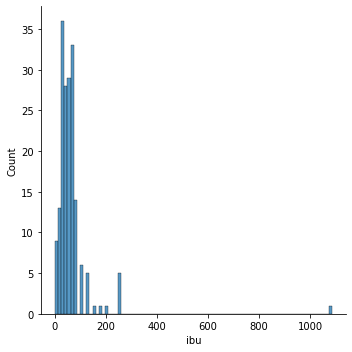

In [9]:
# A very asymmetric distribution, influencied by outliers.
sns.displot(data["ibu"])

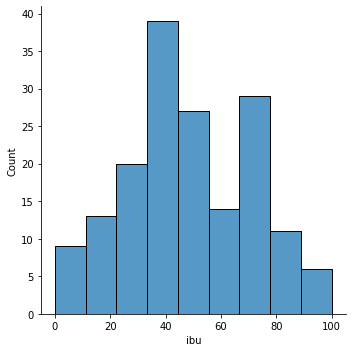

In [10]:
data = data[data["ibu"]<=120]
sns.displot(data["ibu"])

#### 2.3 Feature Engineering

In this quick step, we can generate new variables from the original ones.

For example, we can:

- Take the difference between the original and final gravity.
- ph is a variable with almost no variability (it's std = 0.37 and it's value for 25%, 50% and 75% quartile are equal). We could drop this variable, however, only for the sake of reproducibility (applied later), we can apply the exponential function to it and then, divide by the "target_og". 

Again, this procedure can make no sense at all, either for the model or for the business. However, I  want to show how the pipeline can be configured to mirror all the data transformation applied to the train set using sklearn.

In [11]:
# dg stands for difference gravity
data["target_dg"] = data["target_fg"] - data["target_og"]
data["fake_var"] = np.exp(data["ph"])/data["target_og"]

In [12]:
# Glimpse of the final dataframe
data

id                                  name  abv   ibu  target_fg  \
210  232                        Ace Of Equinox  4.5  40.0     1011.0   
294  276                   Nine To Five Wizard  7.5  35.0     1012.0   
30   227                 Brewdog Vs Beavertown  9.2  50.0     1085.0   
136  102                         Peach Therapy  9.0  30.0     1000.0   
214  260                       New England IPA  6.8  45.0     1012.0   
..   ...                                   ...  ...   ...        ...   
76   107                 HBC 366 - IPA Is Dead  7.2  70.0     1012.0   
143   89                                 Citra  7.5  70.0     1013.0   
217  300                        Indie Pale Ale  4.2  30.0     1008.0   
190  248                         Twin Atlantic  5.0  80.0     1011.0   
153  104  India Pale Weizen (w/ Weihenstephan)  6.2  50.0     1010.0   

     target_og   ebc   srm   ph  target_dg  fake_var  
210     1045.0  18.0   9.0  4.2      -34.0  0.063815  
294     1069.0  20.0  10.0  4.3      -57.0  0.068943  
30      1016.0  78.8  40.0  4.2       69.0  0.065636  
136     1071.0  12.0   6.0  3.6      -71.0  0.034172  
214     1065.0  17.0   9.0  4.2      -53.0  0.062616  
..         ...   ...   ...  ...        ...       ...  
76      1067.0  30.0  15.0  4.4      -55.0  0.076336  
143     1068.0  30.0  15.0  4.4      -55.0  0.076265  
217     1044.0  16.6   8.0  4.6      -36.0  0.095291  
190     1048.0  19.0   9.7  5.2      -37.0  0.172970  
153     1056.0  35.0  17.5  4.0      -46.0  0.051703  

[168 rows x 11 columns]

In [13]:
# A few list por parametrizing later functions

# List of variables for missing imputer
imputer_varibles = [
    "abv",
    "target_fg",
    "target_og",
    "ebc",
    "srm",
    "ph"
]

# List of unwanted variables for machine learning model
to_drop_train = [
    "id",
    "name",
    "ibu"
]

### 3. The Data Science Model Stage

The machine learning stages have a lot of steps for outputting the best method for predict incoming data. Reproducibility is sacred as a mantra, so we need to keep records of which value a variable had its missing value imputed with, apply the very same transformation that features had passed through the dev environment to production and other methods a data scientist infer to its data to generate ammo for better results.

In this step, we export a custom object that uses mlflow for experiment tracking with two models and some collection of hyperparameters for tunning. The process will record the best model, with its metrics and hyperparameters chosen from grid search's cross-validation to the mlflow ui. The artifacts generated will be able to help developers to recreate the same environment for production, for reproducibility.

In [14]:
df_train = df_train[df_train["ph"]<=14]
df_train = df_train[df_train["srm"]<=40]
df_train = df_train[df_train["ebc"]<=80]
df_train = df_train[df_train["ibu"]<=120]

X = df_train.drop(to_drop_train, axis=1)
y = df_train["ibu"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=16)

In [15]:
# Dicts for Model' GridSearch
cat_parameters = {
    'iterations': [300, 450, 700], 
    'learning_rate': [1, 0.1, 0.01], 
    'max_depth': [2,3,4]
}

rfr_parameters = {
    'n_estimators': [300, 450, 700], 
    'max_depth': [1, 3, 7]
}

# Our target variable.
target = "ibu"

The models used are CatBoost Regressor and the Random Forest Regressor. A number of other models could be used here as well. To grasp the TrainerRegressor functionality, check the **mlflow_utils.py** file.

In [16]:
cat_model_opt = TrainerRegressor(CatBoostRegressor)
cat_model_opt.train_test_split(X=X, y=y)
cat_model_opt.gridsearch_tuning(dict_params=cat_parameters, kfold_num=10)
cat_model_opt.mlflow_run(model_name="catboost_regressor", optimal_param=True)

0:	learn: 18.6039149	total: 49ms	remaining: 14.7s
1:	learn: 16.6745400	total: 49.3ms	remaining: 7.35s
2:	learn: 15.8385911	total: 49.4ms	remaining: 4.89s
3:	learn: 14.8906276	total: 49.5ms	remaining: 3.66s
4:	learn: 13.9078251	total: 49.6ms	remaining: 2.92s
5:	learn: 12.0726300	total: 49.6ms	remaining: 2.43s
6:	learn: 11.4125912	total: 49.7ms	remaining: 2.08s
7:	learn: 10.6502650	total: 49.8ms	remaining: 1.82s
8:	learn: 9.6719593	total: 49.9ms	remaining: 1.61s
9:	learn: 9.0030838	total: 49.9ms	remaining: 1.45s
10:	learn: 8.4709229	total: 50ms	remaining: 1.31s
11:	learn: 7.9603572	total: 50ms	remaining: 1.2s
12:	learn: 7.6318897	total: 50.1ms	remaining: 1.11s
13:	learn: 7.2295914	total: 50.3ms	remaining: 1.03s
14:	learn: 6.9134335	total: 50.3ms	remaining: 957ms
15:	learn: 6.7257864	total: 50.5ms	remaining: 896ms
16:	learn: 6.4289287	total: 50.5ms	remaining: 841ms
17:	learn: 6.2155170	total: 50.6ms	remaining: 793ms
18:	learn: 5.8804912	total: 50.7ms	remaining: 749ms
19:	learn: 5.6259728	

1:	learn: 15.0423828	total: 964us	remaining: 144ms
2:	learn: 14.4261561	total: 1.27ms	remaining: 125ms
3:	learn: 13.5845189	total: 1.39ms	remaining: 103ms
4:	learn: 13.2794317	total: 1.5ms	remaining: 88.3ms
5:	learn: 11.9576852	total: 1.61ms	remaining: 79.1ms
6:	learn: 10.5634606	total: 1.75ms	remaining: 73.2ms
7:	learn: 9.5438754	total: 1.85ms	remaining: 67.7ms
8:	learn: 8.7879874	total: 1.97ms	remaining: 63.6ms
9:	learn: 8.5309539	total: 2.08ms	remaining: 60.5ms
10:	learn: 8.0165213	total: 2.2ms	remaining: 57.8ms
11:	learn: 7.4458345	total: 2.31ms	remaining: 55.4ms
12:	learn: 6.9566260	total: 2.49ms	remaining: 55ms
13:	learn: 6.5892461	total: 2.55ms	remaining: 52.1ms
14:	learn: 6.2666110	total: 2.6ms	remaining: 49.4ms
15:	learn: 5.8842104	total: 2.65ms	remaining: 47.1ms
16:	learn: 5.3657185	total: 2.71ms	remaining: 45.1ms
17:	learn: 4.9557743	total: 2.77ms	remaining: 43.3ms
18:	learn: 4.6491497	total: 2.87ms	remaining: 42.5ms
19:	learn: 4.4803971	total: 2.97ms	remaining: 41.6ms
20:	l

23:	learn: 4.0294422	total: 3.22ms	remaining: 37ms
24:	learn: 3.8455601	total: 3.54ms	remaining: 38.9ms
25:	learn: 3.5925192	total: 3.66ms	remaining: 38.6ms
26:	learn: 3.5302292	total: 3.77ms	remaining: 38.2ms
27:	learn: 3.3067265	total: 3.92ms	remaining: 38.1ms
28:	learn: 3.1272662	total: 4.04ms	remaining: 37.8ms
29:	learn: 3.0448310	total: 4.19ms	remaining: 37.7ms
30:	learn: 2.9201063	total: 4.3ms	remaining: 37.3ms
31:	learn: 2.7623098	total: 4.41ms	remaining: 36.9ms
32:	learn: 2.6138474	total: 4.55ms	remaining: 36.8ms
33:	learn: 2.4142856	total: 4.65ms	remaining: 36.4ms
34:	learn: 2.3149257	total: 4.78ms	remaining: 36.2ms
35:	learn: 2.1971292	total: 4.93ms	remaining: 36.2ms
36:	learn: 2.1200024	total: 5.06ms	remaining: 36ms
37:	learn: 2.0482558	total: 5.18ms	remaining: 35.7ms
38:	learn: 1.9591211	total: 5.45ms	remaining: 36.4ms
39:	learn: 1.8636760	total: 5.58ms	remaining: 36.3ms
40:	learn: 1.7940455	total: 5.64ms	remaining: 35.6ms
41:	learn: 1.6693371	total: 5.69ms	remaining: 35ms


157:	learn: 0.0234395	total: 19.9ms	remaining: 17.9ms
158:	learn: 0.0230675	total: 20.2ms	remaining: 17.9ms
159:	learn: 0.0223388	total: 20.3ms	remaining: 17.8ms
160:	learn: 0.0213971	total: 20.4ms	remaining: 17.6ms
161:	learn: 0.0202574	total: 20.5ms	remaining: 17.5ms
162:	learn: 0.0195550	total: 20.7ms	remaining: 17.4ms
163:	learn: 0.0184240	total: 20.8ms	remaining: 17.2ms
164:	learn: 0.0178710	total: 20.9ms	remaining: 17.1ms
165:	learn: 0.0173467	total: 21ms	remaining: 16.9ms
166:	learn: 0.0168357	total: 21.1ms	remaining: 16.8ms
167:	learn: 0.0164086	total: 21.2ms	remaining: 16.6ms
168:	learn: 0.0154957	total: 21.3ms	remaining: 16.5ms
169:	learn: 0.0149417	total: 21.5ms	remaining: 16.4ms
170:	learn: 0.0141276	total: 21.6ms	remaining: 16.3ms
171:	learn: 0.0136271	total: 21.7ms	remaining: 16.1ms
172:	learn: 0.0132607	total: 21.8ms	remaining: 16ms
173:	learn: 0.0131180	total: 21.9ms	remaining: 15.9ms
174:	learn: 0.0126440	total: 22ms	remaining: 15.7ms
175:	learn: 0.0123182	total: 22.1m

117:	learn: 0.0010565	total: 17.3ms	remaining: 26.6ms
118:	learn: 0.0010242	total: 17.4ms	remaining: 26.5ms
119:	learn: 0.0009915	total: 17.5ms	remaining: 26.2ms
120:	learn: 0.0008811	total: 17.6ms	remaining: 26ms
121:	learn: 0.0008476	total: 17.6ms	remaining: 25.7ms
122:	learn: 0.0007996	total: 17.7ms	remaining: 25.5ms
123:	learn: 0.0007605	total: 17.8ms	remaining: 25.3ms
124:	learn: 0.0007097	total: 17.9ms	remaining: 25ms
125:	learn: 0.0006926	total: 17.9ms	remaining: 24.8ms
126:	learn: 0.0006366	total: 18ms	remaining: 24.6ms
127:	learn: 0.0006221	total: 18.1ms	remaining: 24.3ms
128:	learn: 0.0005452	total: 18.2ms	remaining: 24.1ms
129:	learn: 0.0005221	total: 18.3ms	remaining: 23.9ms
130:	learn: 0.0004687	total: 18.3ms	remaining: 23.6ms
131:	learn: 0.0004291	total: 18.4ms	remaining: 23.4ms
132:	learn: 0.0003991	total: 18.5ms	remaining: 23.2ms
133:	learn: 0.0003811	total: 18.5ms	remaining: 23ms
134:	learn: 0.0003595	total: 18.6ms	remaining: 22.7ms
135:	learn: 0.0003473	total: 18.7ms	

2:	learn: 15.1064825	total: 9.23ms	remaining: 913ms
3:	learn: 14.1479587	total: 9.49ms	remaining: 702ms
4:	learn: 12.9470307	total: 9.63ms	remaining: 568ms
5:	learn: 11.7845046	total: 9.76ms	remaining: 478ms
6:	learn: 10.9691201	total: 9.88ms	remaining: 413ms
7:	learn: 9.4581174	total: 10ms	remaining: 366ms
8:	learn: 8.4668981	total: 10.2ms	remaining: 329ms
9:	learn: 7.2373540	total: 10.3ms	remaining: 299ms
10:	learn: 6.3389721	total: 10.4ms	remaining: 274ms
11:	learn: 5.6244042	total: 10.6ms	remaining: 254ms
12:	learn: 4.7225647	total: 10.7ms	remaining: 237ms
13:	learn: 4.1759056	total: 10.8ms	remaining: 222ms
14:	learn: 3.6857142	total: 11ms	remaining: 208ms
15:	learn: 3.4195821	total: 11.1ms	remaining: 197ms
16:	learn: 3.0470944	total: 11.2ms	remaining: 187ms
17:	learn: 2.7558967	total: 11.4ms	remaining: 178ms
18:	learn: 2.5117276	total: 11.5ms	remaining: 170ms
19:	learn: 2.3209573	total: 11.6ms	remaining: 163ms
20:	learn: 2.0844504	total: 11.9ms	remaining: 158ms
21:	learn: 1.931811

76:	learn: 0.0233985	total: 10.6ms	remaining: 30.7ms
77:	learn: 0.0216575	total: 12.6ms	remaining: 35.8ms
78:	learn: 0.0196967	total: 12.8ms	remaining: 35.7ms
79:	learn: 0.0165568	total: 12.9ms	remaining: 35.4ms
80:	learn: 0.0148260	total: 13ms	remaining: 35.2ms
81:	learn: 0.0133471	total: 13.2ms	remaining: 35ms
82:	learn: 0.0127740	total: 13.3ms	remaining: 34.8ms
83:	learn: 0.0113295	total: 13.4ms	remaining: 34.5ms
84:	learn: 0.0106873	total: 13.6ms	remaining: 34.3ms
85:	learn: 0.0095663	total: 13.7ms	remaining: 34.1ms
86:	learn: 0.0085634	total: 13.8ms	remaining: 33.8ms
87:	learn: 0.0078722	total: 14ms	remaining: 33.6ms
88:	learn: 0.0070703	total: 14.1ms	remaining: 33.4ms
89:	learn: 0.0066622	total: 14.3ms	remaining: 33.3ms
90:	learn: 0.0064065	total: 14.4ms	remaining: 33.1ms
91:	learn: 0.0057644	total: 14.7ms	remaining: 33.3ms
92:	learn: 0.0055946	total: 14.9ms	remaining: 33.1ms
93:	learn: 0.0055119	total: 15ms	remaining: 32.8ms
94:	learn: 0.0050305	total: 15.1ms	remaining: 32.6ms
9

0:	learn: 16.6675879	total: 294us	remaining: 88ms
1:	learn: 15.1064537	total: 526us	remaining: 78.4ms
2:	learn: 14.6018836	total: 663us	remaining: 65.7ms
3:	learn: 12.2901700	total: 805us	remaining: 59.6ms
4:	learn: 10.6843918	total: 989us	remaining: 58.4ms
5:	learn: 9.9354999	total: 1.16ms	remaining: 56.7ms
6:	learn: 9.5104655	total: 1.29ms	remaining: 54.2ms
7:	learn: 7.5678882	total: 1.46ms	remaining: 53.3ms
8:	learn: 6.5617175	total: 1.54ms	remaining: 49.7ms
9:	learn: 5.8833097	total: 1.69ms	remaining: 49.1ms
10:	learn: 5.2622624	total: 1.8ms	remaining: 47.4ms
11:	learn: 4.3857708	total: 1.96ms	remaining: 47ms
12:	learn: 3.5403109	total: 2.1ms	remaining: 46.3ms
13:	learn: 3.0174438	total: 6.34ms	remaining: 129ms
14:	learn: 2.7243761	total: 6.55ms	remaining: 124ms
15:	learn: 2.6465849	total: 6.7ms	remaining: 119ms
16:	learn: 2.3914759	total: 6.86ms	remaining: 114ms
17:	learn: 2.3327964	total: 7.11ms	remaining: 111ms
18:	learn: 2.1805686	total: 7.24ms	remaining: 107ms
19:	learn: 1.925

5:	learn: 9.4323074	total: 1.34ms	remaining: 65.6ms
6:	learn: 7.9777253	total: 1.63ms	remaining: 68.2ms
7:	learn: 6.7217877	total: 1.8ms	remaining: 65.9ms
8:	learn: 6.0206711	total: 2.07ms	remaining: 67ms
9:	learn: 5.7072483	total: 2.25ms	remaining: 65.3ms
10:	learn: 4.9161816	total: 2.41ms	remaining: 63.3ms
11:	learn: 3.8324080	total: 2.55ms	remaining: 61.2ms
12:	learn: 3.6842976	total: 2.69ms	remaining: 59.4ms
13:	learn: 2.9471968	total: 2.97ms	remaining: 60.7ms
14:	learn: 2.3417102	total: 3.12ms	remaining: 59.3ms
15:	learn: 2.0201486	total: 3.27ms	remaining: 58.1ms
16:	learn: 1.7766920	total: 3.42ms	remaining: 57ms
17:	learn: 1.5969347	total: 3.72ms	remaining: 58.3ms
18:	learn: 1.4782029	total: 4.01ms	remaining: 59.4ms
19:	learn: 1.4076449	total: 4.17ms	remaining: 58.4ms
20:	learn: 1.1882795	total: 4.34ms	remaining: 57.7ms
21:	learn: 1.0680913	total: 4.48ms	remaining: 56.7ms
22:	learn: 0.9360955	total: 4.64ms	remaining: 55.9ms
23:	learn: 0.8330067	total: 4.78ms	remaining: 55ms
24:	l

100:	learn: 0.0001900	total: 15.7ms	remaining: 30.9ms
101:	learn: 0.0001610	total: 15.9ms	remaining: 30.9ms
102:	learn: 0.0001485	total: 16.1ms	remaining: 30.8ms
103:	learn: 0.0001429	total: 16.2ms	remaining: 30.6ms
104:	learn: 0.0001295	total: 16.4ms	remaining: 30.5ms
105:	learn: 0.0001126	total: 16.6ms	remaining: 30.4ms
106:	learn: 0.0001018	total: 16.8ms	remaining: 30.3ms
107:	learn: 0.0000958	total: 17ms	remaining: 30.2ms
108:	learn: 0.0000829	total: 17.1ms	remaining: 30ms
109:	learn: 0.0000771	total: 17.3ms	remaining: 29.9ms
110:	learn: 0.0000725	total: 17.5ms	remaining: 29.8ms
111:	learn: 0.0000661	total: 17.6ms	remaining: 29.6ms
112:	learn: 0.0000619	total: 17.8ms	remaining: 29.4ms
113:	learn: 0.0000572	total: 18ms	remaining: 29.3ms
114:	learn: 0.0000516	total: 18.2ms	remaining: 29.3ms
115:	learn: 0.0000466	total: 18.4ms	remaining: 29.2ms
116:	learn: 0.0000398	total: 18.5ms	remaining: 29ms
117:	learn: 0.0000344	total: 18.7ms	remaining: 28.8ms
118:	learn: 0.0000309	total: 18.8ms	

169:	learn: 0.0000004	total: 27.2ms	remaining: 20.8ms
170:	learn: 0.0000003	total: 27.5ms	remaining: 20.8ms
171:	learn: 0.0000003	total: 27.7ms	remaining: 20.6ms
172:	learn: 0.0000003	total: 27.8ms	remaining: 20.4ms
173:	learn: 0.0000003	total: 28ms	remaining: 20.3ms
174:	learn: 0.0000002	total: 28.1ms	remaining: 20.1ms
175:	learn: 0.0000002	total: 28.3ms	remaining: 19.9ms
176:	learn: 0.0000002	total: 28.4ms	remaining: 19.8ms
177:	learn: 0.0000002	total: 28.7ms	remaining: 19.7ms
178:	learn: 0.0000002	total: 28.9ms	remaining: 19.5ms
179:	learn: 0.0000001	total: 29ms	remaining: 19.4ms
180:	learn: 0.0000001	total: 29.2ms	remaining: 19.2ms
181:	learn: 0.0000001	total: 29.4ms	remaining: 19ms
182:	learn: 0.0000001	total: 29.5ms	remaining: 18.9ms
183:	learn: 0.0000001	total: 29.7ms	remaining: 18.7ms
184:	learn: 0.0000001	total: 29.8ms	remaining: 18.5ms
185:	learn: 0.0000001	total: 30ms	remaining: 18.4ms
186:	learn: 0.0000001	total: 30.1ms	remaining: 18.2ms
187:	learn: 0.0000001	total: 30.3ms	

296:	learn: 0.0000000	total: 45ms	remaining: 454us
297:	learn: 0.0000000	total: 45.3ms	remaining: 303us
298:	learn: 0.0000000	total: 45.4ms	remaining: 151us
299:	learn: 0.0000000	total: 45.6ms	remaining: 0us
0:	learn: 18.3745357	total: 154us	remaining: 46.2ms
1:	learn: 15.9780551	total: 377us	remaining: 56.3ms
2:	learn: 14.0975063	total: 539us	remaining: 53.4ms
3:	learn: 12.2715261	total: 693us	remaining: 51.3ms
4:	learn: 11.4669182	total: 842us	remaining: 49.7ms
5:	learn: 10.4841735	total: 990us	remaining: 48.5ms
6:	learn: 8.1384611	total: 1.28ms	remaining: 53.4ms
7:	learn: 7.0645275	total: 1.47ms	remaining: 53.8ms
8:	learn: 5.6958478	total: 1.69ms	remaining: 54.8ms
9:	learn: 4.4549316	total: 1.85ms	remaining: 53.8ms
10:	learn: 3.8459319	total: 2.06ms	remaining: 54.1ms
11:	learn: 3.0786492	total: 2.21ms	remaining: 53ms
12:	learn: 2.2145360	total: 2.36ms	remaining: 52.2ms
13:	learn: 2.0008034	total: 2.55ms	remaining: 52ms
14:	learn: 1.8194192	total: 2.71ms	remaining: 51.5ms
15:	learn: 

0:	learn: 22.7729659	total: 115us	remaining: 34.5ms
1:	learn: 22.3013372	total: 431us	remaining: 64.4ms
2:	learn: 21.8711136	total: 678us	remaining: 67.1ms
3:	learn: 21.3899372	total: 808us	remaining: 59.8ms
4:	learn: 20.9394726	total: 910us	remaining: 53.7ms
5:	learn: 20.5974675	total: 1.14ms	remaining: 55.7ms
6:	learn: 20.1020632	total: 1.26ms	remaining: 52.8ms
7:	learn: 19.8263114	total: 1.4ms	remaining: 51ms
8:	learn: 19.4306971	total: 1.51ms	remaining: 48.8ms
9:	learn: 18.9298256	total: 1.61ms	remaining: 46.7ms
10:	learn: 18.5105671	total: 1.71ms	remaining: 45ms
11:	learn: 18.3489919	total: 1.81ms	remaining: 43.5ms
12:	learn: 18.0827765	total: 1.9ms	remaining: 42ms
13:	learn: 17.8838094	total: 2ms	remaining: 40.8ms
14:	learn: 17.6652656	total: 2.09ms	remaining: 39.8ms
15:	learn: 17.4913896	total: 2.19ms	remaining: 38.9ms
16:	learn: 17.2511799	total: 2.29ms	remaining: 38.1ms
17:	learn: 17.0612048	total: 2.39ms	remaining: 37.4ms
18:	learn: 16.8853144	total: 2.48ms	remaining: 36.7ms


92:	learn: 8.3976470	total: 11.1ms	remaining: 24.6ms
93:	learn: 8.3503352	total: 11.4ms	remaining: 24.9ms
94:	learn: 8.3291666	total: 11.5ms	remaining: 24.9ms
95:	learn: 8.2946901	total: 11.6ms	remaining: 24.7ms
96:	learn: 8.2747462	total: 11.7ms	remaining: 24.6ms
97:	learn: 8.2306737	total: 11.9ms	remaining: 24.4ms
98:	learn: 8.1277415	total: 12ms	remaining: 24.3ms
99:	learn: 8.1082930	total: 12.1ms	remaining: 24.1ms
100:	learn: 8.0900496	total: 12.2ms	remaining: 24ms
101:	learn: 8.0259067	total: 12.3ms	remaining: 23.9ms
102:	learn: 7.9792281	total: 12.4ms	remaining: 23.8ms
103:	learn: 7.9618183	total: 12.5ms	remaining: 23.6ms
104:	learn: 7.9182831	total: 12.6ms	remaining: 23.5ms
105:	learn: 7.8599978	total: 12.8ms	remaining: 23.4ms
106:	learn: 7.8125938	total: 12.9ms	remaining: 23.2ms
107:	learn: 7.7737920	total: 13ms	remaining: 23.1ms
108:	learn: 7.7405835	total: 13.7ms	remaining: 24ms
109:	learn: 7.7233440	total: 13.8ms	remaining: 23.9ms
110:	learn: 7.6474461	total: 13.9ms	remainin

149:	learn: 5.4381395	total: 16.9ms	remaining: 16.9ms
150:	learn: 5.4110597	total: 16.9ms	remaining: 16.7ms
151:	learn: 5.3943132	total: 17.3ms	remaining: 16.8ms
152:	learn: 5.3420595	total: 17.4ms	remaining: 16.7ms
153:	learn: 5.3126930	total: 17.5ms	remaining: 16.6ms
154:	learn: 5.2966141	total: 17.7ms	remaining: 16.5ms
155:	learn: 5.2434275	total: 17.8ms	remaining: 16.4ms
156:	learn: 5.2336285	total: 17.9ms	remaining: 16.3ms
157:	learn: 5.2063413	total: 18ms	remaining: 16.1ms
158:	learn: 5.1766629	total: 18.1ms	remaining: 16ms
159:	learn: 5.1541064	total: 18.2ms	remaining: 15.9ms
160:	learn: 5.1266777	total: 18.3ms	remaining: 15.8ms
161:	learn: 5.1051674	total: 18.5ms	remaining: 15.7ms
162:	learn: 5.0814788	total: 18.6ms	remaining: 15.6ms
163:	learn: 5.0661793	total: 18.7ms	remaining: 15.5ms
164:	learn: 5.0199528	total: 18.8ms	remaining: 15.4ms
165:	learn: 4.9740692	total: 18.9ms	remaining: 15.3ms
166:	learn: 4.9273407	total: 19ms	remaining: 15.2ms
167:	learn: 4.9028801	total: 19.1m

223:	learn: 4.5398597	total: 25.2ms	remaining: 8.55ms
224:	learn: 4.5201879	total: 25.3ms	remaining: 8.42ms
225:	learn: 4.4967411	total: 25.4ms	remaining: 8.31ms
226:	learn: 4.4876715	total: 25.4ms	remaining: 8.18ms
227:	learn: 4.4694554	total: 25.7ms	remaining: 8.11ms
228:	learn: 4.4462682	total: 25.8ms	remaining: 8ms
229:	learn: 4.4302542	total: 25.9ms	remaining: 7.88ms
230:	learn: 4.4078772	total: 26ms	remaining: 7.76ms
231:	learn: 4.3989198	total: 26.1ms	remaining: 7.64ms
232:	learn: 4.3817922	total: 26.2ms	remaining: 7.53ms
233:	learn: 4.3667138	total: 26.3ms	remaining: 7.41ms
234:	learn: 4.3400722	total: 26.4ms	remaining: 7.29ms
235:	learn: 4.3183471	total: 26.5ms	remaining: 7.19ms
236:	learn: 4.3023791	total: 26.6ms	remaining: 7.08ms
237:	learn: 4.2847347	total: 26.7ms	remaining: 6.96ms
238:	learn: 4.2758755	total: 26.8ms	remaining: 6.84ms
239:	learn: 4.2585769	total: 26.9ms	remaining: 6.73ms
240:	learn: 4.2351723	total: 27ms	remaining: 6.61ms
241:	learn: 4.2084084	total: 27.1ms

269:	learn: 1.4884971	total: 35.5ms	remaining: 3.94ms
270:	learn: 1.4796328	total: 35.8ms	remaining: 3.83ms
271:	learn: 1.4756489	total: 35.9ms	remaining: 3.7ms
272:	learn: 1.4669256	total: 36.1ms	remaining: 3.56ms
273:	learn: 1.4512757	total: 36.2ms	remaining: 3.43ms
274:	learn: 1.4456263	total: 36.3ms	remaining: 3.3ms
275:	learn: 1.4387944	total: 36.5ms	remaining: 3.17ms
276:	learn: 1.4259870	total: 36.6ms	remaining: 3.04ms
277:	learn: 1.4223725	total: 36.7ms	remaining: 2.91ms
278:	learn: 1.4142145	total: 36.9ms	remaining: 2.77ms
279:	learn: 1.4108058	total: 37ms	remaining: 2.64ms
280:	learn: 1.4031215	total: 37.1ms	remaining: 2.51ms
281:	learn: 1.3926501	total: 37.2ms	remaining: 2.37ms
282:	learn: 1.3786552	total: 37.3ms	remaining: 2.24ms
283:	learn: 1.3684387	total: 37.5ms	remaining: 2.11ms
284:	learn: 1.3494691	total: 37.6ms	remaining: 1.98ms
285:	learn: 1.3404883	total: 37.7ms	remaining: 1.85ms
286:	learn: 1.3328535	total: 37.8ms	remaining: 1.71ms
287:	learn: 1.3200288	total: 37.

225:	learn: 2.3992620	total: 31.1ms	remaining: 10.2ms
226:	learn: 2.3773268	total: 31.4ms	remaining: 10.1ms
227:	learn: 2.3666426	total: 31.5ms	remaining: 9.96ms
228:	learn: 2.3441751	total: 31.7ms	remaining: 9.83ms
229:	learn: 2.3341987	total: 31.8ms	remaining: 9.69ms
230:	learn: 2.3236613	total: 32ms	remaining: 9.56ms
231:	learn: 2.3066759	total: 32.1ms	remaining: 9.42ms
232:	learn: 2.2909993	total: 32.3ms	remaining: 9.28ms
233:	learn: 2.2663303	total: 32.4ms	remaining: 9.14ms
234:	learn: 2.2516643	total: 32.5ms	remaining: 8.99ms
235:	learn: 2.2344561	total: 32.6ms	remaining: 8.85ms
236:	learn: 2.2115945	total: 32.7ms	remaining: 8.7ms
237:	learn: 2.1959535	total: 32.9ms	remaining: 8.56ms
238:	learn: 2.1698806	total: 33ms	remaining: 8.41ms
239:	learn: 2.1463220	total: 33.1ms	remaining: 8.27ms
240:	learn: 2.1315225	total: 33.2ms	remaining: 8.13ms
241:	learn: 2.1086337	total: 33.3ms	remaining: 7.98ms
242:	learn: 2.0881549	total: 33.4ms	remaining: 7.84ms
243:	learn: 2.0777411	total: 33.5

262:	learn: 1.7995374	total: 28.9ms	remaining: 4.07ms
263:	learn: 1.7896871	total: 29.2ms	remaining: 3.98ms
264:	learn: 1.7760274	total: 29.4ms	remaining: 3.88ms
265:	learn: 1.7615510	total: 29.5ms	remaining: 3.77ms
266:	learn: 1.7526571	total: 29.7ms	remaining: 3.67ms
267:	learn: 1.7441712	total: 29.8ms	remaining: 3.56ms
268:	learn: 1.7360750	total: 29.9ms	remaining: 3.45ms
269:	learn: 1.7252874	total: 30ms	remaining: 3.34ms
270:	learn: 1.7168386	total: 30.2ms	remaining: 3.23ms
271:	learn: 1.7077301	total: 30.3ms	remaining: 3.12ms
272:	learn: 1.6953374	total: 30.4ms	remaining: 3.01ms
273:	learn: 1.6873775	total: 30.5ms	remaining: 2.9ms
274:	learn: 1.6796179	total: 30.7ms	remaining: 2.79ms
275:	learn: 1.6683870	total: 30.8ms	remaining: 2.68ms
276:	learn: 1.6635912	total: 30.9ms	remaining: 2.57ms
277:	learn: 1.6547395	total: 31ms	remaining: 2.46ms
278:	learn: 1.6473706	total: 31.2ms	remaining: 2.35ms
279:	learn: 1.6398117	total: 31.3ms	remaining: 2.24ms
280:	learn: 1.6317580	total: 31.4

285:	learn: 0.6409625	total: 37.8ms	remaining: 1.85ms
286:	learn: 0.6352478	total: 38.1ms	remaining: 1.73ms
287:	learn: 0.6323244	total: 38.3ms	remaining: 1.59ms
288:	learn: 0.6256544	total: 38.4ms	remaining: 1.46ms
289:	learn: 0.6203489	total: 38.6ms	remaining: 1.33ms
290:	learn: 0.6161956	total: 38.7ms	remaining: 1.2ms
291:	learn: 0.6123482	total: 38.8ms	remaining: 1.06ms
292:	learn: 0.6030438	total: 39ms	remaining: 931us
293:	learn: 0.5999013	total: 39.1ms	remaining: 798us
294:	learn: 0.5897996	total: 39.3ms	remaining: 665us
295:	learn: 0.5816349	total: 39.4ms	remaining: 532us
296:	learn: 0.5740542	total: 39.6ms	remaining: 399us
297:	learn: 0.5657713	total: 39.7ms	remaining: 266us
298:	learn: 0.5608555	total: 39.9ms	remaining: 133us
299:	learn: 0.5519655	total: 40ms	remaining: 0us
0:	learn: 21.1136439	total: 145us	remaining: 43.6ms
1:	learn: 20.4228531	total: 386us	remaining: 57.6ms
2:	learn: 19.7401817	total: 541us	remaining: 53.6ms
3:	learn: 19.4149715	total: 704us	remaining: 52.2

60:	learn: 7.5112361	total: 11.5ms	remaining: 45.2ms
61:	learn: 7.3808204	total: 14.2ms	remaining: 54.5ms
62:	learn: 7.2707199	total: 14.5ms	remaining: 54.4ms
63:	learn: 7.2217595	total: 14.7ms	remaining: 54.1ms
64:	learn: 7.1307583	total: 15ms	remaining: 54.2ms
65:	learn: 7.0383085	total: 15.2ms	remaining: 54ms
66:	learn: 6.9320602	total: 15.4ms	remaining: 53.6ms
67:	learn: 6.8062644	total: 15.6ms	remaining: 53.3ms
68:	learn: 6.7061558	total: 15.8ms	remaining: 52.9ms
69:	learn: 6.6156429	total: 16ms	remaining: 52.6ms
70:	learn: 6.4856637	total: 16.2ms	remaining: 52.2ms
71:	learn: 6.4052091	total: 16.3ms	remaining: 51.8ms
72:	learn: 6.3222808	total: 16.6ms	remaining: 51.5ms
73:	learn: 6.2159419	total: 16.7ms	remaining: 51.1ms
74:	learn: 6.1396274	total: 16.9ms	remaining: 50.8ms
75:	learn: 6.0474849	total: 17.1ms	remaining: 50.4ms
76:	learn: 5.8933167	total: 17.3ms	remaining: 50.1ms
77:	learn: 5.8140436	total: 17.5ms	remaining: 49.7ms
78:	learn: 5.7080232	total: 17.7ms	remaining: 49.4ms

71:	learn: 6.3181634	total: 14ms	remaining: 44.5ms
72:	learn: 6.2420864	total: 14.3ms	remaining: 44.6ms
73:	learn: 6.1736999	total: 14.5ms	remaining: 44.4ms
74:	learn: 6.1289490	total: 14.7ms	remaining: 44.1ms
75:	learn: 6.0644521	total: 14.9ms	remaining: 43.9ms
76:	learn: 5.9441236	total: 15.1ms	remaining: 43.8ms
77:	learn: 5.8414962	total: 15.3ms	remaining: 43.5ms
78:	learn: 5.7477224	total: 15.5ms	remaining: 43.3ms
79:	learn: 5.6421323	total: 15.7ms	remaining: 43ms
80:	learn: 5.6028928	total: 15.8ms	remaining: 42.8ms
81:	learn: 5.5703195	total: 16ms	remaining: 42.6ms
82:	learn: 5.4788074	total: 16.2ms	remaining: 42.4ms
83:	learn: 5.3883991	total: 16.3ms	remaining: 42ms
84:	learn: 5.3158058	total: 16.5ms	remaining: 41.8ms
85:	learn: 5.2183640	total: 16.7ms	remaining: 41.5ms
86:	learn: 5.1425375	total: 16.9ms	remaining: 41.5ms
87:	learn: 5.1088868	total: 17.1ms	remaining: 41.3ms
88:	learn: 5.0399921	total: 17.3ms	remaining: 41ms
89:	learn: 4.9895532	total: 17.5ms	remaining: 40.8ms
90:

105:	learn: 5.1114294	total: 20.3ms	remaining: 37.1ms
106:	learn: 5.0305124	total: 20.6ms	remaining: 37.1ms
107:	learn: 4.9672108	total: 20.8ms	remaining: 36.9ms
108:	learn: 4.9407980	total: 21ms	remaining: 36.7ms
109:	learn: 4.9096312	total: 21.2ms	remaining: 36.5ms
110:	learn: 4.8817888	total: 21.3ms	remaining: 36.4ms
111:	learn: 4.8131539	total: 21.5ms	remaining: 36.1ms
112:	learn: 4.7840472	total: 21.7ms	remaining: 35.9ms
113:	learn: 4.7711259	total: 21.9ms	remaining: 35.7ms
114:	learn: 4.7332154	total: 22.1ms	remaining: 35.5ms
115:	learn: 4.6698032	total: 22.2ms	remaining: 35.3ms
116:	learn: 4.6428691	total: 22.4ms	remaining: 35.1ms
117:	learn: 4.6204838	total: 22.6ms	remaining: 34.8ms
118:	learn: 4.5737520	total: 22.8ms	remaining: 34.6ms
119:	learn: 4.5133621	total: 23ms	remaining: 34.5ms
120:	learn: 4.4466984	total: 23.2ms	remaining: 34.3ms
121:	learn: 4.4263827	total: 23.4ms	remaining: 34.1ms
122:	learn: 4.3787144	total: 23.6ms	remaining: 33.9ms
123:	learn: 4.3464798	total: 23.

141:	learn: 2.6849527	total: 27.1ms	remaining: 30.1ms
142:	learn: 2.6576839	total: 29.6ms	remaining: 32.5ms
143:	learn: 2.6320773	total: 29.8ms	remaining: 32.3ms
144:	learn: 2.5995538	total: 30.1ms	remaining: 32.2ms
145:	learn: 2.5778801	total: 30.3ms	remaining: 32ms
146:	learn: 2.5386489	total: 30.6ms	remaining: 31.8ms
147:	learn: 2.5123374	total: 30.8ms	remaining: 31.6ms
148:	learn: 2.4892274	total: 31ms	remaining: 31.5ms
149:	learn: 2.4539923	total: 31.2ms	remaining: 31.2ms
150:	learn: 2.4296768	total: 31.4ms	remaining: 31ms
151:	learn: 2.4068514	total: 31.6ms	remaining: 30.7ms
152:	learn: 2.3856789	total: 31.8ms	remaining: 30.5ms
153:	learn: 2.3642384	total: 31.9ms	remaining: 30.3ms
154:	learn: 2.3441212	total: 32.1ms	remaining: 30ms
155:	learn: 2.3239985	total: 32.3ms	remaining: 29.8ms
156:	learn: 2.3050957	total: 32.5ms	remaining: 29.6ms
157:	learn: 2.2746693	total: 32.7ms	remaining: 29.4ms
158:	learn: 2.2465930	total: 32.9ms	remaining: 29.1ms
159:	learn: 2.2286613	total: 33.1ms	

292:	learn: 14.4253633	total: 32.8ms	remaining: 783us
293:	learn: 14.4142542	total: 33.1ms	remaining: 676us
294:	learn: 14.4012782	total: 33.2ms	remaining: 563us
295:	learn: 14.3908202	total: 33.4ms	remaining: 450us
296:	learn: 14.3770635	total: 33.5ms	remaining: 338us
297:	learn: 14.3656364	total: 33.6ms	remaining: 225us
298:	learn: 14.3481976	total: 33.7ms	remaining: 112us
299:	learn: 14.3378046	total: 33.8ms	remaining: 0us
0:	learn: 23.4448147	total: 124us	remaining: 37.4ms
1:	learn: 23.3783767	total: 319us	remaining: 47.5ms
2:	learn: 23.3046537	total: 476us	remaining: 47.1ms
3:	learn: 23.2024665	total: 637us	remaining: 47.2ms
4:	learn: 23.1256083	total: 794us	remaining: 46.8ms
5:	learn: 23.0706346	total: 914us	remaining: 44.8ms
6:	learn: 22.9858920	total: 1.04ms	remaining: 43.6ms
7:	learn: 22.9275680	total: 1.16ms	remaining: 42.3ms
8:	learn: 22.8376384	total: 1.3ms	remaining: 42.2ms
9:	learn: 22.7422016	total: 1.43ms	remaining: 41.6ms
10:	learn: 22.6396529	total: 1.58ms	remaining: 

218:	learn: 16.1746207	total: 26.7ms	remaining: 9.86ms
219:	learn: 16.1587080	total: 26.7ms	remaining: 9.72ms
220:	learn: 16.1448680	total: 27.1ms	remaining: 9.68ms
221:	learn: 16.1145951	total: 27.2ms	remaining: 9.57ms
222:	learn: 16.0904154	total: 27.4ms	remaining: 9.45ms
223:	learn: 16.0742343	total: 27.5ms	remaining: 9.33ms
224:	learn: 16.0517186	total: 27.6ms	remaining: 9.2ms
225:	learn: 16.0291569	total: 27.7ms	remaining: 9.08ms
226:	learn: 16.0165452	total: 27.8ms	remaining: 8.96ms
227:	learn: 15.9938397	total: 28ms	remaining: 8.84ms
228:	learn: 15.9530065	total: 28.1ms	remaining: 8.71ms
229:	learn: 15.9276581	total: 28.2ms	remaining: 8.59ms
230:	learn: 15.9106231	total: 28.3ms	remaining: 8.47ms
231:	learn: 15.8981719	total: 28.5ms	remaining: 8.35ms
232:	learn: 15.8858390	total: 28.6ms	remaining: 8.22ms
233:	learn: 15.8591710	total: 28.7ms	remaining: 8.1ms
234:	learn: 15.8479817	total: 28.8ms	remaining: 7.97ms
235:	learn: 15.8334562	total: 28.9ms	remaining: 7.85ms
236:	learn: 15

270:	learn: 14.4786188	total: 26.3ms	remaining: 2.82ms
271:	learn: 14.4600676	total: 26.6ms	remaining: 2.74ms
272:	learn: 14.4406678	total: 26.7ms	remaining: 2.64ms
273:	learn: 14.4240113	total: 26.8ms	remaining: 2.54ms
274:	learn: 14.4005325	total: 26.9ms	remaining: 2.44ms
275:	learn: 14.3807847	total: 27ms	remaining: 2.35ms
276:	learn: 14.3730526	total: 27.1ms	remaining: 2.25ms
277:	learn: 14.3592120	total: 27.2ms	remaining: 2.15ms
278:	learn: 14.3497776	total: 27.3ms	remaining: 2.05ms
279:	learn: 14.3389181	total: 27.4ms	remaining: 1.95ms
280:	learn: 14.3199709	total: 27.4ms	remaining: 1.85ms
281:	learn: 14.3106370	total: 27.5ms	remaining: 1.76ms
282:	learn: 14.2947364	total: 27.6ms	remaining: 1.66ms
283:	learn: 14.2829545	total: 27.7ms	remaining: 1.56ms
284:	learn: 14.2753004	total: 27.8ms	remaining: 1.46ms
285:	learn: 14.2632774	total: 27.8ms	remaining: 1.36ms
286:	learn: 14.2491689	total: 27.9ms	remaining: 1.26ms
287:	learn: 14.2324968	total: 28ms	remaining: 1.17ms
288:	learn: 14

13:	learn: 20.8400691	total: 2.11ms	remaining: 43.1ms
14:	learn: 20.7976301	total: 2.38ms	remaining: 45.2ms
15:	learn: 20.7108159	total: 2.46ms	remaining: 43.8ms
16:	learn: 20.6775716	total: 2.54ms	remaining: 42.3ms
17:	learn: 20.6342321	total: 2.62ms	remaining: 41ms
18:	learn: 20.5616104	total: 2.69ms	remaining: 39.8ms
19:	learn: 20.5247172	total: 2.76ms	remaining: 38.7ms
20:	learn: 20.4838538	total: 2.83ms	remaining: 37.6ms
21:	learn: 20.4192872	total: 2.9ms	remaining: 36.7ms
22:	learn: 20.3700542	total: 2.98ms	remaining: 35.9ms
23:	learn: 20.3231469	total: 3.06ms	remaining: 35.3ms
24:	learn: 20.2840576	total: 3.13ms	remaining: 34.5ms
25:	learn: 20.2386744	total: 3.21ms	remaining: 33.9ms
26:	learn: 20.2027165	total: 3.29ms	remaining: 33.3ms
27:	learn: 20.1529610	total: 3.36ms	remaining: 32.6ms
28:	learn: 20.0991610	total: 3.54ms	remaining: 33.1ms
29:	learn: 20.0485674	total: 4ms	remaining: 36ms
30:	learn: 20.0076158	total: 4.07ms	remaining: 35.4ms
31:	learn: 19.9556522	total: 4.14ms	

102:	learn: 18.4544427	total: 11.5ms	remaining: 22ms
103:	learn: 18.4273015	total: 11.8ms	remaining: 22.2ms
104:	learn: 18.3875025	total: 11.9ms	remaining: 22.2ms
105:	learn: 18.3577637	total: 12.1ms	remaining: 22.1ms
106:	learn: 18.3133949	total: 12.2ms	remaining: 22ms
107:	learn: 18.2823396	total: 12.3ms	remaining: 21.9ms
108:	learn: 18.2412952	total: 12.4ms	remaining: 21.8ms
109:	learn: 18.1935604	total: 12.5ms	remaining: 21.6ms
110:	learn: 18.1696336	total: 12.6ms	remaining: 21.5ms
111:	learn: 18.1360482	total: 12.8ms	remaining: 21.4ms
112:	learn: 18.1083004	total: 12.9ms	remaining: 21.3ms
113:	learn: 18.0715770	total: 13ms	remaining: 21.2ms
114:	learn: 18.0153373	total: 13.1ms	remaining: 21.1ms
115:	learn: 17.9764483	total: 13.2ms	remaining: 20.9ms
116:	learn: 17.9346643	total: 13.3ms	remaining: 20.8ms
117:	learn: 17.9077319	total: 13.4ms	remaining: 20.7ms
118:	learn: 17.8639991	total: 13.5ms	remaining: 20.6ms
119:	learn: 17.8271609	total: 13.7ms	remaining: 20.5ms
120:	learn: 17.7

154:	learn: 15.8254890	total: 17.6ms	remaining: 16.5ms
155:	learn: 15.8080198	total: 17.9ms	remaining: 16.5ms
156:	learn: 15.7594112	total: 18ms	remaining: 16.4ms
157:	learn: 15.7336217	total: 18.1ms	remaining: 16.3ms
158:	learn: 15.6966815	total: 18.3ms	remaining: 16.2ms
159:	learn: 15.6681940	total: 18.4ms	remaining: 16.1ms
160:	learn: 15.6361688	total: 18.5ms	remaining: 16ms
161:	learn: 15.6125453	total: 18.6ms	remaining: 15.9ms
162:	learn: 15.5822419	total: 18.7ms	remaining: 15.7ms
163:	learn: 15.5515378	total: 18.8ms	remaining: 15.6ms
164:	learn: 15.5230117	total: 19ms	remaining: 15.5ms
165:	learn: 15.4954514	total: 19.1ms	remaining: 15.4ms
166:	learn: 15.4803115	total: 19.2ms	remaining: 15.3ms
167:	learn: 15.4562843	total: 19.3ms	remaining: 15.2ms
168:	learn: 15.4374173	total: 19.4ms	remaining: 15.1ms
169:	learn: 15.4076367	total: 19.5ms	remaining: 14.9ms
170:	learn: 15.3680442	total: 19.7ms	remaining: 14.8ms
171:	learn: 15.3518273	total: 19.8ms	remaining: 14.7ms
172:	learn: 15.3

178:	learn: 15.4033665	total: 23.9ms	remaining: 16.2ms
179:	learn: 15.3714528	total: 24.2ms	remaining: 16.1ms
180:	learn: 15.3548049	total: 24.3ms	remaining: 16ms
181:	learn: 15.3371622	total: 24.5ms	remaining: 15.9ms
182:	learn: 15.3234314	total: 24.6ms	remaining: 15.7ms
183:	learn: 15.2976451	total: 24.8ms	remaining: 15.6ms
184:	learn: 15.2698961	total: 24.9ms	remaining: 15.5ms
185:	learn: 15.2407570	total: 25ms	remaining: 15.3ms
186:	learn: 15.2150759	total: 25.1ms	remaining: 15.2ms
187:	learn: 15.1966227	total: 25.3ms	remaining: 15.1ms
188:	learn: 15.1762964	total: 25.4ms	remaining: 14.9ms
189:	learn: 15.1520486	total: 25.5ms	remaining: 14.8ms
190:	learn: 15.1269072	total: 25.7ms	remaining: 14.7ms
191:	learn: 15.0992886	total: 25.8ms	remaining: 14.5ms
192:	learn: 15.0839443	total: 26ms	remaining: 14.4ms
193:	learn: 15.0663759	total: 26.1ms	remaining: 14.3ms
194:	learn: 15.0425142	total: 26.3ms	remaining: 14.1ms
195:	learn: 15.0035873	total: 26.4ms	remaining: 14ms
196:	learn: 14.982

113:	learn: 16.9514297	total: 15.7ms	remaining: 25.7ms
114:	learn: 16.9061947	total: 16ms	remaining: 25.7ms
115:	learn: 16.8740397	total: 16.1ms	remaining: 25.6ms
116:	learn: 16.8326624	total: 16.3ms	remaining: 25.5ms
117:	learn: 16.8072937	total: 16.4ms	remaining: 25.3ms
118:	learn: 16.7834101	total: 16.5ms	remaining: 25.1ms
119:	learn: 16.7594470	total: 16.7ms	remaining: 25ms
120:	learn: 16.7295054	total: 16.8ms	remaining: 24.9ms
121:	learn: 16.6952998	total: 17ms	remaining: 24.8ms
122:	learn: 16.6625706	total: 17.1ms	remaining: 24.6ms
123:	learn: 16.6408696	total: 17.3ms	remaining: 24.5ms
124:	learn: 16.6084357	total: 17.4ms	remaining: 24.4ms
125:	learn: 16.5781304	total: 17.5ms	remaining: 24.2ms
126:	learn: 16.5460067	total: 17.7ms	remaining: 24.1ms
127:	learn: 16.5102687	total: 17.8ms	remaining: 23.9ms
128:	learn: 16.4717113	total: 18ms	remaining: 23.8ms
129:	learn: 16.4541704	total: 18.1ms	remaining: 23.7ms
130:	learn: 16.4144378	total: 18.3ms	remaining: 23.6ms
131:	learn: 16.374

136:	learn: 16.8437063	total: 88.8ms	remaining: 106ms
137:	learn: 16.8051183	total: 89.7ms	remaining: 105ms
138:	learn: 16.7755511	total: 90.4ms	remaining: 105ms
139:	learn: 16.7382315	total: 91.1ms	remaining: 104ms
140:	learn: 16.7125473	total: 91.9ms	remaining: 104ms
141:	learn: 16.6917795	total: 92.6ms	remaining: 103ms
142:	learn: 16.6594327	total: 93.3ms	remaining: 102ms
143:	learn: 16.6350609	total: 94ms	remaining: 102ms
144:	learn: 16.6037696	total: 94.8ms	remaining: 101ms
145:	learn: 16.5759808	total: 95.5ms	remaining: 101ms
146:	learn: 16.5392129	total: 96.2ms	remaining: 100ms
147:	learn: 16.5196311	total: 97ms	remaining: 99.6ms
148:	learn: 16.4994529	total: 97.6ms	remaining: 98.9ms
149:	learn: 16.4694117	total: 98.2ms	remaining: 98.2ms
150:	learn: 16.4310917	total: 98.9ms	remaining: 97.5ms
151:	learn: 16.3981752	total: 99.6ms	remaining: 96.9ms
152:	learn: 16.3679027	total: 100ms	remaining: 96.4ms
153:	learn: 16.3363464	total: 101ms	remaining: 95.8ms
154:	learn: 16.3122657	tota

237:	learn: 12.7922276	total: 46.6ms	remaining: 12.2ms
238:	learn: 12.7702352	total: 46.9ms	remaining: 12ms
239:	learn: 12.7537312	total: 47.1ms	remaining: 11.8ms
240:	learn: 12.7333803	total: 47.3ms	remaining: 11.6ms
241:	learn: 12.7012269	total: 47.5ms	remaining: 11.4ms
242:	learn: 12.6765293	total: 47.7ms	remaining: 11.2ms
243:	learn: 12.6615023	total: 47.9ms	remaining: 11ms
244:	learn: 12.6385990	total: 48.1ms	remaining: 10.8ms
245:	learn: 12.6086651	total: 48.3ms	remaining: 10.6ms
246:	learn: 12.5880284	total: 48.5ms	remaining: 10.4ms
247:	learn: 12.5771812	total: 48.7ms	remaining: 10.2ms
248:	learn: 12.5536890	total: 48.9ms	remaining: 10ms
249:	learn: 12.5295453	total: 49ms	remaining: 9.8ms
250:	learn: 12.4932790	total: 49.2ms	remaining: 9.6ms
251:	learn: 12.4775367	total: 49.3ms	remaining: 9.39ms
252:	learn: 12.4520472	total: 49.5ms	remaining: 9.19ms
253:	learn: 12.4323976	total: 49.6ms	remaining: 8.98ms
254:	learn: 12.4033021	total: 49.8ms	remaining: 8.78ms
255:	learn: 12.38510

0:	learn: 24.0946486	total: 152us	remaining: 45.6ms
1:	learn: 24.0411694	total: 424us	remaining: 63.2ms
2:	learn: 23.9661193	total: 586us	remaining: 58.1ms
3:	learn: 23.9054976	total: 751us	remaining: 55.6ms
4:	learn: 23.8391515	total: 912us	remaining: 53.8ms
5:	learn: 23.7908098	total: 1.09ms	remaining: 53.5ms
6:	learn: 23.7234274	total: 1.29ms	remaining: 54.2ms
7:	learn: 23.6469350	total: 1.44ms	remaining: 52.7ms
8:	learn: 23.5765318	total: 1.62ms	remaining: 52.5ms
9:	learn: 23.5036015	total: 1.8ms	remaining: 52.3ms
10:	learn: 23.4360398	total: 1.96ms	remaining: 51.6ms
11:	learn: 23.3698104	total: 2.12ms	remaining: 50.8ms
12:	learn: 23.3148340	total: 2.28ms	remaining: 50.4ms
13:	learn: 23.2490504	total: 2.45ms	remaining: 50ms
14:	learn: 23.1767589	total: 2.6ms	remaining: 49.5ms
15:	learn: 23.1171093	total: 2.77ms	remaining: 49.1ms
16:	learn: 23.0503547	total: 2.92ms	remaining: 48.7ms
17:	learn: 22.9817360	total: 3.08ms	remaining: 48.3ms
18:	learn: 22.9245546	total: 3.23ms	remaining: 

263:	learn: 0.0004355	total: 27.3ms	remaining: 19.2ms
264:	learn: 0.0004088	total: 27.5ms	remaining: 19.2ms
265:	learn: 0.0003955	total: 27.7ms	remaining: 19.1ms
266:	learn: 0.0003679	total: 27.8ms	remaining: 19ms
267:	learn: 0.0003490	total: 27.9ms	remaining: 19ms
268:	learn: 0.0003401	total: 28ms	remaining: 18.8ms
269:	learn: 0.0003292	total: 28.1ms	remaining: 18.8ms
270:	learn: 0.0003170	total: 28.2ms	remaining: 18.7ms
271:	learn: 0.0003076	total: 28.4ms	remaining: 18.6ms
272:	learn: 0.0002965	total: 28.5ms	remaining: 18.5ms
273:	learn: 0.0002787	total: 28.6ms	remaining: 18.4ms
274:	learn: 0.0002694	total: 28.7ms	remaining: 18.3ms
275:	learn: 0.0002612	total: 28.8ms	remaining: 18.2ms
276:	learn: 0.0002558	total: 28.9ms	remaining: 18ms
277:	learn: 0.0002518	total: 29ms	remaining: 17.9ms
278:	learn: 0.0002408	total: 29.1ms	remaining: 17.8ms
279:	learn: 0.0002308	total: 29.2ms	remaining: 17.7ms
280:	learn: 0.0002271	total: 29.3ms	remaining: 17.6ms
281:	learn: 0.0002157	total: 29.4ms	re

105:	learn: 0.1762256	total: 53.8ms	remaining: 175ms
106:	learn: 0.1699782	total: 54.8ms	remaining: 176ms
107:	learn: 0.1607434	total: 55.3ms	remaining: 175ms
108:	learn: 0.1564637	total: 55.8ms	remaining: 175ms
109:	learn: 0.1528641	total: 56.3ms	remaining: 174ms
110:	learn: 0.1498217	total: 56.8ms	remaining: 174ms
111:	learn: 0.1454005	total: 57.3ms	remaining: 173ms
112:	learn: 0.1400270	total: 57.8ms	remaining: 172ms
113:	learn: 0.1271635	total: 58.3ms	remaining: 172ms
114:	learn: 0.1192765	total: 58.8ms	remaining: 171ms
115:	learn: 0.1136928	total: 59.3ms	remaining: 171ms
116:	learn: 0.1121547	total: 59.9ms	remaining: 170ms
117:	learn: 0.1106513	total: 60.5ms	remaining: 170ms
118:	learn: 0.1088320	total: 61ms	remaining: 170ms
119:	learn: 0.1041140	total: 61.5ms	remaining: 169ms
120:	learn: 0.1010890	total: 62ms	remaining: 169ms
121:	learn: 0.0979626	total: 62.6ms	remaining: 168ms
122:	learn: 0.0967497	total: 63.1ms	remaining: 168ms
123:	learn: 0.0909956	total: 63.6ms	remaining: 167

331:	learn: 0.0001451	total: 35.4ms	remaining: 12.6ms
332:	learn: 0.0001379	total: 35.6ms	remaining: 12.5ms
333:	learn: 0.0001353	total: 35.7ms	remaining: 12.4ms
334:	learn: 0.0001329	total: 35.9ms	remaining: 12.3ms
335:	learn: 0.0001308	total: 36ms	remaining: 12.2ms
336:	learn: 0.0001263	total: 36.1ms	remaining: 12.1ms
337:	learn: 0.0001210	total: 36.2ms	remaining: 12ms
338:	learn: 0.0001188	total: 36.3ms	remaining: 11.9ms
339:	learn: 0.0001129	total: 36.4ms	remaining: 11.8ms
340:	learn: 0.0001102	total: 36.5ms	remaining: 11.7ms
341:	learn: 0.0001068	total: 36.7ms	remaining: 11.6ms
342:	learn: 0.0001036	total: 36.8ms	remaining: 11.5ms
343:	learn: 0.0001016	total: 36.9ms	remaining: 11.4ms
344:	learn: 0.0000995	total: 37ms	remaining: 11.2ms
345:	learn: 0.0000965	total: 37.1ms	remaining: 11.1ms
346:	learn: 0.0000938	total: 37.1ms	remaining: 11ms
347:	learn: 0.0000912	total: 37.2ms	remaining: 10.9ms
348:	learn: 0.0000902	total: 37.3ms	remaining: 10.8ms
349:	learn: 0.0000865	total: 37.4ms	

389:	learn: 0.0000065	total: 36.9ms	remaining: 5.67ms
390:	learn: 0.0000062	total: 37ms	remaining: 5.59ms
391:	learn: 0.0000060	total: 37.1ms	remaining: 5.49ms
392:	learn: 0.0000058	total: 37.2ms	remaining: 5.4ms
393:	learn: 0.0000055	total: 37.3ms	remaining: 5.3ms
394:	learn: 0.0000055	total: 37.4ms	remaining: 5.21ms
395:	learn: 0.0000053	total: 37.5ms	remaining: 5.12ms
396:	learn: 0.0000050	total: 37.6ms	remaining: 5.02ms
397:	learn: 0.0000049	total: 37.7ms	remaining: 4.93ms
398:	learn: 0.0000047	total: 37.8ms	remaining: 4.83ms
399:	learn: 0.0000046	total: 37.9ms	remaining: 4.74ms
400:	learn: 0.0000045	total: 38ms	remaining: 4.65ms
401:	learn: 0.0000041	total: 38.1ms	remaining: 4.55ms
402:	learn: 0.0000040	total: 38.2ms	remaining: 4.46ms
403:	learn: 0.0000038	total: 38.3ms	remaining: 4.36ms
404:	learn: 0.0000038	total: 38.4ms	remaining: 4.27ms
405:	learn: 0.0000037	total: 38.5ms	remaining: 4.17ms
406:	learn: 0.0000036	total: 38.6ms	remaining: 4.08ms
407:	learn: 0.0000035	total: 38.7m

110:	learn: 0.1069149	total: 10.5ms	remaining: 32.2ms
111:	learn: 0.1030290	total: 10.6ms	remaining: 32ms
112:	learn: 0.1010354	total: 12.7ms	remaining: 37.8ms
113:	learn: 0.0984113	total: 12.8ms	remaining: 37.6ms
114:	learn: 0.0966658	total: 12.9ms	remaining: 37.5ms
115:	learn: 0.0900378	total: 13ms	remaining: 37.4ms
116:	learn: 0.0878723	total: 13.1ms	remaining: 37.3ms
117:	learn: 0.0848445	total: 13.2ms	remaining: 37.1ms
118:	learn: 0.0816654	total: 13.3ms	remaining: 36.9ms
119:	learn: 0.0778130	total: 13.4ms	remaining: 36.8ms
120:	learn: 0.0755708	total: 13.5ms	remaining: 36.6ms
121:	learn: 0.0728379	total: 13.6ms	remaining: 36.5ms
122:	learn: 0.0707895	total: 13.7ms	remaining: 36.3ms
123:	learn: 0.0701071	total: 13.8ms	remaining: 36.2ms
124:	learn: 0.0665524	total: 13.9ms	remaining: 36ms
125:	learn: 0.0636041	total: 13.9ms	remaining: 35.9ms
126:	learn: 0.0620660	total: 14ms	remaining: 35.7ms
127:	learn: 0.0601678	total: 14.1ms	remaining: 35.5ms
128:	learn: 0.0581585	total: 14.2ms	

155:	learn: 0.0000722	total: 30.5ms	remaining: 57.4ms
156:	learn: 0.0000682	total: 30.8ms	remaining: 57.4ms
157:	learn: 0.0000588	total: 30.9ms	remaining: 57.1ms
158:	learn: 0.0000536	total: 31ms	remaining: 56.8ms
159:	learn: 0.0000518	total: 31.2ms	remaining: 56.5ms
160:	learn: 0.0000481	total: 31.3ms	remaining: 56.2ms
161:	learn: 0.0000436	total: 31.4ms	remaining: 55.8ms
162:	learn: 0.0000406	total: 31.6ms	remaining: 55.6ms
163:	learn: 0.0000386	total: 31.7ms	remaining: 55.3ms
164:	learn: 0.0000352	total: 31.8ms	remaining: 54.9ms
165:	learn: 0.0000320	total: 31.9ms	remaining: 54.6ms
166:	learn: 0.0000296	total: 32ms	remaining: 54.3ms
167:	learn: 0.0000278	total: 32.2ms	remaining: 54ms
168:	learn: 0.0000267	total: 32.3ms	remaining: 53.7ms
169:	learn: 0.0000244	total: 32.4ms	remaining: 53.4ms
170:	learn: 0.0000204	total: 32.5ms	remaining: 53.1ms
171:	learn: 0.0000194	total: 32.7ms	remaining: 52.8ms
172:	learn: 0.0000183	total: 32.8ms	remaining: 52.6ms
173:	learn: 0.0000173	total: 33ms	

96:	learn: 0.0053266	total: 11.5ms	remaining: 41.8ms
97:	learn: 0.0049043	total: 13.6ms	remaining: 48.9ms
98:	learn: 0.0043221	total: 13.8ms	remaining: 48.9ms
99:	learn: 0.0037868	total: 13.9ms	remaining: 48.8ms
100:	learn: 0.0034600	total: 14.1ms	remaining: 48.7ms
101:	learn: 0.0032626	total: 14.2ms	remaining: 48.5ms
102:	learn: 0.0030198	total: 14.3ms	remaining: 48.3ms
103:	learn: 0.0028441	total: 14.5ms	remaining: 48.1ms
104:	learn: 0.0026264	total: 14.6ms	remaining: 47.9ms
105:	learn: 0.0024227	total: 14.8ms	remaining: 48.2ms
106:	learn: 0.0023732	total: 15ms	remaining: 48ms
107:	learn: 0.0021856	total: 15.1ms	remaining: 47.8ms
108:	learn: 0.0020158	total: 15.3ms	remaining: 47.8ms
109:	learn: 0.0018658	total: 15.4ms	remaining: 47.6ms
110:	learn: 0.0018393	total: 15.5ms	remaining: 47.5ms
111:	learn: 0.0016959	total: 15.7ms	remaining: 47.3ms
112:	learn: 0.0016111	total: 15.8ms	remaining: 47.1ms
113:	learn: 0.0014499	total: 15.9ms	remaining: 46.9ms
114:	learn: 0.0013365	total: 16ms	re

41:	learn: 0.3783146	total: 6.84ms	remaining: 66.5ms
42:	learn: 0.3509107	total: 7.15ms	remaining: 67.7ms
43:	learn: 0.3310071	total: 7.24ms	remaining: 66.8ms
44:	learn: 0.3144088	total: 7.34ms	remaining: 66.1ms
45:	learn: 0.2900678	total: 7.43ms	remaining: 65.2ms
46:	learn: 0.2635745	total: 7.51ms	remaining: 64.4ms
47:	learn: 0.2459517	total: 7.59ms	remaining: 63.6ms
48:	learn: 0.2313137	total: 7.66ms	remaining: 62.7ms
49:	learn: 0.2186441	total: 7.73ms	remaining: 61.9ms
50:	learn: 0.2068040	total: 7.82ms	remaining: 61.1ms
51:	learn: 0.1976194	total: 7.88ms	remaining: 60.3ms
52:	learn: 0.1881935	total: 7.95ms	remaining: 59.6ms
53:	learn: 0.1766165	total: 8.04ms	remaining: 58.9ms
54:	learn: 0.1683676	total: 8.11ms	remaining: 58.2ms
55:	learn: 0.1593338	total: 8.18ms	remaining: 57.5ms
56:	learn: 0.1536217	total: 8.26ms	remaining: 57ms
57:	learn: 0.1432576	total: 8.33ms	remaining: 56.3ms
58:	learn: 0.1293393	total: 8.41ms	remaining: 55.8ms
59:	learn: 0.1172398	total: 8.48ms	remaining: 55

416:	learn: 0.0000000	total: 71.5ms	remaining: 5.66ms
417:	learn: 0.0000000	total: 71.8ms	remaining: 5.49ms
418:	learn: 0.0000000	total: 71.9ms	remaining: 5.32ms
419:	learn: 0.0000000	total: 72ms	remaining: 5.14ms
420:	learn: 0.0000000	total: 72.2ms	remaining: 4.97ms
421:	learn: 0.0000000	total: 72.3ms	remaining: 4.8ms
422:	learn: 0.0000000	total: 72.5ms	remaining: 4.63ms
423:	learn: 0.0000000	total: 72.6ms	remaining: 4.45ms
424:	learn: 0.0000000	total: 72.7ms	remaining: 4.28ms
425:	learn: 0.0000000	total: 72.9ms	remaining: 4.11ms
426:	learn: 0.0000000	total: 73ms	remaining: 3.93ms
427:	learn: 0.0000000	total: 73.1ms	remaining: 3.76ms
428:	learn: 0.0000000	total: 73.3ms	remaining: 3.58ms
429:	learn: 0.0000000	total: 74.2ms	remaining: 3.45ms
430:	learn: 0.0000000	total: 74.4ms	remaining: 3.28ms
431:	learn: 0.0000000	total: 74.7ms	remaining: 3.11ms
432:	learn: 0.0000000	total: 74.8ms	remaining: 2.94ms
433:	learn: 0.0000000	total: 75ms	remaining: 2.77ms
434:	learn: 0.0000000	total: 75.2ms

388:	learn: 0.0000000	total: 51ms	remaining: 8ms
389:	learn: 0.0000000	total: 51.3ms	remaining: 7.89ms
390:	learn: 0.0000000	total: 51.5ms	remaining: 7.76ms
391:	learn: 0.0000000	total: 51.7ms	remaining: 7.65ms
392:	learn: 0.0000000	total: 51.8ms	remaining: 7.52ms
393:	learn: 0.0000000	total: 52ms	remaining: 7.38ms
394:	learn: 0.0000000	total: 52.1ms	remaining: 7.25ms
395:	learn: 0.0000000	total: 52.2ms	remaining: 7.12ms
396:	learn: 0.0000000	total: 52.4ms	remaining: 6.99ms
397:	learn: 0.0000000	total: 52.5ms	remaining: 6.86ms
398:	learn: 0.0000000	total: 52.6ms	remaining: 6.73ms
399:	learn: 0.0000000	total: 52.8ms	remaining: 6.6ms
400:	learn: 0.0000000	total: 52.9ms	remaining: 6.47ms
401:	learn: 0.0000000	total: 53.1ms	remaining: 6.34ms
402:	learn: 0.0000000	total: 53.2ms	remaining: 6.21ms
403:	learn: 0.0000000	total: 53.3ms	remaining: 6.07ms
404:	learn: 0.0000000	total: 53.5ms	remaining: 5.94ms
405:	learn: 0.0000000	total: 53.6ms	remaining: 5.81ms
406:	learn: 0.0000000	total: 53.7ms	

350:	learn: 0.0000000	total: 48.3ms	remaining: 13.6ms
351:	learn: 0.0000000	total: 48.6ms	remaining: 13.5ms
352:	learn: 0.0000000	total: 48.8ms	remaining: 13.4ms
353:	learn: 0.0000000	total: 49ms	remaining: 13.3ms
354:	learn: 0.0000000	total: 49.3ms	remaining: 13.2ms
355:	learn: 0.0000000	total: 49.4ms	remaining: 13.1ms
356:	learn: 0.0000000	total: 49.6ms	remaining: 12.9ms
357:	learn: 0.0000000	total: 49.7ms	remaining: 12.8ms
358:	learn: 0.0000000	total: 49.9ms	remaining: 12.7ms
359:	learn: 0.0000000	total: 50ms	remaining: 12.5ms
360:	learn: 0.0000000	total: 50.2ms	remaining: 12.4ms
361:	learn: 0.0000000	total: 50.3ms	remaining: 12.2ms
362:	learn: 0.0000000	total: 50.5ms	remaining: 12.1ms
363:	learn: 0.0000000	total: 50.7ms	remaining: 12ms
364:	learn: 0.0000000	total: 50.8ms	remaining: 11.8ms
365:	learn: 0.0000000	total: 50.9ms	remaining: 11.7ms
366:	learn: 0.0000000	total: 51.1ms	remaining: 11.6ms
367:	learn: 0.0000000	total: 51.2ms	remaining: 11.4ms
368:	learn: 0.0000000	total: 51.4m

230:	learn: 0.0000000	total: 35.5ms	remaining: 33.6ms
231:	learn: 0.0000000	total: 35.8ms	remaining: 33.6ms
232:	learn: 0.0000000	total: 36ms	remaining: 33.5ms
233:	learn: 0.0000000	total: 36.1ms	remaining: 33.4ms
234:	learn: 0.0000000	total: 36.3ms	remaining: 33.2ms
235:	learn: 0.0000000	total: 36.5ms	remaining: 33.1ms
236:	learn: 0.0000000	total: 36.7ms	remaining: 33ms
237:	learn: 0.0000000	total: 36.8ms	remaining: 32.8ms
238:	learn: 0.0000000	total: 37ms	remaining: 32.7ms
239:	learn: 0.0000000	total: 37.2ms	remaining: 32.5ms
240:	learn: 0.0000000	total: 37.3ms	remaining: 32.4ms
241:	learn: 0.0000000	total: 37.5ms	remaining: 32.3ms
242:	learn: 0.0000000	total: 37.7ms	remaining: 32.1ms
243:	learn: 0.0000000	total: 37.9ms	remaining: 32ms
244:	learn: 0.0000000	total: 38ms	remaining: 31.8ms
245:	learn: 0.0000000	total: 38.2ms	remaining: 31.7ms
246:	learn: 0.0000000	total: 38.4ms	remaining: 31.6ms
247:	learn: 0.0000000	total: 38.6ms	remaining: 31.4ms
248:	learn: 0.0000000	total: 38.7ms	re

93:	learn: 0.0004023	total: 15.1ms	remaining: 57.3ms
94:	learn: 0.0003741	total: 15.4ms	remaining: 57.7ms
95:	learn: 0.0003344	total: 15.6ms	remaining: 57.7ms
96:	learn: 0.0003038	total: 15.8ms	remaining: 57.5ms
97:	learn: 0.0002690	total: 16ms	remaining: 57.3ms
98:	learn: 0.0002459	total: 16.1ms	remaining: 57.2ms
99:	learn: 0.0002192	total: 16.3ms	remaining: 57ms
100:	learn: 0.0001900	total: 16.4ms	remaining: 56.8ms
101:	learn: 0.0001610	total: 16.6ms	remaining: 56.6ms
102:	learn: 0.0001485	total: 16.7ms	remaining: 56.3ms
103:	learn: 0.0001429	total: 16.9ms	remaining: 56.2ms
104:	learn: 0.0001295	total: 17.1ms	remaining: 56ms
105:	learn: 0.0001126	total: 17.2ms	remaining: 55.8ms
106:	learn: 0.0001018	total: 17.4ms	remaining: 55.6ms
107:	learn: 0.0000958	total: 17.5ms	remaining: 55.5ms
108:	learn: 0.0000829	total: 17.7ms	remaining: 55.3ms
109:	learn: 0.0000771	total: 17.9ms	remaining: 55.2ms
110:	learn: 0.0000725	total: 18ms	remaining: 55ms
111:	learn: 0.0000661	total: 18.2ms	remaining

0:	learn: 18.8880743	total: 187us	remaining: 84.2ms
1:	learn: 13.0654480	total: 487us	remaining: 109ms
2:	learn: 11.0971276	total: 660us	remaining: 98.5ms
3:	learn: 10.4866174	total: 828us	remaining: 92.4ms
4:	learn: 9.8438401	total: 990us	remaining: 88.1ms
5:	learn: 8.7777935	total: 1.15ms	remaining: 85.1ms
6:	learn: 7.2928410	total: 1.35ms	remaining: 85.7ms
7:	learn: 6.4426876	total: 1.54ms	remaining: 84.9ms
8:	learn: 5.2633008	total: 1.72ms	remaining: 84.5ms
9:	learn: 4.5071319	total: 1.86ms	remaining: 82.1ms
10:	learn: 3.9859185	total: 2.03ms	remaining: 81.1ms
11:	learn: 3.6281683	total: 2.22ms	remaining: 81.1ms
12:	learn: 3.1128511	total: 2.38ms	remaining: 80.1ms
13:	learn: 2.6044306	total: 2.8ms	remaining: 87.3ms
14:	learn: 2.0551298	total: 2.99ms	remaining: 86.6ms
15:	learn: 1.7726564	total: 3.18ms	remaining: 86.2ms
16:	learn: 1.6250548	total: 8.66ms	remaining: 221ms
17:	learn: 1.3655760	total: 8.91ms	remaining: 214ms
18:	learn: 1.2118660	total: 9.09ms	remaining: 206ms
19:	learn

330:	learn: 0.0000000	total: 59.5ms	remaining: 21.4ms
331:	learn: 0.0000000	total: 59.7ms	remaining: 21.2ms
332:	learn: 0.0000000	total: 59.9ms	remaining: 21ms
333:	learn: 0.0000000	total: 60ms	remaining: 20.8ms
334:	learn: 0.0000000	total: 60.1ms	remaining: 20.6ms
335:	learn: 0.0000000	total: 60.3ms	remaining: 20.5ms
336:	learn: 0.0000000	total: 60.5ms	remaining: 20.3ms
337:	learn: 0.0000000	total: 60.7ms	remaining: 20.1ms
338:	learn: 0.0000000	total: 60.9ms	remaining: 19.9ms
339:	learn: 0.0000000	total: 61.1ms	remaining: 19.8ms
340:	learn: 0.0000000	total: 61.3ms	remaining: 19.6ms
341:	learn: 0.0000000	total: 61.5ms	remaining: 19.4ms
342:	learn: 0.0000000	total: 61.7ms	remaining: 19.3ms
343:	learn: 0.0000000	total: 61.9ms	remaining: 19.1ms
344:	learn: 0.0000000	total: 62ms	remaining: 18.9ms
345:	learn: 0.0000000	total: 62.2ms	remaining: 18.7ms
346:	learn: 0.0000000	total: 62.3ms	remaining: 18.5ms
347:	learn: 0.0000000	total: 62.5ms	remaining: 18.3ms
348:	learn: 0.0000000	total: 62.7m

214:	learn: 0.0000000	total: 33.5ms	remaining: 36.6ms
215:	learn: 0.0000000	total: 33.8ms	remaining: 36.6ms
216:	learn: 0.0000000	total: 34ms	remaining: 36.5ms
217:	learn: 0.0000000	total: 34.2ms	remaining: 36.4ms
218:	learn: 0.0000000	total: 34.4ms	remaining: 36.3ms
219:	learn: 0.0000000	total: 34.6ms	remaining: 36.2ms
220:	learn: 0.0000000	total: 34.8ms	remaining: 36.1ms
221:	learn: 0.0000000	total: 35ms	remaining: 35.9ms
222:	learn: 0.0000000	total: 35.2ms	remaining: 35.8ms
223:	learn: 0.0000000	total: 35.3ms	remaining: 35.6ms
224:	learn: 0.0000000	total: 35.5ms	remaining: 35.5ms
225:	learn: 0.0000000	total: 35.7ms	remaining: 35.4ms
226:	learn: 0.0000000	total: 35.9ms	remaining: 35.3ms
227:	learn: 0.0000000	total: 36ms	remaining: 35.1ms
228:	learn: 0.0000000	total: 36.2ms	remaining: 34.9ms
229:	learn: 0.0000000	total: 36.4ms	remaining: 34.8ms
230:	learn: 0.0000000	total: 36.5ms	remaining: 34.6ms
231:	learn: 0.0000000	total: 36.7ms	remaining: 34.5ms
232:	learn: 0.0000000	total: 36.8m

99:	learn: 9.0295486	total: 14.2ms	remaining: 49.8ms
100:	learn: 9.0047827	total: 14.4ms	remaining: 49.8ms
101:	learn: 8.9891173	total: 14.6ms	remaining: 49.7ms
102:	learn: 8.9504836	total: 14.7ms	remaining: 49.4ms
103:	learn: 8.9096272	total: 14.8ms	remaining: 49.3ms
104:	learn: 8.8851358	total: 15ms	remaining: 49.2ms
105:	learn: 8.8658088	total: 15.2ms	remaining: 49.3ms
106:	learn: 8.8157071	total: 15.3ms	remaining: 49ms
107:	learn: 8.7550873	total: 15.4ms	remaining: 48.8ms
108:	learn: 8.6698843	total: 15.5ms	remaining: 48.6ms
109:	learn: 8.6358262	total: 15.7ms	remaining: 48.4ms
110:	learn: 8.6139648	total: 15.8ms	remaining: 48.4ms
111:	learn: 8.5442878	total: 16ms	remaining: 48.2ms
112:	learn: 8.5154202	total: 16.1ms	remaining: 48.1ms
113:	learn: 8.4898407	total: 16.3ms	remaining: 47.9ms
114:	learn: 8.4301005	total: 16.4ms	remaining: 47.8ms
115:	learn: 8.3618366	total: 16.6ms	remaining: 47.8ms
116:	learn: 8.3348661	total: 16.7ms	remaining: 47.6ms
117:	learn: 8.3183342	total: 16.9ms

0:	learn: 22.7620132	total: 11.7ms	remaining: 5.27s
1:	learn: 22.1717106	total: 12.3ms	remaining: 2.75s
2:	learn: 21.5167694	total: 12.5ms	remaining: 1.86s
3:	learn: 20.6831578	total: 12.7ms	remaining: 1.41s
4:	learn: 20.3000458	total: 12.8ms	remaining: 1.14s
5:	learn: 19.8493948	total: 13ms	remaining: 961ms
6:	learn: 19.2398010	total: 13.1ms	remaining: 830ms
7:	learn: 18.8484320	total: 13.3ms	remaining: 732ms
8:	learn: 18.3559932	total: 13.4ms	remaining: 659ms
9:	learn: 18.0615471	total: 13.6ms	remaining: 597ms
10:	learn: 17.5668549	total: 13.7ms	remaining: 547ms
11:	learn: 17.4219419	total: 13.8ms	remaining: 505ms
12:	learn: 16.9824269	total: 14ms	remaining: 470ms
13:	learn: 16.6555246	total: 14.1ms	remaining: 439ms
14:	learn: 16.4036960	total: 14.2ms	remaining: 413ms
15:	learn: 16.0088050	total: 14.4ms	remaining: 390ms
16:	learn: 15.7442033	total: 14.5ms	remaining: 370ms
17:	learn: 15.4659170	total: 14.7ms	remaining: 353ms
18:	learn: 15.2445076	total: 14.8ms	remaining: 336ms
19:	lea

128:	learn: 7.7845066	total: 15ms	remaining: 37.2ms
129:	learn: 7.7484203	total: 15.3ms	remaining: 37.7ms
130:	learn: 7.7234572	total: 15.5ms	remaining: 37.6ms
131:	learn: 7.6916157	total: 15.6ms	remaining: 37.5ms
132:	learn: 7.6597840	total: 15.7ms	remaining: 37.4ms
133:	learn: 7.6292275	total: 15.9ms	remaining: 37.4ms
134:	learn: 7.5794779	total: 16ms	remaining: 37.3ms
135:	learn: 7.5586326	total: 16.1ms	remaining: 37.2ms
136:	learn: 7.5471195	total: 16.2ms	remaining: 37.1ms
137:	learn: 7.5180416	total: 16.4ms	remaining: 37ms
138:	learn: 7.4951958	total: 16.5ms	remaining: 37ms
139:	learn: 7.4656489	total: 16.7ms	remaining: 36.9ms
140:	learn: 7.4135494	total: 16.8ms	remaining: 36.9ms
141:	learn: 7.3888755	total: 17ms	remaining: 36.8ms
142:	learn: 7.3492477	total: 17.1ms	remaining: 36.7ms
143:	learn: 7.3008357	total: 17.3ms	remaining: 36.7ms
144:	learn: 7.2896709	total: 17.4ms	remaining: 36.6ms
145:	learn: 7.2790893	total: 17.5ms	remaining: 36.5ms
146:	learn: 7.2579437	total: 17.7ms	re

447:	learn: 1.5540934	total: 71.6ms	remaining: 319us
448:	learn: 1.5514596	total: 71.9ms	remaining: 160us
449:	learn: 1.5456880	total: 72ms	remaining: 0us
0:	learn: 23.2082957	total: 121us	remaining: 54.4ms
1:	learn: 22.7751912	total: 351us	remaining: 78.7ms
2:	learn: 22.4082531	total: 522us	remaining: 77.9ms
3:	learn: 21.7123033	total: 678us	remaining: 75.7ms
4:	learn: 21.1471586	total: 748us	remaining: 66.6ms
5:	learn: 20.8380029	total: 815us	remaining: 60.3ms
6:	learn: 20.3432409	total: 1.07ms	remaining: 67.8ms
7:	learn: 20.0743741	total: 1.16ms	remaining: 64.2ms
8:	learn: 19.8070220	total: 1.25ms	remaining: 61.4ms
9:	learn: 19.5285466	total: 1.35ms	remaining: 59.4ms
10:	learn: 19.1634015	total: 1.42ms	remaining: 56.8ms
11:	learn: 19.0185877	total: 1.49ms	remaining: 54.5ms
12:	learn: 18.6667079	total: 1.56ms	remaining: 52.5ms
13:	learn: 18.3446241	total: 1.63ms	remaining: 50.8ms
14:	learn: 18.1059254	total: 1.71ms	remaining: 49.5ms
15:	learn: 17.7854897	total: 1.77ms	remaining: 48.2

335:	learn: 2.7663124	total: 54.2ms	remaining: 18.4ms
336:	learn: 2.7645723	total: 54.7ms	remaining: 18.4ms
337:	learn: 2.7494764	total: 54.8ms	remaining: 18.2ms
338:	learn: 2.7394797	total: 54.9ms	remaining: 18ms
339:	learn: 2.7325366	total: 55ms	remaining: 17.8ms
340:	learn: 2.7012770	total: 55.1ms	remaining: 17.6ms
341:	learn: 2.6885557	total: 55.2ms	remaining: 17.4ms
342:	learn: 2.6811721	total: 55.3ms	remaining: 17.3ms
343:	learn: 2.6727848	total: 55.4ms	remaining: 17.1ms
344:	learn: 2.6596854	total: 55.5ms	remaining: 16.9ms
345:	learn: 2.6551077	total: 55.5ms	remaining: 16.7ms
346:	learn: 2.6306021	total: 55.6ms	remaining: 16.5ms
347:	learn: 2.6217295	total: 55.7ms	remaining: 16.3ms
348:	learn: 2.6080572	total: 55.8ms	remaining: 16.1ms
349:	learn: 2.6023413	total: 55.9ms	remaining: 16ms
350:	learn: 2.5807951	total: 56ms	remaining: 15.8ms
351:	learn: 2.5761732	total: 56.1ms	remaining: 15.6ms
352:	learn: 2.5632243	total: 56.3ms	remaining: 15.5ms
353:	learn: 2.5587233	total: 56.5ms	

63:	learn: 10.3407348	total: 10.7ms	remaining: 64.8ms
64:	learn: 10.2575575	total: 11.1ms	remaining: 66ms
65:	learn: 10.1860927	total: 11.3ms	remaining: 65.8ms
66:	learn: 10.1202491	total: 11.5ms	remaining: 65.5ms
67:	learn: 10.0188579	total: 11.6ms	remaining: 65.4ms
68:	learn: 9.9474987	total: 11.8ms	remaining: 65.1ms
69:	learn: 9.9057009	total: 12ms	remaining: 64.9ms
70:	learn: 9.8393876	total: 12.1ms	remaining: 64.7ms
71:	learn: 9.7500726	total: 12.3ms	remaining: 64.5ms
72:	learn: 9.7246296	total: 12.5ms	remaining: 64.4ms
73:	learn: 9.6701308	total: 12.6ms	remaining: 64.2ms
74:	learn: 9.6319080	total: 12.8ms	remaining: 64.1ms
75:	learn: 9.5512808	total: 13ms	remaining: 63.8ms
76:	learn: 9.4870810	total: 13.1ms	remaining: 63.5ms
77:	learn: 9.4177458	total: 13.3ms	remaining: 63.4ms
78:	learn: 9.3606602	total: 13.4ms	remaining: 63.2ms
79:	learn: 9.3403587	total: 13.6ms	remaining: 62.9ms
80:	learn: 9.2792255	total: 13.8ms	remaining: 62.7ms
81:	learn: 9.2288211	total: 13.9ms	remaining: 6

327:	learn: 1.2014086	total: 66.9ms	remaining: 24.9ms
328:	learn: 1.1885675	total: 67.2ms	remaining: 24.7ms
329:	learn: 1.1768792	total: 67.4ms	remaining: 24.5ms
330:	learn: 1.1727034	total: 67.5ms	remaining: 24.3ms
331:	learn: 1.1596987	total: 67.6ms	remaining: 24ms
332:	learn: 1.1496051	total: 67.7ms	remaining: 23.8ms
333:	learn: 1.1463750	total: 67.9ms	remaining: 23.6ms
334:	learn: 1.1393670	total: 68ms	remaining: 23.4ms
335:	learn: 1.1271863	total: 68.2ms	remaining: 23.1ms
336:	learn: 1.1169264	total: 68.3ms	remaining: 22.9ms
337:	learn: 1.1002625	total: 68.4ms	remaining: 22.7ms
338:	learn: 1.0892225	total: 68.5ms	remaining: 22.4ms
339:	learn: 1.0867659	total: 68.6ms	remaining: 22.2ms
340:	learn: 1.0717592	total: 68.7ms	remaining: 22ms
341:	learn: 1.0620590	total: 68.8ms	remaining: 21.7ms
342:	learn: 1.0530212	total: 69ms	remaining: 21.5ms
343:	learn: 1.0435160	total: 69.2ms	remaining: 21.3ms
344:	learn: 1.0397719	total: 69.3ms	remaining: 21.1ms
345:	learn: 1.0362115	total: 69.4ms	

424:	learn: 0.6905386	total: 112ms	remaining: 6.58ms
425:	learn: 0.6876386	total: 112ms	remaining: 6.32ms
426:	learn: 0.6865124	total: 112ms	remaining: 6.05ms
427:	learn: 0.6823238	total: 113ms	remaining: 5.79ms
428:	learn: 0.6815406	total: 113ms	remaining: 5.52ms
429:	learn: 0.6753510	total: 113ms	remaining: 5.25ms
430:	learn: 0.6721273	total: 113ms	remaining: 4.99ms
431:	learn: 0.6680301	total: 113ms	remaining: 4.72ms
432:	learn: 0.6663294	total: 116ms	remaining: 4.55ms
433:	learn: 0.6596126	total: 116ms	remaining: 4.29ms
434:	learn: 0.6555106	total: 117ms	remaining: 4.02ms
435:	learn: 0.6542599	total: 117ms	remaining: 3.75ms
436:	learn: 0.6478348	total: 117ms	remaining: 3.49ms
437:	learn: 0.6466132	total: 117ms	remaining: 3.22ms
438:	learn: 0.6438216	total: 118ms	remaining: 2.95ms
439:	learn: 0.6426506	total: 118ms	remaining: 2.68ms
440:	learn: 0.6401644	total: 118ms	remaining: 2.41ms
441:	learn: 0.6322856	total: 119ms	remaining: 2.15ms
442:	learn: 0.6284202	total: 119ms	remaining: 

43:	learn: 10.6320287	total: 10ms	remaining: 92.4ms
44:	learn: 10.5450083	total: 10.3ms	remaining: 93ms
45:	learn: 10.3518989	total: 10.5ms	remaining: 92.5ms
46:	learn: 10.1965275	total: 10.7ms	remaining: 92.1ms
47:	learn: 10.1184492	total: 10.9ms	remaining: 91.7ms
48:	learn: 9.9832943	total: 11.2ms	remaining: 91.3ms
49:	learn: 9.8910574	total: 11.4ms	remaining: 90.9ms
50:	learn: 9.7415997	total: 11.6ms	remaining: 90.8ms
51:	learn: 9.6164182	total: 11.8ms	remaining: 90.5ms
52:	learn: 9.4911549	total: 12.1ms	remaining: 90.4ms
53:	learn: 9.4187590	total: 12.4ms	remaining: 91.2ms
54:	learn: 9.2849273	total: 12.7ms	remaining: 90.9ms
55:	learn: 9.1726594	total: 12.9ms	remaining: 90.5ms
56:	learn: 9.0939883	total: 13.1ms	remaining: 90.3ms
57:	learn: 9.0232529	total: 13.3ms	remaining: 89.9ms
58:	learn: 8.9220750	total: 13.5ms	remaining: 89.5ms
59:	learn: 8.8337794	total: 13.7ms	remaining: 89.2ms
60:	learn: 8.7311650	total: 19.7ms	remaining: 126ms
61:	learn: 8.6344160	total: 20.5ms	remaining: 

160:	learn: 4.0207641	total: 33.3ms	remaining: 59.8ms
161:	learn: 3.9943795	total: 33.7ms	remaining: 59.8ms
162:	learn: 3.9430888	total: 33.9ms	remaining: 59.6ms
163:	learn: 3.9168699	total: 34.1ms	remaining: 59.4ms
164:	learn: 3.8550844	total: 34.3ms	remaining: 59.2ms
165:	learn: 3.8408539	total: 34.5ms	remaining: 58.9ms
166:	learn: 3.7992030	total: 34.7ms	remaining: 58.8ms
167:	learn: 3.7706664	total: 34.9ms	remaining: 58.5ms
168:	learn: 3.7532546	total: 35.1ms	remaining: 58.4ms
169:	learn: 3.7189255	total: 35.3ms	remaining: 58.2ms
170:	learn: 3.6863966	total: 35.6ms	remaining: 58.1ms
171:	learn: 3.6705895	total: 35.8ms	remaining: 57.9ms
172:	learn: 3.6252498	total: 36.1ms	remaining: 57.7ms
173:	learn: 3.5936021	total: 36.3ms	remaining: 57.5ms
174:	learn: 3.5624184	total: 36.6ms	remaining: 57.5ms
175:	learn: 3.5491722	total: 36.8ms	remaining: 57.3ms
176:	learn: 3.5177099	total: 37ms	remaining: 57.1ms
177:	learn: 3.4992036	total: 37.2ms	remaining: 56.9ms
178:	learn: 3.4840013	total: 3

336:	learn: 0.9328529	total: 68.5ms	remaining: 23ms
337:	learn: 0.9258020	total: 68.9ms	remaining: 22.8ms
338:	learn: 0.9165310	total: 69.2ms	remaining: 22.6ms
339:	learn: 0.9106710	total: 69.4ms	remaining: 22.4ms
340:	learn: 0.9028667	total: 69.6ms	remaining: 22.3ms
341:	learn: 0.8944286	total: 69.7ms	remaining: 22ms
342:	learn: 0.8858867	total: 70ms	remaining: 21.8ms
343:	learn: 0.8794645	total: 70.1ms	remaining: 21.6ms
344:	learn: 0.8729782	total: 70.3ms	remaining: 21.4ms
345:	learn: 0.8632886	total: 70.6ms	remaining: 21.2ms
346:	learn: 0.8566717	total: 70.9ms	remaining: 21ms
347:	learn: 0.8515035	total: 71.1ms	remaining: 20.8ms
348:	learn: 0.8455232	total: 71.3ms	remaining: 20.6ms
349:	learn: 0.8356049	total: 71.6ms	remaining: 20.4ms
350:	learn: 0.8327206	total: 71.9ms	remaining: 20.3ms
351:	learn: 0.8251461	total: 72.1ms	remaining: 20.1ms
352:	learn: 0.8193355	total: 72.3ms	remaining: 19.9ms
353:	learn: 0.8137945	total: 72.6ms	remaining: 19.7ms
354:	learn: 0.8072402	total: 72.8ms	

16:	learn: 15.5108754	total: 11.8ms	remaining: 301ms
17:	learn: 15.2011190	total: 12.3ms	remaining: 296ms
18:	learn: 14.7083395	total: 34.7ms	remaining: 788ms
19:	learn: 14.5175785	total: 35.1ms	remaining: 754ms
20:	learn: 14.2564280	total: 35.3ms	remaining: 721ms
21:	learn: 14.0200060	total: 35.6ms	remaining: 692ms
22:	learn: 13.8834625	total: 35.8ms	remaining: 665ms
23:	learn: 13.6506786	total: 36.2ms	remaining: 642ms
24:	learn: 13.5139863	total: 36.5ms	remaining: 620ms
25:	learn: 13.4330789	total: 36.8ms	remaining: 601ms
26:	learn: 13.3022460	total: 37.1ms	remaining: 581ms
27:	learn: 13.2018895	total: 37.3ms	remaining: 563ms
28:	learn: 12.8910942	total: 37.6ms	remaining: 545ms
29:	learn: 12.6948738	total: 37.8ms	remaining: 529ms
30:	learn: 12.5129632	total: 38.1ms	remaining: 515ms
31:	learn: 12.3840706	total: 38.3ms	remaining: 500ms
32:	learn: 12.1855994	total: 38.6ms	remaining: 487ms
33:	learn: 11.9264414	total: 39ms	remaining: 478ms
34:	learn: 11.8376413	total: 39.3ms	remaining: 4

78:	learn: 7.4519465	total: 16.7ms	remaining: 78.5ms
79:	learn: 7.3808653	total: 17.1ms	remaining: 79ms
80:	learn: 7.2815929	total: 17.3ms	remaining: 78.8ms
81:	learn: 7.2161549	total: 17.5ms	remaining: 78.5ms
82:	learn: 7.1241815	total: 17.8ms	remaining: 78.8ms
83:	learn: 7.0640799	total: 18.1ms	remaining: 78.7ms
84:	learn: 6.9788853	total: 18.3ms	remaining: 78.6ms
85:	learn: 6.8998498	total: 18.5ms	remaining: 78.4ms
86:	learn: 6.8679791	total: 18.7ms	remaining: 78.1ms
87:	learn: 6.8047003	total: 18.9ms	remaining: 77.9ms
88:	learn: 6.7746748	total: 19.2ms	remaining: 77.7ms
89:	learn: 6.7002398	total: 19.4ms	remaining: 77.7ms
90:	learn: 6.6386978	total: 19.7ms	remaining: 77.7ms
91:	learn: 6.5753723	total: 19.9ms	remaining: 77.6ms
92:	learn: 6.5067728	total: 20.1ms	remaining: 77.3ms
93:	learn: 6.4769780	total: 20.4ms	remaining: 77.1ms
94:	learn: 6.4230653	total: 20.6ms	remaining: 77.2ms
95:	learn: 6.3950403	total: 20.8ms	remaining: 76.7ms
96:	learn: 6.3369438	total: 21ms	remaining: 76.5

261:	learn: 1.6327596	total: 54.2ms	remaining: 38.9ms
262:	learn: 1.6223997	total: 54.5ms	remaining: 38.7ms
263:	learn: 1.6124759	total: 54.7ms	remaining: 38.6ms
264:	learn: 1.5918937	total: 54.9ms	remaining: 38.3ms
265:	learn: 1.5782936	total: 55.2ms	remaining: 38.2ms
266:	learn: 1.5507156	total: 55.4ms	remaining: 37.9ms
267:	learn: 1.5420790	total: 55.6ms	remaining: 37.7ms
268:	learn: 1.5308166	total: 55.8ms	remaining: 37.5ms
269:	learn: 1.5251314	total: 56ms	remaining: 37.4ms
270:	learn: 1.5130030	total: 56.3ms	remaining: 37.2ms
271:	learn: 1.5027827	total: 56.5ms	remaining: 37ms
272:	learn: 1.4772304	total: 56.8ms	remaining: 36.8ms
273:	learn: 1.4618753	total: 57ms	remaining: 36.6ms
274:	learn: 1.4572704	total: 57.2ms	remaining: 36.4ms
275:	learn: 1.4466271	total: 57.4ms	remaining: 36.2ms
276:	learn: 1.4422233	total: 57.6ms	remaining: 36ms
277:	learn: 1.4317115	total: 57.9ms	remaining: 35.8ms
278:	learn: 1.4235950	total: 58.1ms	remaining: 35.6ms
279:	learn: 1.4139440	total: 58.3ms	

387:	learn: 0.2544090	total: 93.5ms	remaining: 14.9ms
388:	learn: 0.2516114	total: 93.8ms	remaining: 14.7ms
389:	learn: 0.2499522	total: 94.1ms	remaining: 14.5ms
390:	learn: 0.2487336	total: 94.3ms	remaining: 14.2ms
391:	learn: 0.2470279	total: 94.5ms	remaining: 14ms
392:	learn: 0.2451052	total: 94.7ms	remaining: 13.7ms
393:	learn: 0.2438685	total: 94.9ms	remaining: 13.5ms
394:	learn: 0.2425345	total: 95.3ms	remaining: 13.3ms
395:	learn: 0.2413935	total: 95.5ms	remaining: 13ms
396:	learn: 0.2389262	total: 95.8ms	remaining: 12.8ms
397:	learn: 0.2367512	total: 96ms	remaining: 12.5ms
398:	learn: 0.2349413	total: 96.2ms	remaining: 12.3ms
399:	learn: 0.2325004	total: 96.5ms	remaining: 12.1ms
400:	learn: 0.2294440	total: 96.8ms	remaining: 11.8ms
401:	learn: 0.2280086	total: 97ms	remaining: 11.6ms
402:	learn: 0.2246663	total: 97.2ms	remaining: 11.3ms
403:	learn: 0.2234172	total: 97.6ms	remaining: 11.1ms
404:	learn: 0.2203753	total: 97.8ms	remaining: 10.9ms
405:	learn: 0.2147349	total: 98.1ms	

1:	learn: 21.9568338	total: 1.14ms	remaining: 255ms
2:	learn: 21.1597369	total: 1.54ms	remaining: 230ms
3:	learn: 20.7192689	total: 1.87ms	remaining: 209ms
4:	learn: 19.9576008	total: 2.16ms	remaining: 193ms
5:	learn: 19.5798012	total: 2.4ms	remaining: 178ms
6:	learn: 18.9788965	total: 2.67ms	remaining: 169ms
7:	learn: 18.3422821	total: 2.91ms	remaining: 161ms
8:	learn: 17.8150597	total: 3.13ms	remaining: 154ms
9:	learn: 17.4398229	total: 3.38ms	remaining: 149ms
10:	learn: 16.9788523	total: 5.26ms	remaining: 210ms
11:	learn: 16.6203906	total: 5.59ms	remaining: 204ms
12:	learn: 16.1245326	total: 5.84ms	remaining: 196ms
13:	learn: 15.8292486	total: 6.19ms	remaining: 193ms
14:	learn: 15.5382765	total: 6.48ms	remaining: 188ms
15:	learn: 15.2951743	total: 6.76ms	remaining: 183ms
16:	learn: 15.0016124	total: 7.02ms	remaining: 179ms
17:	learn: 14.7164638	total: 7.3ms	remaining: 175ms
18:	learn: 14.4994423	total: 7.58ms	remaining: 172ms
19:	learn: 14.2637541	total: 7.79ms	remaining: 168ms
20:	

127:	learn: 2.9713098	total: 30.4ms	remaining: 76.5ms
128:	learn: 2.9310148	total: 30.7ms	remaining: 76.5ms
129:	learn: 2.8806393	total: 31ms	remaining: 76.4ms
130:	learn: 2.8631737	total: 31.2ms	remaining: 76.1ms
131:	learn: 2.8043780	total: 31.5ms	remaining: 75.8ms
132:	learn: 2.7421943	total: 31.7ms	remaining: 75.6ms
133:	learn: 2.7252600	total: 31.9ms	remaining: 75.3ms
134:	learn: 2.6957063	total: 32.1ms	remaining: 75ms
135:	learn: 2.6519492	total: 32.4ms	remaining: 74.8ms
136:	learn: 2.6124977	total: 32.6ms	remaining: 74.6ms
137:	learn: 2.5854065	total: 32.9ms	remaining: 74.3ms
138:	learn: 2.5548620	total: 33.1ms	remaining: 74.1ms
139:	learn: 2.5226195	total: 33.3ms	remaining: 73.8ms
140:	learn: 2.5000537	total: 33.6ms	remaining: 73.6ms
141:	learn: 2.4751455	total: 33.8ms	remaining: 73.3ms
142:	learn: 2.4397487	total: 34ms	remaining: 73ms
143:	learn: 2.4234649	total: 34.3ms	remaining: 72.8ms
144:	learn: 2.3723154	total: 34.5ms	remaining: 72.5ms
145:	learn: 2.3568133	total: 34.7ms	

195:	learn: 1.8488773	total: 48.3ms	remaining: 62.6ms
196:	learn: 1.8357057	total: 48.7ms	remaining: 62.5ms
197:	learn: 1.8207691	total: 48.9ms	remaining: 62.3ms
198:	learn: 1.7896830	total: 49.2ms	remaining: 62ms
199:	learn: 1.7614497	total: 49.5ms	remaining: 61.8ms
200:	learn: 1.7478943	total: 49.7ms	remaining: 61.6ms
201:	learn: 1.7283485	total: 50ms	remaining: 61.4ms
202:	learn: 1.7158829	total: 50.2ms	remaining: 61.1ms
203:	learn: 1.6907199	total: 50.5ms	remaining: 60.9ms
204:	learn: 1.6624967	total: 50.7ms	remaining: 60.6ms
205:	learn: 1.6360834	total: 51ms	remaining: 60.4ms
206:	learn: 1.6247170	total: 51.2ms	remaining: 60.1ms
207:	learn: 1.6141982	total: 51.5ms	remaining: 59.9ms
208:	learn: 1.5817288	total: 51.7ms	remaining: 59.7ms
209:	learn: 1.5710880	total: 52ms	remaining: 59.4ms
210:	learn: 1.5578909	total: 52.3ms	remaining: 59.2ms
211:	learn: 1.5485045	total: 52.5ms	remaining: 59ms
212:	learn: 1.5357698	total: 52.8ms	remaining: 58.7ms
213:	learn: 1.5225959	total: 53ms	rema

322:	learn: 0.5073780	total: 75.1ms	remaining: 29.5ms
323:	learn: 0.5059967	total: 75.4ms	remaining: 29.3ms
324:	learn: 0.5010902	total: 75.8ms	remaining: 29.1ms
325:	learn: 0.4995539	total: 76ms	remaining: 28.9ms
326:	learn: 0.4966476	total: 76.2ms	remaining: 28.7ms
327:	learn: 0.4926403	total: 76.4ms	remaining: 28.4ms
328:	learn: 0.4897614	total: 76.7ms	remaining: 28.2ms
329:	learn: 0.4861141	total: 77ms	remaining: 28ms
330:	learn: 0.4833810	total: 77.2ms	remaining: 27.8ms
331:	learn: 0.4807823	total: 77.4ms	remaining: 27.5ms
332:	learn: 0.4758761	total: 77.7ms	remaining: 27.3ms
333:	learn: 0.4741690	total: 78ms	remaining: 27.1ms
334:	learn: 0.4729010	total: 78.2ms	remaining: 26.9ms
335:	learn: 0.4708202	total: 78.6ms	remaining: 26.7ms
336:	learn: 0.4664376	total: 78.8ms	remaining: 26.4ms
337:	learn: 0.4650182	total: 79.1ms	remaining: 26.2ms
338:	learn: 0.4619180	total: 79.3ms	remaining: 26ms
339:	learn: 0.4581187	total: 79.5ms	remaining: 25.7ms
340:	learn: 0.4545364	total: 79.8ms	re

428:	learn: 0.1269854	total: 105ms	remaining: 5.15ms
429:	learn: 0.1244770	total: 106ms	remaining: 4.91ms
430:	learn: 0.1221161	total: 106ms	remaining: 4.66ms
431:	learn: 0.1198949	total: 106ms	remaining: 4.42ms
432:	learn: 0.1178197	total: 106ms	remaining: 4.17ms
433:	learn: 0.1158656	total: 107ms	remaining: 3.93ms
434:	learn: 0.1139859	total: 107ms	remaining: 3.68ms
435:	learn: 0.1122983	total: 107ms	remaining: 3.44ms
436:	learn: 0.1107010	total: 107ms	remaining: 3.19ms
437:	learn: 0.1087122	total: 108ms	remaining: 2.95ms
438:	learn: 0.1072468	total: 108ms	remaining: 2.7ms
439:	learn: 0.1054674	total: 108ms	remaining: 2.46ms
440:	learn: 0.1041388	total: 108ms	remaining: 2.21ms
441:	learn: 0.1027419	total: 109ms	remaining: 1.97ms
442:	learn: 0.1010814	total: 109ms	remaining: 1.72ms
443:	learn: 0.0995421	total: 109ms	remaining: 1.47ms
444:	learn: 0.0984048	total: 109ms	remaining: 1.23ms
445:	learn: 0.0973314	total: 110ms	remaining: 983us
446:	learn: 0.0959609	total: 110ms	remaining: 73

56:	learn: 8.5339863	total: 13.3ms	remaining: 91.7ms
57:	learn: 8.4627392	total: 13.6ms	remaining: 92.1ms
58:	learn: 8.3337593	total: 13.9ms	remaining: 91.9ms
59:	learn: 8.2671110	total: 14.1ms	remaining: 91.7ms
60:	learn: 8.1639569	total: 14.3ms	remaining: 91.4ms
61:	learn: 8.0922198	total: 14.6ms	remaining: 91.2ms
62:	learn: 7.9374966	total: 14.8ms	remaining: 90.9ms
63:	learn: 7.8460128	total: 15.1ms	remaining: 91ms
64:	learn: 7.7402449	total: 15.4ms	remaining: 91.2ms
65:	learn: 7.6380958	total: 15.7ms	remaining: 91.2ms
66:	learn: 7.5795238	total: 15.9ms	remaining: 91ms
67:	learn: 7.4721676	total: 16.2ms	remaining: 91ms
68:	learn: 7.3834171	total: 16.4ms	remaining: 90.7ms
69:	learn: 7.3027389	total: 16.7ms	remaining: 90.5ms
70:	learn: 7.2485152	total: 16.9ms	remaining: 90.3ms
71:	learn: 7.1101919	total: 17.2ms	remaining: 90.2ms
72:	learn: 7.0391810	total: 17.4ms	remaining: 90ms
73:	learn: 6.9268246	total: 17.7ms	remaining: 89.8ms
74:	learn: 6.8095199	total: 17.9ms	remaining: 89.5ms
7

187:	learn: 1.7571645	total: 43.8ms	remaining: 61ms
188:	learn: 1.7335020	total: 44.1ms	remaining: 60.8ms
189:	learn: 1.7121094	total: 44.3ms	remaining: 60.6ms
190:	learn: 1.7032925	total: 44.5ms	remaining: 60.4ms
191:	learn: 1.6931437	total: 44.7ms	remaining: 60.1ms
192:	learn: 1.6750881	total: 44.9ms	remaining: 59.8ms
193:	learn: 1.6625285	total: 45.2ms	remaining: 59.6ms
194:	learn: 1.6507047	total: 45.4ms	remaining: 59.3ms
195:	learn: 1.6362922	total: 45.6ms	remaining: 59.1ms
196:	learn: 1.6255982	total: 45.8ms	remaining: 58.9ms
197:	learn: 1.6127228	total: 46.1ms	remaining: 58.6ms
198:	learn: 1.6030214	total: 46.3ms	remaining: 58.5ms
199:	learn: 1.5903886	total: 46.9ms	remaining: 58.6ms
200:	learn: 1.5746509	total: 47.1ms	remaining: 58.4ms
201:	learn: 1.5553552	total: 47.4ms	remaining: 58.2ms
202:	learn: 1.5451650	total: 47.7ms	remaining: 58ms
203:	learn: 1.5360607	total: 47.9ms	remaining: 57.8ms
204:	learn: 1.5170523	total: 48.2ms	remaining: 57.6ms
205:	learn: 1.5083214	total: 48.

236:	learn: 15.9972415	total: 57ms	remaining: 51.3ms
237:	learn: 15.9848863	total: 57.4ms	remaining: 51.1ms
238:	learn: 15.9703669	total: 57.7ms	remaining: 50.9ms
239:	learn: 15.9596968	total: 57.9ms	remaining: 50.7ms
240:	learn: 15.9476135	total: 58.1ms	remaining: 50.4ms
241:	learn: 15.9295596	total: 58.3ms	remaining: 50.1ms
242:	learn: 15.9071934	total: 58.5ms	remaining: 49.8ms
243:	learn: 15.8948617	total: 58.7ms	remaining: 49.6ms
244:	learn: 15.8809124	total: 58.9ms	remaining: 49.3ms
245:	learn: 15.8656725	total: 59.1ms	remaining: 49ms
246:	learn: 15.8494411	total: 59.3ms	remaining: 48.7ms
247:	learn: 15.8431120	total: 59.5ms	remaining: 48.4ms
248:	learn: 15.8300112	total: 59.8ms	remaining: 48.3ms
249:	learn: 15.8142322	total: 59.9ms	remaining: 47.9ms
250:	learn: 15.8115485	total: 60ms	remaining: 47.6ms
251:	learn: 15.7948503	total: 60.1ms	remaining: 47.2ms
252:	learn: 15.7828562	total: 60.2ms	remaining: 46.9ms
253:	learn: 15.7702161	total: 60.3ms	remaining: 46.5ms
254:	learn: 15.7

426:	learn: 12.4554274	total: 86.5ms	remaining: 4.66ms
427:	learn: 12.4456706	total: 86.7ms	remaining: 4.46ms
428:	learn: 12.4343553	total: 86.8ms	remaining: 4.25ms
429:	learn: 12.4228378	total: 86.9ms	remaining: 4.04ms
430:	learn: 12.4155731	total: 86.9ms	remaining: 3.83ms
431:	learn: 12.3992733	total: 87ms	remaining: 3.63ms
432:	learn: 12.3815533	total: 87.1ms	remaining: 3.42ms
433:	learn: 12.3653054	total: 87.2ms	remaining: 3.21ms
434:	learn: 12.3552295	total: 87.3ms	remaining: 3.01ms
435:	learn: 12.3430539	total: 87.4ms	remaining: 2.81ms
436:	learn: 12.3331891	total: 88.5ms	remaining: 2.63ms
437:	learn: 12.3248540	total: 88.7ms	remaining: 2.43ms
438:	learn: 12.3088005	total: 88.9ms	remaining: 2.23ms
439:	learn: 12.2979168	total: 89.1ms	remaining: 2.02ms
440:	learn: 12.2850888	total: 89.3ms	remaining: 1.82ms
441:	learn: 12.2683136	total: 89.5ms	remaining: 1.62ms
442:	learn: 12.2585694	total: 89.7ms	remaining: 1.42ms
443:	learn: 12.2383604	total: 89.9ms	remaining: 1.22ms
444:	learn: 

152:	learn: 17.0393967	total: 28.7ms	remaining: 55.7ms
153:	learn: 17.0207562	total: 29ms	remaining: 55.8ms
154:	learn: 17.0024656	total: 29.2ms	remaining: 55.6ms
155:	learn: 16.9767491	total: 29.4ms	remaining: 55.5ms
156:	learn: 16.9440688	total: 29.6ms	remaining: 55.3ms
157:	learn: 16.9193557	total: 29.9ms	remaining: 55.3ms
158:	learn: 16.8819372	total: 30.1ms	remaining: 55.1ms
159:	learn: 16.8543948	total: 30.3ms	remaining: 54.9ms
160:	learn: 16.8323219	total: 30.5ms	remaining: 54.8ms
161:	learn: 16.8089503	total: 30.7ms	remaining: 54.5ms
162:	learn: 16.7839593	total: 30.9ms	remaining: 54.4ms
163:	learn: 16.7428967	total: 31.1ms	remaining: 54.2ms
164:	learn: 16.7207865	total: 31.3ms	remaining: 54.1ms
165:	learn: 16.6886239	total: 31.5ms	remaining: 53.9ms
166:	learn: 16.6688992	total: 31.7ms	remaining: 53.7ms
167:	learn: 16.6270403	total: 31.8ms	remaining: 53.4ms
168:	learn: 16.6074940	total: 32ms	remaining: 53.2ms
169:	learn: 16.5806581	total: 32.2ms	remaining: 53ms
170:	learn: 16.5

392:	learn: 13.3316468	total: 69.6ms	remaining: 10.1ms
393:	learn: 13.3143603	total: 69.9ms	remaining: 9.94ms
394:	learn: 13.2911232	total: 70.1ms	remaining: 9.76ms
395:	learn: 13.2681520	total: 70.3ms	remaining: 9.58ms
396:	learn: 13.2525993	total: 70.5ms	remaining: 9.41ms
397:	learn: 13.2434196	total: 70.6ms	remaining: 9.23ms
398:	learn: 13.2323749	total: 70.8ms	remaining: 9.05ms
399:	learn: 13.2219629	total: 71ms	remaining: 8.88ms
400:	learn: 13.2074634	total: 71.2ms	remaining: 8.7ms
401:	learn: 13.1884374	total: 71.6ms	remaining: 8.55ms
402:	learn: 13.1789073	total: 71.8ms	remaining: 8.38ms
403:	learn: 13.1646724	total: 72ms	remaining: 8.2ms
404:	learn: 13.1490854	total: 72.2ms	remaining: 8.02ms
405:	learn: 13.1347149	total: 72.4ms	remaining: 7.85ms
406:	learn: 13.1179141	total: 72.5ms	remaining: 7.66ms
407:	learn: 13.1042395	total: 72.7ms	remaining: 7.49ms
408:	learn: 13.0903251	total: 72.9ms	remaining: 7.31ms
409:	learn: 13.0660479	total: 73.1ms	remaining: 7.13ms
410:	learn: 13.0

111:	learn: 19.0802179	total: 20ms	remaining: 60.4ms
112:	learn: 19.0507036	total: 20.4ms	remaining: 60.8ms
113:	learn: 19.0131866	total: 20.6ms	remaining: 60.7ms
114:	learn: 18.9917560	total: 20.8ms	remaining: 60.7ms
115:	learn: 18.9550517	total: 21.1ms	remaining: 60.7ms
116:	learn: 18.9152190	total: 21.3ms	remaining: 60.6ms
117:	learn: 18.8953754	total: 21.4ms	remaining: 60.4ms
118:	learn: 18.8618667	total: 21.6ms	remaining: 60.2ms
119:	learn: 18.8361046	total: 21.8ms	remaining: 60ms
120:	learn: 18.8066250	total: 22.1ms	remaining: 60ms
121:	learn: 18.7896245	total: 22.3ms	remaining: 59.9ms
122:	learn: 18.7556050	total: 22.4ms	remaining: 59.6ms
123:	learn: 18.7289818	total: 22.6ms	remaining: 59.4ms
124:	learn: 18.7065947	total: 22.8ms	remaining: 59.2ms
125:	learn: 18.6792225	total: 22.9ms	remaining: 59ms
126:	learn: 18.6540669	total: 23.1ms	remaining: 58.8ms
127:	learn: 18.6248031	total: 23.4ms	remaining: 58.8ms
128:	learn: 18.5872080	total: 23.6ms	remaining: 58.7ms
129:	learn: 18.551

399:	learn: 12.8248707	total: 66.5ms	remaining: 8.31ms
400:	learn: 12.8197426	total: 66.9ms	remaining: 8.17ms
401:	learn: 12.8070983	total: 67.1ms	remaining: 8.01ms
402:	learn: 12.7981291	total: 67.2ms	remaining: 7.84ms
403:	learn: 12.7919107	total: 67.4ms	remaining: 7.67ms
404:	learn: 12.7758763	total: 67.6ms	remaining: 7.5ms
405:	learn: 12.7650472	total: 67.7ms	remaining: 7.33ms
406:	learn: 12.7533651	total: 67.8ms	remaining: 7.17ms
407:	learn: 12.7410430	total: 68ms	remaining: 7ms
408:	learn: 12.7353635	total: 68.1ms	remaining: 6.83ms
409:	learn: 12.7231890	total: 68.3ms	remaining: 6.66ms
410:	learn: 12.7102337	total: 68.4ms	remaining: 6.49ms
411:	learn: 12.6943648	total: 68.6ms	remaining: 6.33ms
412:	learn: 12.6779919	total: 68.8ms	remaining: 6.16ms
413:	learn: 12.6685594	total: 68.9ms	remaining: 5.99ms
414:	learn: 12.6566412	total: 69.1ms	remaining: 5.83ms
415:	learn: 12.6404710	total: 69.2ms	remaining: 5.66ms
416:	learn: 12.6239345	total: 69.3ms	remaining: 5.49ms
417:	learn: 12.6

177:	learn: 15.9493303	total: 27.9ms	remaining: 42.7ms
178:	learn: 15.9112598	total: 30.7ms	remaining: 46.5ms
179:	learn: 15.9012083	total: 30.9ms	remaining: 46.4ms
180:	learn: 15.8807146	total: 31.2ms	remaining: 46.3ms
181:	learn: 15.8785689	total: 31.3ms	remaining: 46ms
182:	learn: 15.8543266	total: 31.4ms	remaining: 45.9ms
183:	learn: 15.8429993	total: 31.6ms	remaining: 45.7ms
184:	learn: 15.8144457	total: 31.7ms	remaining: 45.5ms
185:	learn: 15.7989372	total: 31.9ms	remaining: 45.3ms
186:	learn: 15.7716213	total: 32ms	remaining: 45ms
187:	learn: 15.7540608	total: 32.2ms	remaining: 44.9ms
188:	learn: 15.7366859	total: 32.3ms	remaining: 44.6ms
189:	learn: 15.7237586	total: 32.5ms	remaining: 44.4ms
190:	learn: 15.7040382	total: 32.6ms	remaining: 44.2ms
191:	learn: 15.6893807	total: 32.8ms	remaining: 44ms
192:	learn: 15.6728004	total: 32.9ms	remaining: 43.8ms
193:	learn: 15.6333177	total: 33ms	remaining: 43.5ms
194:	learn: 15.6151875	total: 33.1ms	remaining: 43.3ms
195:	learn: 15.60195

0:	learn: 21.5008881	total: 187us	remaining: 84.2ms
1:	learn: 21.4451328	total: 549us	remaining: 123ms
2:	learn: 21.3937454	total: 786us	remaining: 117ms
3:	learn: 21.3390335	total: 1.01ms	remaining: 113ms
4:	learn: 21.2553920	total: 1.23ms	remaining: 109ms
5:	learn: 21.2026282	total: 1.42ms	remaining: 105ms
6:	learn: 21.1664913	total: 1.6ms	remaining: 101ms
7:	learn: 21.1449671	total: 1.78ms	remaining: 98.2ms
8:	learn: 21.0939377	total: 1.98ms	remaining: 96.9ms
9:	learn: 21.0322001	total: 2.16ms	remaining: 95ms
10:	learn: 20.9832410	total: 2.35ms	remaining: 93.7ms
11:	learn: 20.9281773	total: 2.53ms	remaining: 92.3ms
12:	learn: 20.8864726	total: 2.71ms	remaining: 91.3ms
13:	learn: 20.8400691	total: 2.9ms	remaining: 90.4ms
14:	learn: 20.7976301	total: 3.06ms	remaining: 88.8ms
15:	learn: 20.7108159	total: 3.23ms	remaining: 87.7ms
16:	learn: 20.6775716	total: 3.44ms	remaining: 87.5ms
17:	learn: 20.6342321	total: 3.61ms	remaining: 86.6ms
18:	learn: 20.5616104	total: 3.77ms	remaining: 85.6

298:	learn: 12.3730147	total: 48ms	remaining: 24.2ms
299:	learn: 12.3651327	total: 48.3ms	remaining: 24.1ms
300:	learn: 12.3499728	total: 48.4ms	remaining: 24ms
301:	learn: 12.3326376	total: 48.6ms	remaining: 23.8ms
302:	learn: 12.3091001	total: 48.8ms	remaining: 23.7ms
303:	learn: 12.2972018	total: 49ms	remaining: 23.5ms
304:	learn: 12.2857659	total: 49.2ms	remaining: 23.4ms
305:	learn: 12.2678947	total: 49.4ms	remaining: 23.2ms
306:	learn: 12.2588647	total: 49.6ms	remaining: 23.1ms
307:	learn: 12.2376957	total: 49.7ms	remaining: 22.9ms
308:	learn: 12.2182656	total: 49.9ms	remaining: 22.8ms
309:	learn: 12.2061516	total: 50ms	remaining: 22.6ms
310:	learn: 12.1916945	total: 50.1ms	remaining: 22.4ms
311:	learn: 12.1791184	total: 50.3ms	remaining: 22.2ms
312:	learn: 12.1653906	total: 50.5ms	remaining: 22.1ms
313:	learn: 12.1465369	total: 50.7ms	remaining: 21.9ms
314:	learn: 12.1331193	total: 50.8ms	remaining: 21.8ms
315:	learn: 12.1237854	total: 51ms	remaining: 21.6ms
316:	learn: 12.10201

11:	learn: 23.2719046	total: 7.49ms	remaining: 273ms
12:	learn: 23.2140935	total: 7.9ms	remaining: 266ms
13:	learn: 23.1358103	total: 8.34ms	remaining: 260ms
14:	learn: 23.0640092	total: 8.72ms	remaining: 253ms
15:	learn: 22.9615633	total: 9.05ms	remaining: 245ms
16:	learn: 22.8834491	total: 9.39ms	remaining: 239ms
17:	learn: 22.7964350	total: 9.7ms	remaining: 233ms
18:	learn: 22.7266786	total: 10ms	remaining: 227ms
19:	learn: 22.6652108	total: 10.4ms	remaining: 223ms
20:	learn: 22.6004563	total: 12.1ms	remaining: 247ms
21:	learn: 22.5291398	total: 14.1ms	remaining: 274ms
22:	learn: 22.4685108	total: 14.7ms	remaining: 272ms
23:	learn: 22.3919625	total: 15.3ms	remaining: 271ms
24:	learn: 22.3445281	total: 15.9ms	remaining: 270ms
25:	learn: 22.2934063	total: 16.9ms	remaining: 276ms
26:	learn: 22.2540558	total: 17.6ms	remaining: 276ms
27:	learn: 22.1835366	total: 18.2ms	remaining: 274ms
28:	learn: 22.1165658	total: 18.8ms	remaining: 273ms
29:	learn: 22.0393535	total: 19.6ms	remaining: 275

66:	learn: 19.0023135	total: 12.2ms	remaining: 69.7ms
67:	learn: 18.9464257	total: 12.4ms	remaining: 69.8ms
68:	learn: 18.8964215	total: 12.6ms	remaining: 69.6ms
69:	learn: 18.8508762	total: 12.7ms	remaining: 69.1ms
70:	learn: 18.7988578	total: 12.9ms	remaining: 68.9ms
71:	learn: 18.7555352	total: 13.1ms	remaining: 68.8ms
72:	learn: 18.7158818	total: 13.5ms	remaining: 69.7ms
73:	learn: 18.6664054	total: 13.8ms	remaining: 70ms
74:	learn: 18.6170329	total: 13.9ms	remaining: 69.6ms
75:	learn: 18.5645906	total: 14.2ms	remaining: 69.9ms
76:	learn: 18.5193507	total: 14.3ms	remaining: 69.5ms
77:	learn: 18.4591723	total: 14.6ms	remaining: 69.4ms
78:	learn: 18.4418210	total: 14.7ms	remaining: 69.2ms
79:	learn: 18.4100555	total: 15ms	remaining: 69.2ms
80:	learn: 18.3649540	total: 15.1ms	remaining: 69ms
81:	learn: 18.3165745	total: 15.3ms	remaining: 68.9ms
82:	learn: 18.2704798	total: 15.5ms	remaining: 68.7ms
83:	learn: 18.2456543	total: 15.7ms	remaining: 68.6ms
84:	learn: 18.1938761	total: 15.9m

362:	learn: 12.8693586	total: 55.7ms	remaining: 13.4ms
363:	learn: 12.8478226	total: 56ms	remaining: 13.2ms
364:	learn: 12.8291877	total: 56.2ms	remaining: 13.1ms
365:	learn: 12.8071908	total: 56.4ms	remaining: 12.9ms
366:	learn: 12.7957599	total: 58.9ms	remaining: 13.3ms
367:	learn: 12.7685243	total: 59.1ms	remaining: 13.2ms
368:	learn: 12.7462072	total: 59.3ms	remaining: 13ms
369:	learn: 12.7345994	total: 59.5ms	remaining: 12.9ms
370:	learn: 12.7181089	total: 59.7ms	remaining: 12.7ms
371:	learn: 12.7049190	total: 59.9ms	remaining: 12.6ms
372:	learn: 12.6852914	total: 60.2ms	remaining: 12.4ms
373:	learn: 12.6716716	total: 60.4ms	remaining: 12.3ms
374:	learn: 12.6473364	total: 60.5ms	remaining: 12.1ms
375:	learn: 12.6297381	total: 60.7ms	remaining: 11.9ms
376:	learn: 12.6155034	total: 61ms	remaining: 11.8ms
377:	learn: 12.6068700	total: 61.2ms	remaining: 11.7ms
378:	learn: 12.5851819	total: 61.4ms	remaining: 11.5ms
379:	learn: 12.5691431	total: 61.6ms	remaining: 11.4ms
380:	learn: 12.5

12:	learn: 23.2972992	total: 3.13ms	remaining: 105ms
13:	learn: 23.2210827	total: 3.53ms	remaining: 110ms
14:	learn: 23.1598813	total: 3.7ms	remaining: 107ms
15:	learn: 23.0666509	total: 3.95ms	remaining: 107ms
16:	learn: 23.0110925	total: 4.2ms	remaining: 107ms
17:	learn: 22.9222756	total: 4.46ms	remaining: 107ms
18:	learn: 22.8540379	total: 4.72ms	remaining: 107ms
19:	learn: 22.7901301	total: 4.88ms	remaining: 105ms
20:	learn: 22.7294349	total: 5.14ms	remaining: 105ms
21:	learn: 22.6461787	total: 5.39ms	remaining: 105ms
22:	learn: 22.5721066	total: 5.62ms	remaining: 104ms
23:	learn: 22.5019985	total: 5.86ms	remaining: 104ms
24:	learn: 22.4570815	total: 6.06ms	remaining: 103ms
25:	learn: 22.4057050	total: 6.29ms	remaining: 103ms
26:	learn: 22.3467210	total: 6.46ms	remaining: 101ms
27:	learn: 22.2753680	total: 6.63ms	remaining: 100ms
28:	learn: 22.2095694	total: 6.9ms	remaining: 100ms
29:	learn: 22.1517651	total: 7.17ms	remaining: 100ms
30:	learn: 22.0816166	total: 7.45ms	remaining: 10

211:	learn: 14.3350804	total: 42.7ms	remaining: 48ms
212:	learn: 14.3133162	total: 43.3ms	remaining: 48.1ms
213:	learn: 14.2846259	total: 43.5ms	remaining: 47.9ms
214:	learn: 14.2594245	total: 43.7ms	remaining: 47.8ms
215:	learn: 14.2387924	total: 43.9ms	remaining: 47.6ms
216:	learn: 14.2202959	total: 44.1ms	remaining: 47.4ms
217:	learn: 14.1924017	total: 44.4ms	remaining: 47.2ms
218:	learn: 14.1571749	total: 44.6ms	remaining: 47ms
219:	learn: 14.1459371	total: 44.8ms	remaining: 46.8ms
220:	learn: 14.1290106	total: 45ms	remaining: 46.6ms
221:	learn: 14.1083792	total: 45.2ms	remaining: 46.4ms
222:	learn: 14.0748457	total: 45.4ms	remaining: 46.2ms
223:	learn: 14.0614890	total: 45.6ms	remaining: 46ms
224:	learn: 14.0460000	total: 46ms	remaining: 46ms
225:	learn: 14.0307180	total: 46.3ms	remaining: 45.9ms
226:	learn: 13.9900896	total: 46.6ms	remaining: 45.8ms
227:	learn: 13.9727325	total: 46.8ms	remaining: 45.6ms
228:	learn: 13.9600009	total: 47.1ms	remaining: 45.5ms
229:	learn: 13.9336026

330:	learn: 12.0644877	total: 83.6ms	remaining: 30.1ms
331:	learn: 12.0465593	total: 84ms	remaining: 29.8ms
332:	learn: 12.0305917	total: 84.2ms	remaining: 29.6ms
333:	learn: 12.0061758	total: 84.4ms	remaining: 29.3ms
334:	learn: 11.9890468	total: 84.7ms	remaining: 29.1ms
335:	learn: 11.9658941	total: 84.9ms	remaining: 28.8ms
336:	learn: 11.9531356	total: 85.1ms	remaining: 28.6ms
337:	learn: 11.9363913	total: 85.6ms	remaining: 28.4ms
338:	learn: 11.9134753	total: 85.9ms	remaining: 28.1ms
339:	learn: 11.8922012	total: 86.1ms	remaining: 27.9ms
340:	learn: 11.8699003	total: 86.4ms	remaining: 27.6ms
341:	learn: 11.8609209	total: 86.6ms	remaining: 27.4ms
342:	learn: 11.8485596	total: 86.8ms	remaining: 27.1ms
343:	learn: 11.8295212	total: 87.1ms	remaining: 26.8ms
344:	learn: 11.8063068	total: 87.3ms	remaining: 26.6ms
345:	learn: 11.7972346	total: 87.5ms	remaining: 26.3ms
346:	learn: 11.7772975	total: 87.7ms	remaining: 26ms
347:	learn: 11.7512318	total: 87.9ms	remaining: 25.8ms
348:	learn: 11

0:	learn: 23.4360246	total: 206us	remaining: 92.9ms
1:	learn: 23.3594379	total: 596us	remaining: 134ms
2:	learn: 23.2707792	total: 821us	remaining: 122ms
3:	learn: 23.2165113	total: 1.09ms	remaining: 121ms
4:	learn: 23.1201121	total: 1.3ms	remaining: 116ms
5:	learn: 23.0661229	total: 1.52ms	remaining: 113ms
6:	learn: 22.9849262	total: 1.76ms	remaining: 112ms
7:	learn: 22.8865942	total: 1.99ms	remaining: 110ms
8:	learn: 22.7943895	total: 2.22ms	remaining: 109ms
9:	learn: 22.7081797	total: 2.55ms	remaining: 112ms
10:	learn: 22.6356477	total: 2.88ms	remaining: 115ms
11:	learn: 22.5612298	total: 3.14ms	remaining: 115ms
12:	learn: 22.4722171	total: 3.36ms	remaining: 113ms
13:	learn: 22.3894557	total: 3.6ms	remaining: 112ms
14:	learn: 22.3118631	total: 3.84ms	remaining: 111ms
15:	learn: 22.2422224	total: 4.06ms	remaining: 110ms
16:	learn: 22.1707615	total: 4.3ms	remaining: 109ms
17:	learn: 22.0959969	total: 4.57ms	remaining: 110ms
18:	learn: 22.0482086	total: 4.8ms	remaining: 109ms
19:	learn

111:	learn: 17.0251698	total: 24.3ms	remaining: 73.4ms
112:	learn: 16.9837694	total: 24.6ms	remaining: 73.5ms
113:	learn: 16.9514297	total: 24.9ms	remaining: 73.3ms
114:	learn: 16.9061947	total: 25.1ms	remaining: 73.1ms
115:	learn: 16.8740397	total: 25.3ms	remaining: 73ms
116:	learn: 16.8326624	total: 25.6ms	remaining: 72.7ms
117:	learn: 16.8072937	total: 25.8ms	remaining: 72.5ms
118:	learn: 16.7834101	total: 26ms	remaining: 72.3ms
119:	learn: 16.7594470	total: 26.2ms	remaining: 72.2ms
120:	learn: 16.7295054	total: 26.4ms	remaining: 71.9ms
121:	learn: 16.6952998	total: 26.7ms	remaining: 71.7ms
122:	learn: 16.6625706	total: 26.9ms	remaining: 71.6ms
123:	learn: 16.6408696	total: 27.3ms	remaining: 71.7ms
124:	learn: 16.6084357	total: 27.5ms	remaining: 71.5ms
125:	learn: 16.5781304	total: 27.7ms	remaining: 71.2ms
126:	learn: 16.5460067	total: 27.9ms	remaining: 71ms
127:	learn: 16.5102687	total: 28.1ms	remaining: 70.7ms
128:	learn: 16.4717113	total: 28.3ms	remaining: 70.5ms
129:	learn: 16.4

306:	learn: 12.6517625	total: 62.3ms	remaining: 29ms
307:	learn: 12.6281183	total: 62.7ms	remaining: 28.9ms
308:	learn: 12.6125147	total: 62.9ms	remaining: 28.7ms
309:	learn: 12.5960934	total: 63.2ms	remaining: 28.5ms
310:	learn: 12.5774323	total: 63.5ms	remaining: 28.4ms
311:	learn: 12.5474090	total: 63.9ms	remaining: 28.3ms
312:	learn: 12.5178640	total: 64.2ms	remaining: 28.1ms
313:	learn: 12.5024072	total: 64.5ms	remaining: 27.9ms
314:	learn: 12.4798290	total: 65.8ms	remaining: 28.2ms
315:	learn: 12.4641775	total: 66.1ms	remaining: 28ms
316:	learn: 12.4362728	total: 66.3ms	remaining: 27.8ms
317:	learn: 12.4206924	total: 66.6ms	remaining: 27.6ms
318:	learn: 12.4103004	total: 66.8ms	remaining: 27.4ms
319:	learn: 12.3871021	total: 67ms	remaining: 27.2ms
320:	learn: 12.3641945	total: 67.3ms	remaining: 27.1ms
321:	learn: 12.3503228	total: 67.7ms	remaining: 26.9ms
322:	learn: 12.3271760	total: 68ms	remaining: 26.7ms
323:	learn: 12.3181264	total: 68.2ms	remaining: 26.5ms
324:	learn: 12.298

374:	learn: 10.1083061	total: 96.1ms	remaining: 19.2ms
375:	learn: 10.0964667	total: 96.5ms	remaining: 19ms
376:	learn: 10.0751036	total: 96.8ms	remaining: 18.8ms
377:	learn: 10.0562088	total: 97.2ms	remaining: 18.5ms
378:	learn: 10.0403700	total: 97.5ms	remaining: 18.3ms
379:	learn: 10.0188119	total: 97.9ms	remaining: 18ms
380:	learn: 10.0011695	total: 98.2ms	remaining: 17.8ms
381:	learn: 9.9815005	total: 98.5ms	remaining: 17.5ms
382:	learn: 9.9635966	total: 98.8ms	remaining: 17.3ms
383:	learn: 9.9433084	total: 99.1ms	remaining: 17ms
384:	learn: 9.9213635	total: 99.4ms	remaining: 16.8ms
385:	learn: 9.9096417	total: 99.6ms	remaining: 16.5ms
386:	learn: 9.8954358	total: 100ms	remaining: 16.3ms
387:	learn: 9.8822622	total: 100ms	remaining: 16ms
388:	learn: 9.8758895	total: 101ms	remaining: 15.8ms
389:	learn: 9.8625046	total: 101ms	remaining: 15.5ms
390:	learn: 9.8441970	total: 101ms	remaining: 15.3ms
391:	learn: 9.8268597	total: 101ms	remaining: 15ms
392:	learn: 9.8048823	total: 102ms	re

31:	learn: 20.9580129	total: 7.09ms	remaining: 92.7ms
32:	learn: 20.8926056	total: 7.42ms	remaining: 93.8ms
33:	learn: 20.8159561	total: 7.66ms	remaining: 93.7ms
34:	learn: 20.7565396	total: 7.82ms	remaining: 92.7ms
35:	learn: 20.6832365	total: 8.05ms	remaining: 92.6ms
36:	learn: 20.6135995	total: 8.27ms	remaining: 92.3ms
37:	learn: 20.5456513	total: 8.49ms	remaining: 92.1ms
38:	learn: 20.4889411	total: 8.71ms	remaining: 91.8ms
39:	learn: 20.4110303	total: 8.92ms	remaining: 91.4ms
40:	learn: 20.3436817	total: 9.14ms	remaining: 91.2ms
41:	learn: 20.2950671	total: 9.28ms	remaining: 90.2ms
42:	learn: 20.2333422	total: 9.55ms	remaining: 90.4ms
43:	learn: 20.1658169	total: 9.77ms	remaining: 90.1ms
44:	learn: 20.0974805	total: 9.99ms	remaining: 89.9ms
45:	learn: 20.0352021	total: 10.2ms	remaining: 89.6ms
46:	learn: 19.9599723	total: 10.4ms	remaining: 89.3ms
47:	learn: 19.9039659	total: 10.6ms	remaining: 88.5ms
48:	learn: 19.8552479	total: 10.8ms	remaining: 88.5ms
49:	learn: 19.7903730	total:

226:	learn: 14.3043457	total: 45.6ms	remaining: 44.8ms
227:	learn: 14.2846653	total: 46ms	remaining: 44.7ms
228:	learn: 14.2656569	total: 46.2ms	remaining: 44.6ms
229:	learn: 14.2467699	total: 46.4ms	remaining: 44.4ms
230:	learn: 14.2133524	total: 46.6ms	remaining: 44.2ms
231:	learn: 14.1737123	total: 46.8ms	remaining: 44ms
232:	learn: 14.1516832	total: 47ms	remaining: 43.7ms
233:	learn: 14.1214226	total: 47.2ms	remaining: 43.5ms
234:	learn: 14.1061687	total: 47.4ms	remaining: 43.3ms
235:	learn: 14.0877518	total: 47.6ms	remaining: 43.1ms
236:	learn: 14.0770019	total: 47.8ms	remaining: 42.9ms
237:	learn: 14.0481828	total: 48ms	remaining: 42.7ms
238:	learn: 14.0319293	total: 48.1ms	remaining: 42.5ms
239:	learn: 14.0041974	total: 48.3ms	remaining: 42.3ms
240:	learn: 13.9743906	total: 48.8ms	remaining: 42.3ms
241:	learn: 13.9605639	total: 48.9ms	remaining: 42.1ms
242:	learn: 13.9333989	total: 49.1ms	remaining: 41.9ms
243:	learn: 13.9056438	total: 49.4ms	remaining: 41.7ms
244:	learn: 13.882

323:	learn: 11.4364196	total: 80.4ms	remaining: 31.3ms
324:	learn: 11.4196361	total: 80.7ms	remaining: 31ms
325:	learn: 11.4067841	total: 81ms	remaining: 30.8ms
326:	learn: 11.3797518	total: 81.4ms	remaining: 30.6ms
327:	learn: 11.3646509	total: 81.6ms	remaining: 30.4ms
328:	learn: 11.3472996	total: 81.9ms	remaining: 30.1ms
329:	learn: 11.3293120	total: 82.1ms	remaining: 29.9ms
330:	learn: 11.3141395	total: 82.4ms	remaining: 29.6ms
331:	learn: 11.2936274	total: 84.4ms	remaining: 30ms
332:	learn: 11.2827248	total: 84.7ms	remaining: 29.8ms
333:	learn: 11.2662914	total: 84.9ms	remaining: 29.5ms
334:	learn: 11.2506939	total: 85.2ms	remaining: 29.2ms
335:	learn: 11.2304564	total: 85.4ms	remaining: 29ms
336:	learn: 11.2145780	total: 85.6ms	remaining: 28.7ms
337:	learn: 11.1900289	total: 85.9ms	remaining: 28.5ms
338:	learn: 11.1684042	total: 86.1ms	remaining: 28.2ms
339:	learn: 11.1533694	total: 86.4ms	remaining: 27.9ms
340:	learn: 11.1321660	total: 86.6ms	remaining: 27.7ms
341:	learn: 11.111

558:	learn: 0.0000000	total: 87.6ms	remaining: 22.1ms
559:	learn: 0.0000000	total: 88.9ms	remaining: 22.2ms
560:	learn: 0.0000000	total: 89.1ms	remaining: 22.1ms
561:	learn: 0.0000000	total: 89.3ms	remaining: 21.9ms
562:	learn: 0.0000000	total: 89.5ms	remaining: 21.8ms
563:	learn: 0.0000000	total: 89.6ms	remaining: 21.6ms
564:	learn: 0.0000000	total: 89.8ms	remaining: 21.5ms
565:	learn: 0.0000000	total: 90ms	remaining: 21.3ms
566:	learn: 0.0000000	total: 90.1ms	remaining: 21.1ms
567:	learn: 0.0000000	total: 90.3ms	remaining: 21ms
568:	learn: 0.0000000	total: 90.5ms	remaining: 20.8ms
569:	learn: 0.0000000	total: 90.7ms	remaining: 20.7ms
570:	learn: 0.0000000	total: 90.8ms	remaining: 20.5ms
571:	learn: 0.0000000	total: 91ms	remaining: 20.4ms
572:	learn: 0.0000000	total: 91.2ms	remaining: 20.2ms
573:	learn: 0.0000000	total: 91.3ms	remaining: 20.1ms
574:	learn: 0.0000000	total: 91.5ms	remaining: 19.9ms
575:	learn: 0.0000000	total: 91.6ms	remaining: 19.7ms
576:	learn: 0.0000000	total: 91.8m

586:	learn: 0.0000000	total: 98.5ms	remaining: 19ms
587:	learn: 0.0000000	total: 99.2ms	remaining: 18.9ms
588:	learn: 0.0000000	total: 99.5ms	remaining: 18.7ms
589:	learn: 0.0000000	total: 99.7ms	remaining: 18.6ms
590:	learn: 0.0000000	total: 99.9ms	remaining: 18.4ms
591:	learn: 0.0000000	total: 100ms	remaining: 18.2ms
592:	learn: 0.0000000	total: 100ms	remaining: 18.1ms
593:	learn: 0.0000000	total: 100ms	remaining: 17.9ms
594:	learn: 0.0000000	total: 101ms	remaining: 17.7ms
595:	learn: 0.0000000	total: 101ms	remaining: 17.6ms
596:	learn: 0.0000000	total: 101ms	remaining: 17.4ms
597:	learn: 0.0000000	total: 101ms	remaining: 17.2ms
598:	learn: 0.0000000	total: 101ms	remaining: 17.1ms
599:	learn: 0.0000000	total: 101ms	remaining: 16.9ms
600:	learn: 0.0000000	total: 102ms	remaining: 16.7ms
601:	learn: 0.0000000	total: 102ms	remaining: 16.6ms
602:	learn: 0.0000000	total: 102ms	remaining: 16.4ms
603:	learn: 0.0000000	total: 102ms	remaining: 16.2ms
604:	learn: 0.0000000	total: 102ms	remainin

569:	learn: 0.0000000	total: 95.3ms	remaining: 21.7ms
570:	learn: 0.0000000	total: 95.7ms	remaining: 21.6ms
571:	learn: 0.0000000	total: 95.8ms	remaining: 21.4ms
572:	learn: 0.0000000	total: 95.9ms	remaining: 21.3ms
573:	learn: 0.0000000	total: 96ms	remaining: 21.1ms
574:	learn: 0.0000000	total: 96.1ms	remaining: 20.9ms
575:	learn: 0.0000000	total: 96.2ms	remaining: 20.7ms
576:	learn: 0.0000000	total: 96.3ms	remaining: 20.5ms
577:	learn: 0.0000000	total: 96.4ms	remaining: 20.3ms
578:	learn: 0.0000000	total: 96.5ms	remaining: 20.2ms
579:	learn: 0.0000000	total: 96.6ms	remaining: 20ms
580:	learn: 0.0000000	total: 96.7ms	remaining: 19.8ms
581:	learn: 0.0000000	total: 96.8ms	remaining: 19.6ms
582:	learn: 0.0000000	total: 96.8ms	remaining: 19.4ms
583:	learn: 0.0000000	total: 96.9ms	remaining: 19.3ms
584:	learn: 0.0000000	total: 97ms	remaining: 19.1ms
585:	learn: 0.0000000	total: 97.1ms	remaining: 18.9ms
586:	learn: 0.0000000	total: 97.2ms	remaining: 18.7ms
587:	learn: 0.0000000	total: 97.3m

642:	learn: 0.0000000	total: 96.1ms	remaining: 8.52ms
643:	learn: 0.0000000	total: 96.5ms	remaining: 8.39ms
644:	learn: 0.0000000	total: 96.6ms	remaining: 8.24ms
645:	learn: 0.0000000	total: 96.8ms	remaining: 8.09ms
646:	learn: 0.0000000	total: 96.9ms	remaining: 7.94ms
647:	learn: 0.0000000	total: 97.1ms	remaining: 7.79ms
648:	learn: 0.0000000	total: 97.3ms	remaining: 7.64ms
649:	learn: 0.0000000	total: 97.4ms	remaining: 7.5ms
650:	learn: 0.0000000	total: 97.6ms	remaining: 7.35ms
651:	learn: 0.0000000	total: 97.8ms	remaining: 7.2ms
652:	learn: 0.0000000	total: 97.9ms	remaining: 7.05ms
653:	learn: 0.0000000	total: 98.1ms	remaining: 6.9ms
654:	learn: 0.0000000	total: 98.2ms	remaining: 6.75ms
655:	learn: 0.0000000	total: 98.4ms	remaining: 6.6ms
656:	learn: 0.0000000	total: 98.5ms	remaining: 6.45ms
657:	learn: 0.0000000	total: 98.7ms	remaining: 6.3ms
658:	learn: 0.0000000	total: 98.8ms	remaining: 6.15ms
659:	learn: 0.0000000	total: 99ms	remaining: 6ms
660:	learn: 0.0000000	total: 99.1ms	re

0:	learn: 19.7338817	total: 312us	remaining: 218ms
1:	learn: 17.7807578	total: 702us	remaining: 245ms
2:	learn: 15.8589164	total: 888us	remaining: 206ms
3:	learn: 13.8682637	total: 1.07ms	remaining: 186ms
4:	learn: 11.9840589	total: 1.28ms	remaining: 177ms
5:	learn: 11.2014489	total: 1.45ms	remaining: 168ms
6:	learn: 9.9060994	total: 1.68ms	remaining: 166ms
7:	learn: 9.3815135	total: 1.99ms	remaining: 172ms
8:	learn: 8.8669313	total: 2.25ms	remaining: 173ms
9:	learn: 8.5880850	total: 2.46ms	remaining: 169ms
10:	learn: 7.8334108	total: 2.63ms	remaining: 165ms
11:	learn: 7.2111591	total: 2.72ms	remaining: 156ms
12:	learn: 6.6090705	total: 2.83ms	remaining: 149ms
13:	learn: 6.1821089	total: 3.09ms	remaining: 151ms
14:	learn: 5.7193047	total: 3.23ms	remaining: 148ms
15:	learn: 5.4205289	total: 3.45ms	remaining: 148ms
16:	learn: 5.0073602	total: 3.64ms	remaining: 146ms
17:	learn: 4.6512303	total: 3.83ms	remaining: 145ms
18:	learn: 4.5607575	total: 3.98ms	remaining: 143ms
19:	learn: 4.353277

111:	learn: 0.1708457	total: 15.6ms	remaining: 81.7ms
112:	learn: 0.1648976	total: 15.9ms	remaining: 82.8ms
113:	learn: 0.1628522	total: 16.1ms	remaining: 82.9ms
114:	learn: 0.1577591	total: 16.3ms	remaining: 82.7ms
115:	learn: 0.1510437	total: 16.4ms	remaining: 82.5ms
116:	learn: 0.1453265	total: 16.5ms	remaining: 82.3ms
117:	learn: 0.1404935	total: 16.7ms	remaining: 82.1ms
118:	learn: 0.1357806	total: 16.8ms	remaining: 82ms
119:	learn: 0.1334265	total: 16.9ms	remaining: 81.8ms
120:	learn: 0.1315384	total: 17.1ms	remaining: 81.6ms
121:	learn: 0.1262084	total: 17.2ms	remaining: 81.4ms
122:	learn: 0.1204616	total: 17.3ms	remaining: 81ms
123:	learn: 0.1163481	total: 17.4ms	remaining: 80.8ms
124:	learn: 0.1144476	total: 17.5ms	remaining: 80.7ms
125:	learn: 0.1115505	total: 17.7ms	remaining: 80.5ms
126:	learn: 0.1084388	total: 17.8ms	remaining: 80.3ms
127:	learn: 0.1036153	total: 17.9ms	remaining: 80.2ms
128:	learn: 0.1015411	total: 18.1ms	remaining: 80ms
129:	learn: 0.0975851	total: 18.2m

225:	learn: 0.0026296	total: 30.4ms	remaining: 63.7ms
226:	learn: 0.0025323	total: 30.7ms	remaining: 64ms
227:	learn: 0.0024789	total: 30.8ms	remaining: 63.8ms
228:	learn: 0.0023563	total: 30.9ms	remaining: 63.6ms
229:	learn: 0.0022784	total: 31ms	remaining: 63.3ms
230:	learn: 0.0022400	total: 31.1ms	remaining: 63.1ms
231:	learn: 0.0022181	total: 31.2ms	remaining: 62.9ms
232:	learn: 0.0021687	total: 31.2ms	remaining: 62.6ms
233:	learn: 0.0021030	total: 31.4ms	remaining: 62.4ms
234:	learn: 0.0019978	total: 31.4ms	remaining: 62.2ms
235:	learn: 0.0019302	total: 31.5ms	remaining: 62ms
236:	learn: 0.0019073	total: 31.6ms	remaining: 61.8ms
237:	learn: 0.0018777	total: 31.7ms	remaining: 61.5ms
238:	learn: 0.0018237	total: 31.8ms	remaining: 61.3ms
239:	learn: 0.0018083	total: 31.9ms	remaining: 61.1ms
240:	learn: 0.0017974	total: 31.9ms	remaining: 60.8ms
241:	learn: 0.0017685	total: 32ms	remaining: 60.6ms
242:	learn: 0.0016708	total: 32.1ms	remaining: 60.4ms
243:	learn: 0.0015828	total: 32.2ms	

317:	learn: 0.0001017	total: 42.5ms	remaining: 51.1ms
318:	learn: 0.0000998	total: 42.6ms	remaining: 50.9ms
319:	learn: 0.0000975	total: 43.1ms	remaining: 51.1ms
320:	learn: 0.0000932	total: 43.1ms	remaining: 50.9ms
321:	learn: 0.0000900	total: 43.2ms	remaining: 50.8ms
322:	learn: 0.0000872	total: 43.3ms	remaining: 50.5ms
323:	learn: 0.0000831	total: 43.4ms	remaining: 50.4ms
324:	learn: 0.0000790	total: 43.5ms	remaining: 50.2ms
325:	learn: 0.0000763	total: 43.6ms	remaining: 50ms
326:	learn: 0.0000737	total: 43.6ms	remaining: 49.8ms
327:	learn: 0.0000708	total: 43.7ms	remaining: 49.6ms
328:	learn: 0.0000685	total: 43.8ms	remaining: 49.4ms
329:	learn: 0.0000664	total: 43.9ms	remaining: 49.2ms
330:	learn: 0.0000639	total: 44ms	remaining: 49ms
331:	learn: 0.0000603	total: 44.1ms	remaining: 48.8ms
332:	learn: 0.0000594	total: 44.1ms	remaining: 48.7ms
333:	learn: 0.0000570	total: 44.8ms	remaining: 49.1ms
334:	learn: 0.0000552	total: 44.9ms	remaining: 48.9ms
335:	learn: 0.0000537	total: 45ms	

415:	learn: 0.0000102	total: 62.5ms	remaining: 42.7ms
416:	learn: 0.0000100	total: 62.9ms	remaining: 42.7ms
417:	learn: 0.0000095	total: 63ms	remaining: 42.5ms
418:	learn: 0.0000093	total: 63.1ms	remaining: 42.3ms
419:	learn: 0.0000091	total: 63.3ms	remaining: 42.2ms
420:	learn: 0.0000089	total: 63.4ms	remaining: 42ms
421:	learn: 0.0000087	total: 63.5ms	remaining: 41.9ms
422:	learn: 0.0000085	total: 63.7ms	remaining: 41.7ms
423:	learn: 0.0000082	total: 63.8ms	remaining: 41.5ms
424:	learn: 0.0000080	total: 63.9ms	remaining: 41.3ms
425:	learn: 0.0000079	total: 64ms	remaining: 41.1ms
426:	learn: 0.0000077	total: 64.1ms	remaining: 41ms
427:	learn: 0.0000074	total: 64.2ms	remaining: 40.8ms
428:	learn: 0.0000072	total: 64.4ms	remaining: 40.7ms
429:	learn: 0.0000071	total: 64.5ms	remaining: 40.5ms
430:	learn: 0.0000069	total: 64.7ms	remaining: 40.4ms
431:	learn: 0.0000069	total: 64.8ms	remaining: 40.2ms
432:	learn: 0.0000067	total: 65ms	remaining: 40.1ms
433:	learn: 0.0000065	total: 65.1ms	re

440:	learn: 0.0000000	total: 83.5ms	remaining: 49ms
441:	learn: 0.0000000	total: 84.8ms	remaining: 49.5ms
442:	learn: 0.0000000	total: 85ms	remaining: 49.3ms
443:	learn: 0.0000000	total: 85.3ms	remaining: 49.2ms
444:	learn: 0.0000000	total: 85.6ms	remaining: 49ms
445:	learn: 0.0000000	total: 85.8ms	remaining: 48.8ms
446:	learn: 0.0000000	total: 86ms	remaining: 48.7ms
447:	learn: 0.0000000	total: 86.3ms	remaining: 48.5ms
448:	learn: 0.0000000	total: 86.5ms	remaining: 48.4ms
449:	learn: 0.0000000	total: 86.7ms	remaining: 48.2ms
450:	learn: 0.0000000	total: 86.9ms	remaining: 48ms
451:	learn: 0.0000000	total: 87.1ms	remaining: 47.8ms
452:	learn: 0.0000000	total: 87.3ms	remaining: 47.6ms
453:	learn: 0.0000000	total: 87.4ms	remaining: 47.4ms
454:	learn: 0.0000000	total: 87.6ms	remaining: 47.2ms
455:	learn: 0.0000000	total: 87.8ms	remaining: 47ms
456:	learn: 0.0000000	total: 88ms	remaining: 46.8ms
457:	learn: 0.0000000	total: 88.2ms	remaining: 46.6ms
458:	learn: 0.0000000	total: 88.3ms	remain

375:	learn: 0.0000000	total: 74.4ms	remaining: 64.1ms
376:	learn: 0.0000000	total: 74.9ms	remaining: 64.1ms
377:	learn: 0.0000000	total: 75ms	remaining: 63.9ms
378:	learn: 0.0000000	total: 75.3ms	remaining: 63.7ms
379:	learn: 0.0000000	total: 75.4ms	remaining: 63.5ms
380:	learn: 0.0000000	total: 75.6ms	remaining: 63.3ms
381:	learn: 0.0000000	total: 75.8ms	remaining: 63.1ms
382:	learn: 0.0000000	total: 76ms	remaining: 62.9ms
383:	learn: 0.0000000	total: 76.2ms	remaining: 62.7ms
384:	learn: 0.0000000	total: 76.4ms	remaining: 62.5ms
385:	learn: 0.0000000	total: 76.6ms	remaining: 62.3ms
386:	learn: 0.0000000	total: 76.8ms	remaining: 62.1ms
387:	learn: 0.0000000	total: 77ms	remaining: 61.9ms
388:	learn: 0.0000000	total: 77.2ms	remaining: 61.7ms
389:	learn: 0.0000000	total: 77.4ms	remaining: 61.5ms
390:	learn: 0.0000000	total: 77.6ms	remaining: 61.3ms
391:	learn: 0.0000000	total: 77.9ms	remaining: 61.2ms
392:	learn: 0.0000000	total: 78.1ms	remaining: 61ms
393:	learn: 0.0000000	total: 78.5ms	

331:	learn: 0.0000000	total: 67.9ms	remaining: 75.3ms
332:	learn: 0.0000000	total: 68.3ms	remaining: 75.2ms
333:	learn: 0.0000000	total: 68.5ms	remaining: 75ms
334:	learn: 0.0000000	total: 68.7ms	remaining: 74.8ms
335:	learn: 0.0000000	total: 68.9ms	remaining: 74.6ms
336:	learn: 0.0000000	total: 69.1ms	remaining: 74.4ms
337:	learn: 0.0000000	total: 69.3ms	remaining: 74.2ms
338:	learn: 0.0000000	total: 69.5ms	remaining: 74ms
339:	learn: 0.0000000	total: 69.7ms	remaining: 73.8ms
340:	learn: 0.0000000	total: 69.9ms	remaining: 73.6ms
341:	learn: 0.0000000	total: 70.1ms	remaining: 73.4ms
342:	learn: 0.0000000	total: 70.4ms	remaining: 73.3ms
343:	learn: 0.0000000	total: 70.6ms	remaining: 73.1ms
344:	learn: 0.0000000	total: 70.9ms	remaining: 73ms
345:	learn: 0.0000000	total: 71.1ms	remaining: 72.8ms
346:	learn: 0.0000000	total: 71.4ms	remaining: 72.6ms
347:	learn: 0.0000000	total: 71.5ms	remaining: 72.4ms
348:	learn: 0.0000000	total: 71.7ms	remaining: 72.1ms
349:	learn: 0.0000000	total: 71.9m

238:	learn: 0.0000008	total: 50.9ms	remaining: 98.2ms
239:	learn: 0.0000007	total: 51.1ms	remaining: 98ms
240:	learn: 0.0000006	total: 51.3ms	remaining: 97.6ms
241:	learn: 0.0000006	total: 51.4ms	remaining: 97.2ms
242:	learn: 0.0000006	total: 51.5ms	remaining: 96.9ms
243:	learn: 0.0000005	total: 51.6ms	remaining: 96.5ms
244:	learn: 0.0000005	total: 51.8ms	remaining: 96.1ms
245:	learn: 0.0000004	total: 51.9ms	remaining: 95.8ms
246:	learn: 0.0000004	total: 52ms	remaining: 95.4ms
247:	learn: 0.0000004	total: 52.1ms	remaining: 95ms
248:	learn: 0.0000004	total: 52.2ms	remaining: 94.6ms
249:	learn: 0.0000003	total: 53ms	remaining: 95.3ms
250:	learn: 0.0000003	total: 53.1ms	remaining: 95ms
251:	learn: 0.0000003	total: 53.2ms	remaining: 94.6ms
252:	learn: 0.0000003	total: 53.3ms	remaining: 94.2ms
253:	learn: 0.0000003	total: 53.5ms	remaining: 93.9ms
254:	learn: 0.0000002	total: 53.6ms	remaining: 93.5ms
255:	learn: 0.0000002	total: 53.7ms	remaining: 93.2ms
256:	learn: 0.0000002	total: 53.8ms	re

157:	learn: 0.0000812	total: 31.2ms	remaining: 107ms
158:	learn: 0.0000791	total: 31.6ms	remaining: 108ms
159:	learn: 0.0000721	total: 31.8ms	remaining: 107ms
160:	learn: 0.0000670	total: 32.1ms	remaining: 107ms
161:	learn: 0.0000625	total: 32.2ms	remaining: 107ms
162:	learn: 0.0000573	total: 32.4ms	remaining: 107ms
163:	learn: 0.0000513	total: 32.6ms	remaining: 107ms
164:	learn: 0.0000463	total: 32.8ms	remaining: 106ms
165:	learn: 0.0000434	total: 33ms	remaining: 106ms
166:	learn: 0.0000401	total: 33.2ms	remaining: 106ms
167:	learn: 0.0000374	total: 33.4ms	remaining: 106ms
168:	learn: 0.0000338	total: 33.6ms	remaining: 106ms
169:	learn: 0.0000328	total: 33.8ms	remaining: 105ms
170:	learn: 0.0000311	total: 34ms	remaining: 105ms
171:	learn: 0.0000302	total: 34.2ms	remaining: 105ms
172:	learn: 0.0000287	total: 34.3ms	remaining: 105ms
173:	learn: 0.0000258	total: 34.5ms	remaining: 104ms
174:	learn: 0.0000242	total: 34.7ms	remaining: 104ms
175:	learn: 0.0000236	total: 34.9ms	remaining: 104

108:	learn: 0.0011908	total: 22.4ms	remaining: 122ms
109:	learn: 0.0010947	total: 22.8ms	remaining: 122ms
110:	learn: 0.0010689	total: 23ms	remaining: 122ms
111:	learn: 0.0009577	total: 23.2ms	remaining: 122ms
112:	learn: 0.0008910	total: 23.4ms	remaining: 121ms
113:	learn: 0.0008139	total: 23.6ms	remaining: 121ms
114:	learn: 0.0007380	total: 23.8ms	remaining: 121ms
115:	learn: 0.0006868	total: 24ms	remaining: 121ms
116:	learn: 0.0006587	total: 24.3ms	remaining: 121ms
117:	learn: 0.0006067	total: 24.4ms	remaining: 121ms
118:	learn: 0.0005355	total: 24.7ms	remaining: 121ms
119:	learn: 0.0005221	total: 24.9ms	remaining: 120ms
120:	learn: 0.0004932	total: 25ms	remaining: 120ms
121:	learn: 0.0004548	total: 25.1ms	remaining: 119ms
122:	learn: 0.0004226	total: 25.2ms	remaining: 118ms
123:	learn: 0.0003877	total: 25.3ms	remaining: 118ms
124:	learn: 0.0003665	total: 25.5ms	remaining: 117ms
125:	learn: 0.0003367	total: 25.6ms	remaining: 117ms
126:	learn: 0.0003128	total: 25.7ms	remaining: 116ms

67:	learn: 0.0607030	total: 14.8ms	remaining: 137ms
68:	learn: 0.0545899	total: 15.1ms	remaining: 139ms
69:	learn: 0.0515435	total: 15.5ms	remaining: 140ms
70:	learn: 0.0451658	total: 15.8ms	remaining: 140ms
71:	learn: 0.0394337	total: 16ms	remaining: 139ms
72:	learn: 0.0355586	total: 16.2ms	remaining: 139ms
73:	learn: 0.0289463	total: 16.4ms	remaining: 139ms
74:	learn: 0.0277027	total: 16.5ms	remaining: 138ms
75:	learn: 0.0256300	total: 16.7ms	remaining: 137ms
76:	learn: 0.0233985	total: 16.9ms	remaining: 137ms
77:	learn: 0.0216575	total: 17.2ms	remaining: 137ms
78:	learn: 0.0196967	total: 17.4ms	remaining: 137ms
79:	learn: 0.0165568	total: 17.6ms	remaining: 137ms
80:	learn: 0.0148260	total: 17.8ms	remaining: 136ms
81:	learn: 0.0133471	total: 18ms	remaining: 136ms
82:	learn: 0.0127740	total: 18.3ms	remaining: 136ms
83:	learn: 0.0113295	total: 18.6ms	remaining: 137ms
84:	learn: 0.0106873	total: 18.9ms	remaining: 136ms
85:	learn: 0.0095663	total: 19.1ms	remaining: 136ms
86:	learn: 0.008

17:	learn: 2.9013567	total: 4.31ms	remaining: 163ms
18:	learn: 2.7807513	total: 4.66ms	remaining: 167ms
19:	learn: 2.4516701	total: 4.91ms	remaining: 167ms
20:	learn: 2.2761914	total: 5.14ms	remaining: 166ms
21:	learn: 1.9516810	total: 5.35ms	remaining: 165ms
22:	learn: 1.8033629	total: 5.57ms	remaining: 164ms
23:	learn: 1.7179937	total: 5.86ms	remaining: 165ms
24:	learn: 1.6486187	total: 6.1ms	remaining: 165ms
25:	learn: 1.4904704	total: 6.29ms	remaining: 163ms
26:	learn: 1.3589138	total: 6.53ms	remaining: 163ms
27:	learn: 1.2119394	total: 6.72ms	remaining: 161ms
28:	learn: 1.1202243	total: 6.97ms	remaining: 161ms
29:	learn: 1.0678226	total: 7.14ms	remaining: 159ms
30:	learn: 1.0040580	total: 7.26ms	remaining: 157ms
31:	learn: 0.8629549	total: 7.37ms	remaining: 154ms
32:	learn: 0.8186115	total: 7.47ms	remaining: 151ms
33:	learn: 0.7233861	total: 7.89ms	remaining: 155ms
34:	learn: 0.6955449	total: 8.02ms	remaining: 152ms
35:	learn: 0.6404982	total: 8.12ms	remaining: 150ms
36:	learn: 0.

0:	learn: 19.2078661	total: 191us	remaining: 134ms
1:	learn: 16.2091668	total: 332us	remaining: 116ms
2:	learn: 14.7834737	total: 2.24ms	remaining: 520ms
3:	learn: 13.8301166	total: 2.37ms	remaining: 412ms
4:	learn: 11.6781827	total: 2.47ms	remaining: 344ms
5:	learn: 10.3918033	total: 2.58ms	remaining: 299ms
6:	learn: 9.2077683	total: 2.69ms	remaining: 266ms
7:	learn: 8.1729904	total: 2.8ms	remaining: 242ms
8:	learn: 7.2622620	total: 2.91ms	remaining: 223ms
9:	learn: 6.3782954	total: 3.02ms	remaining: 209ms
10:	learn: 5.5899096	total: 3.13ms	remaining: 196ms
11:	learn: 5.0899794	total: 3.23ms	remaining: 185ms
12:	learn: 4.7566131	total: 3.34ms	remaining: 177ms
13:	learn: 4.1401069	total: 3.44ms	remaining: 169ms
14:	learn: 3.7703951	total: 3.55ms	remaining: 162ms
15:	learn: 3.2159300	total: 3.65ms	remaining: 156ms
16:	learn: 2.8585026	total: 3.76ms	remaining: 151ms
17:	learn: 2.5137482	total: 3.87ms	remaining: 147ms
18:	learn: 2.3343225	total: 3.98ms	remaining: 143ms
19:	learn: 2.133863

664:	learn: 0.0000000	total: 147ms	remaining: 7.74ms
665:	learn: 0.0000000	total: 147ms	remaining: 7.52ms
666:	learn: 0.0000000	total: 148ms	remaining: 7.3ms
667:	learn: 0.0000000	total: 148ms	remaining: 7.08ms
668:	learn: 0.0000000	total: 148ms	remaining: 6.86ms
669:	learn: 0.0000000	total: 148ms	remaining: 6.64ms
670:	learn: 0.0000000	total: 149ms	remaining: 6.43ms
671:	learn: 0.0000000	total: 149ms	remaining: 6.21ms
672:	learn: 0.0000000	total: 149ms	remaining: 5.99ms
673:	learn: 0.0000000	total: 150ms	remaining: 5.77ms
674:	learn: 0.0000000	total: 150ms	remaining: 5.55ms
675:	learn: 0.0000000	total: 150ms	remaining: 5.33ms
676:	learn: 0.0000000	total: 150ms	remaining: 5.11ms
677:	learn: 0.0000000	total: 151ms	remaining: 4.89ms
678:	learn: 0.0000000	total: 151ms	remaining: 4.67ms
679:	learn: 0.0000000	total: 151ms	remaining: 4.44ms
680:	learn: 0.0000000	total: 151ms	remaining: 4.22ms
681:	learn: 0.0000000	total: 152ms	remaining: 4.01ms
682:	learn: 0.0000000	total: 152ms	remaining: 3

558:	learn: 0.0000000	total: 120ms	remaining: 30.3ms
559:	learn: 0.0000000	total: 121ms	remaining: 30.1ms
560:	learn: 0.0000000	total: 121ms	remaining: 29.9ms
561:	learn: 0.0000000	total: 121ms	remaining: 29.7ms
562:	learn: 0.0000000	total: 121ms	remaining: 29.5ms
563:	learn: 0.0000000	total: 121ms	remaining: 29.3ms
564:	learn: 0.0000000	total: 122ms	remaining: 29.1ms
565:	learn: 0.0000000	total: 122ms	remaining: 28.9ms
566:	learn: 0.0000000	total: 122ms	remaining: 28.6ms
567:	learn: 0.0000000	total: 122ms	remaining: 28.4ms
568:	learn: 0.0000000	total: 123ms	remaining: 28.2ms
569:	learn: 0.0000000	total: 123ms	remaining: 28ms
570:	learn: 0.0000000	total: 123ms	remaining: 27.8ms
571:	learn: 0.0000000	total: 123ms	remaining: 27.6ms
572:	learn: 0.0000000	total: 124ms	remaining: 27.4ms
573:	learn: 0.0000000	total: 124ms	remaining: 27.2ms
574:	learn: 0.0000000	total: 124ms	remaining: 26.9ms
575:	learn: 0.0000000	total: 124ms	remaining: 26.7ms
576:	learn: 0.0000000	total: 124ms	remaining: 26

430:	learn: 0.0000000	total: 102ms	remaining: 63.4ms
431:	learn: 0.0000000	total: 102ms	remaining: 63.2ms
432:	learn: 0.0000000	total: 102ms	remaining: 63ms
433:	learn: 0.0000000	total: 102ms	remaining: 62.8ms
434:	learn: 0.0000000	total: 103ms	remaining: 62.5ms
435:	learn: 0.0000000	total: 103ms	remaining: 62.3ms
436:	learn: 0.0000000	total: 103ms	remaining: 62.1ms
437:	learn: 0.0000000	total: 103ms	remaining: 61.9ms
438:	learn: 0.0000000	total: 104ms	remaining: 61.6ms
439:	learn: 0.0000000	total: 104ms	remaining: 61.4ms
440:	learn: 0.0000000	total: 104ms	remaining: 61.1ms
441:	learn: 0.0000000	total: 104ms	remaining: 60.9ms
442:	learn: 0.0000000	total: 105ms	remaining: 60.7ms
443:	learn: 0.0000000	total: 105ms	remaining: 60.5ms
444:	learn: 0.0000000	total: 105ms	remaining: 60.2ms
445:	learn: 0.0000000	total: 105ms	remaining: 60.1ms
446:	learn: 0.0000000	total: 106ms	remaining: 59.9ms
447:	learn: 0.0000000	total: 106ms	remaining: 59.7ms
448:	learn: 0.0000000	total: 106ms	remaining: 59

284:	learn: 0.0000000	total: 71.1ms	remaining: 104ms
285:	learn: 0.0000000	total: 71.5ms	remaining: 103ms
286:	learn: 0.0000000	total: 71.7ms	remaining: 103ms
287:	learn: 0.0000000	total: 72ms	remaining: 103ms
288:	learn: 0.0000000	total: 72.3ms	remaining: 103ms
289:	learn: 0.0000000	total: 72.6ms	remaining: 103ms
290:	learn: 0.0000000	total: 73ms	remaining: 103ms
291:	learn: 0.0000000	total: 73.3ms	remaining: 102ms
292:	learn: 0.0000000	total: 73.5ms	remaining: 102ms
293:	learn: 0.0000000	total: 73.8ms	remaining: 102ms
294:	learn: 0.0000000	total: 74.1ms	remaining: 102ms
295:	learn: 0.0000000	total: 74.3ms	remaining: 101ms
296:	learn: 0.0000000	total: 74.6ms	remaining: 101ms
297:	learn: 0.0000000	total: 74.9ms	remaining: 101ms
298:	learn: 0.0000000	total: 75.2ms	remaining: 101ms
299:	learn: 0.0000000	total: 75.5ms	remaining: 101ms
300:	learn: 0.0000000	total: 75.7ms	remaining: 100ms
301:	learn: 0.0000000	total: 76ms	remaining: 100ms
302:	learn: 0.0000000	total: 76.4ms	remaining: 100ms

68:	learn: 0.0094521	total: 20.6ms	remaining: 188ms
69:	learn: 0.0084617	total: 21ms	remaining: 189ms
70:	learn: 0.0080747	total: 21.2ms	remaining: 188ms
71:	learn: 0.0071749	total: 21.5ms	remaining: 187ms
72:	learn: 0.0062206	total: 21.7ms	remaining: 186ms
73:	learn: 0.0057040	total: 21.9ms	remaining: 185ms
74:	learn: 0.0052379	total: 22.3ms	remaining: 186ms
75:	learn: 0.0049123	total: 22.6ms	remaining: 185ms
76:	learn: 0.0045510	total: 23.1ms	remaining: 187ms
77:	learn: 0.0040926	total: 23.5ms	remaining: 188ms
78:	learn: 0.0036176	total: 23.8ms	remaining: 187ms
79:	learn: 0.0030898	total: 24.1ms	remaining: 186ms
80:	learn: 0.0027165	total: 24.3ms	remaining: 186ms
81:	learn: 0.0025221	total: 24.4ms	remaining: 184ms
82:	learn: 0.0023146	total: 24.7ms	remaining: 184ms
83:	learn: 0.0020630	total: 25ms	remaining: 183ms
84:	learn: 0.0018336	total: 25.2ms	remaining: 182ms
85:	learn: 0.0017261	total: 25.5ms	remaining: 182ms
86:	learn: 0.0015939	total: 25.9ms	remaining: 182ms
87:	learn: 0.001

599:	learn: 0.0000000	total: 172ms	remaining: 28.7ms
600:	learn: 0.0000000	total: 173ms	remaining: 28.5ms
601:	learn: 0.0000000	total: 173ms	remaining: 28.2ms
602:	learn: 0.0000000	total: 173ms	remaining: 27.9ms
603:	learn: 0.0000000	total: 174ms	remaining: 27.6ms
604:	learn: 0.0000000	total: 174ms	remaining: 27.3ms
605:	learn: 0.0000000	total: 174ms	remaining: 27ms
606:	learn: 0.0000000	total: 175ms	remaining: 26.7ms
607:	learn: 0.0000000	total: 175ms	remaining: 26.5ms
608:	learn: 0.0000000	total: 175ms	remaining: 26.1ms
609:	learn: 0.0000000	total: 175ms	remaining: 25.8ms
610:	learn: 0.0000000	total: 175ms	remaining: 25.5ms
611:	learn: 0.0000000	total: 175ms	remaining: 25.2ms
612:	learn: 0.0000000	total: 176ms	remaining: 24.9ms
613:	learn: 0.0000000	total: 176ms	remaining: 24.6ms
614:	learn: 0.0000000	total: 176ms	remaining: 24.3ms
615:	learn: 0.0000000	total: 176ms	remaining: 24ms
616:	learn: 0.0000000	total: 176ms	remaining: 23.7ms
617:	learn: 0.0000000	total: 177ms	remaining: 23.4

378:	learn: 0.0000000	total: 112ms	remaining: 94.6ms
379:	learn: 0.0000000	total: 112ms	remaining: 94.3ms
380:	learn: 0.0000000	total: 112ms	remaining: 94ms
381:	learn: 0.0000000	total: 113ms	remaining: 93.7ms
382:	learn: 0.0000000	total: 113ms	remaining: 93.3ms
383:	learn: 0.0000000	total: 113ms	remaining: 93ms
384:	learn: 0.0000000	total: 113ms	remaining: 92.6ms
385:	learn: 0.0000000	total: 113ms	remaining: 92.3ms
386:	learn: 0.0000000	total: 114ms	remaining: 92ms
387:	learn: 0.0000000	total: 114ms	remaining: 91.7ms
388:	learn: 0.0000000	total: 114ms	remaining: 91.4ms
389:	learn: 0.0000000	total: 115ms	remaining: 91.3ms
390:	learn: 0.0000000	total: 115ms	remaining: 91.1ms
391:	learn: 0.0000000	total: 115ms	remaining: 90.7ms
392:	learn: 0.0000000	total: 116ms	remaining: 90.4ms
393:	learn: 0.0000000	total: 116ms	remaining: 90.1ms
394:	learn: 0.0000000	total: 116ms	remaining: 89.9ms
395:	learn: 0.0000000	total: 117ms	remaining: 89.6ms
396:	learn: 0.0000000	total: 117ms	remaining: 89.3ms

148:	learn: 0.0000010	total: 41.9ms	remaining: 155ms
149:	learn: 0.0000009	total: 42.2ms	remaining: 155ms
150:	learn: 0.0000008	total: 42.4ms	remaining: 154ms
151:	learn: 0.0000007	total: 42.7ms	remaining: 154ms
152:	learn: 0.0000006	total: 42.9ms	remaining: 153ms
153:	learn: 0.0000006	total: 43.4ms	remaining: 154ms
154:	learn: 0.0000005	total: 43.6ms	remaining: 153ms
155:	learn: 0.0000004	total: 43.8ms	remaining: 153ms
156:	learn: 0.0000004	total: 44.1ms	remaining: 153ms
157:	learn: 0.0000003	total: 44.4ms	remaining: 152ms
158:	learn: 0.0000003	total: 44.7ms	remaining: 152ms
159:	learn: 0.0000002	total: 45ms	remaining: 152ms
160:	learn: 0.0000002	total: 45.2ms	remaining: 151ms
161:	learn: 0.0000002	total: 45.7ms	remaining: 152ms
162:	learn: 0.0000002	total: 46ms	remaining: 151ms
163:	learn: 0.0000002	total: 46.2ms	remaining: 151ms
164:	learn: 0.0000002	total: 46.5ms	remaining: 151ms
165:	learn: 0.0000001	total: 46.8ms	remaining: 150ms
166:	learn: 0.0000001	total: 47ms	remaining: 150ms

641:	learn: 0.0000000	total: 195ms	remaining: 17.6ms
642:	learn: 0.0000000	total: 195ms	remaining: 17.3ms
643:	learn: 0.0000000	total: 196ms	remaining: 17ms
644:	learn: 0.0000000	total: 196ms	remaining: 16.7ms
645:	learn: 0.0000000	total: 196ms	remaining: 16.4ms
646:	learn: 0.0000000	total: 197ms	remaining: 16.1ms
647:	learn: 0.0000000	total: 197ms	remaining: 15.8ms
648:	learn: 0.0000000	total: 197ms	remaining: 15.5ms
649:	learn: 0.0000000	total: 198ms	remaining: 15.2ms
650:	learn: 0.0000000	total: 198ms	remaining: 14.9ms
651:	learn: 0.0000000	total: 198ms	remaining: 14.6ms
652:	learn: 0.0000000	total: 198ms	remaining: 14.3ms
653:	learn: 0.0000000	total: 198ms	remaining: 14ms
654:	learn: 0.0000000	total: 199ms	remaining: 13.6ms
655:	learn: 0.0000000	total: 199ms	remaining: 13.3ms
656:	learn: 0.0000000	total: 199ms	remaining: 13ms
657:	learn: 0.0000000	total: 199ms	remaining: 12.7ms
658:	learn: 0.0000000	total: 200ms	remaining: 12.5ms
659:	learn: 0.0000000	total: 200ms	remaining: 12.1ms

383:	learn: 0.0000000	total: 119ms	remaining: 98.2ms
384:	learn: 0.0000000	total: 120ms	remaining: 98ms
385:	learn: 0.0000000	total: 120ms	remaining: 97.7ms
386:	learn: 0.0000000	total: 120ms	remaining: 97.4ms
387:	learn: 0.0000000	total: 121ms	remaining: 97.1ms
388:	learn: 0.0000000	total: 121ms	remaining: 96.7ms
389:	learn: 0.0000000	total: 121ms	remaining: 96.5ms
390:	learn: 0.0000000	total: 122ms	remaining: 96.1ms
391:	learn: 0.0000000	total: 122ms	remaining: 95.8ms
392:	learn: 0.0000000	total: 122ms	remaining: 95.4ms
393:	learn: 0.0000000	total: 122ms	remaining: 95ms
394:	learn: 0.0000000	total: 123ms	remaining: 94.7ms
395:	learn: 0.0000000	total: 123ms	remaining: 94.4ms
396:	learn: 0.0000000	total: 123ms	remaining: 94.1ms
397:	learn: 0.0000000	total: 124ms	remaining: 93.8ms
398:	learn: 0.0000000	total: 124ms	remaining: 93.5ms
399:	learn: 0.0000000	total: 124ms	remaining: 93.1ms
400:	learn: 0.0000000	total: 124ms	remaining: 92.7ms
401:	learn: 0.0000000	total: 125ms	remaining: 92.3

116:	learn: 0.0000565	total: 38ms	remaining: 189ms
117:	learn: 0.0000518	total: 38.4ms	remaining: 189ms
118:	learn: 0.0000480	total: 38.6ms	remaining: 189ms
119:	learn: 0.0000418	total: 38.9ms	remaining: 188ms
120:	learn: 0.0000384	total: 39.2ms	remaining: 187ms
121:	learn: 0.0000332	total: 39.5ms	remaining: 187ms
122:	learn: 0.0000302	total: 39.8ms	remaining: 187ms
123:	learn: 0.0000278	total: 40.1ms	remaining: 186ms
124:	learn: 0.0000230	total: 40.4ms	remaining: 186ms
125:	learn: 0.0000206	total: 40.7ms	remaining: 185ms
126:	learn: 0.0000182	total: 41ms	remaining: 185ms
127:	learn: 0.0000166	total: 41.3ms	remaining: 185ms
128:	learn: 0.0000155	total: 41.6ms	remaining: 184ms
129:	learn: 0.0000131	total: 41.9ms	remaining: 184ms
130:	learn: 0.0000121	total: 42.1ms	remaining: 183ms
131:	learn: 0.0000100	total: 42.4ms	remaining: 182ms
132:	learn: 0.0000089	total: 42.6ms	remaining: 182ms
133:	learn: 0.0000079	total: 42.8ms	remaining: 181ms
134:	learn: 0.0000075	total: 43.1ms	remaining: 180

608:	learn: 0.0000000	total: 188ms	remaining: 28.1ms
609:	learn: 0.0000000	total: 189ms	remaining: 27.8ms
610:	learn: 0.0000000	total: 189ms	remaining: 27.5ms
611:	learn: 0.0000000	total: 189ms	remaining: 27.2ms
612:	learn: 0.0000000	total: 190ms	remaining: 26.9ms
613:	learn: 0.0000000	total: 190ms	remaining: 26.6ms
614:	learn: 0.0000000	total: 190ms	remaining: 26.3ms
615:	learn: 0.0000000	total: 191ms	remaining: 26ms
616:	learn: 0.0000000	total: 191ms	remaining: 25.7ms
617:	learn: 0.0000000	total: 191ms	remaining: 25.4ms
618:	learn: 0.0000000	total: 191ms	remaining: 25ms
619:	learn: 0.0000000	total: 192ms	remaining: 24.7ms
620:	learn: 0.0000000	total: 192ms	remaining: 24.4ms
621:	learn: 0.0000000	total: 192ms	remaining: 24.1ms
622:	learn: 0.0000000	total: 193ms	remaining: 23.8ms
623:	learn: 0.0000000	total: 193ms	remaining: 23.5ms
624:	learn: 0.0000000	total: 193ms	remaining: 23.2ms
625:	learn: 0.0000000	total: 194ms	remaining: 22.9ms
626:	learn: 0.0000000	total: 194ms	remaining: 22.6

325:	learn: 0.0000000	total: 108ms	remaining: 124ms
326:	learn: 0.0000000	total: 108ms	remaining: 124ms
327:	learn: 0.0000000	total: 109ms	remaining: 123ms
328:	learn: 0.0000000	total: 109ms	remaining: 123ms
329:	learn: 0.0000000	total: 109ms	remaining: 123ms
330:	learn: 0.0000000	total: 110ms	remaining: 122ms
331:	learn: 0.0000000	total: 110ms	remaining: 122ms
332:	learn: 0.0000000	total: 110ms	remaining: 122ms
333:	learn: 0.0000000	total: 111ms	remaining: 122ms
334:	learn: 0.0000000	total: 112ms	remaining: 122ms
335:	learn: 0.0000000	total: 112ms	remaining: 122ms
336:	learn: 0.0000000	total: 113ms	remaining: 122ms
337:	learn: 0.0000000	total: 113ms	remaining: 121ms
338:	learn: 0.0000000	total: 113ms	remaining: 121ms
339:	learn: 0.0000000	total: 114ms	remaining: 120ms
340:	learn: 0.0000000	total: 114ms	remaining: 120ms
341:	learn: 0.0000000	total: 114ms	remaining: 120ms
342:	learn: 0.0000000	total: 115ms	remaining: 119ms
343:	learn: 0.0000000	total: 115ms	remaining: 119ms
344:	learn: 

30:	learn: 0.2697251	total: 10.8ms	remaining: 233ms
31:	learn: 0.2440359	total: 11.2ms	remaining: 235ms
32:	learn: 0.2061447	total: 11.5ms	remaining: 233ms
33:	learn: 0.1753072	total: 11.8ms	remaining: 231ms
34:	learn: 0.1603006	total: 12ms	remaining: 229ms
35:	learn: 0.1364957	total: 12.3ms	remaining: 227ms
36:	learn: 0.1196302	total: 12.5ms	remaining: 224ms
37:	learn: 0.1089608	total: 12.8ms	remaining: 222ms
38:	learn: 0.0955856	total: 13ms	remaining: 220ms
39:	learn: 0.0800316	total: 15ms	remaining: 247ms
40:	learn: 0.0698157	total: 15.3ms	remaining: 246ms
41:	learn: 0.0615041	total: 15.6ms	remaining: 245ms
42:	learn: 0.0545440	total: 15.9ms	remaining: 243ms
43:	learn: 0.0516881	total: 16.5ms	remaining: 247ms
44:	learn: 0.0468662	total: 16.8ms	remaining: 244ms
45:	learn: 0.0419456	total: 17ms	remaining: 242ms
46:	learn: 0.0363197	total: 17.3ms	remaining: 240ms
47:	learn: 0.0328058	total: 17.5ms	remaining: 238ms
48:	learn: 0.0293861	total: 17.8ms	remaining: 236ms
49:	learn: 0.0256126

454:	learn: 0.0000000	total: 172ms	remaining: 92.8ms
455:	learn: 0.0000000	total: 173ms	remaining: 92.4ms
456:	learn: 0.0000000	total: 173ms	remaining: 91.9ms
457:	learn: 0.0000000	total: 173ms	remaining: 91.5ms
458:	learn: 0.0000000	total: 173ms	remaining: 91ms
459:	learn: 0.0000000	total: 174ms	remaining: 90.6ms
460:	learn: 0.0000000	total: 174ms	remaining: 90.1ms
461:	learn: 0.0000000	total: 174ms	remaining: 89.7ms
462:	learn: 0.0000000	total: 175ms	remaining: 89.3ms
463:	learn: 0.0000000	total: 175ms	remaining: 88.9ms
464:	learn: 0.0000000	total: 175ms	remaining: 88.5ms
465:	learn: 0.0000000	total: 175ms	remaining: 88ms
466:	learn: 0.0000000	total: 176ms	remaining: 87.6ms
467:	learn: 0.0000000	total: 176ms	remaining: 87.2ms
468:	learn: 0.0000000	total: 176ms	remaining: 86.7ms
469:	learn: 0.0000000	total: 176ms	remaining: 86.3ms
470:	learn: 0.0000000	total: 177ms	remaining: 85.9ms
471:	learn: 0.0000000	total: 177ms	remaining: 85.4ms
472:	learn: 0.0000000	total: 177ms	remaining: 85ms

0:	learn: 16.1595745	total: 177us	remaining: 124ms
1:	learn: 13.5813248	total: 565us	remaining: 197ms
2:	learn: 11.1679600	total: 785us	remaining: 183ms
3:	learn: 10.3079350	total: 982us	remaining: 171ms
4:	learn: 9.6584260	total: 1.17ms	remaining: 163ms
5:	learn: 8.8631635	total: 1.4ms	remaining: 162ms
6:	learn: 7.6079535	total: 1.59ms	remaining: 157ms
7:	learn: 6.4690825	total: 1.78ms	remaining: 154ms
8:	learn: 5.6839205	total: 1.98ms	remaining: 152ms
9:	learn: 4.9175633	total: 2.21ms	remaining: 153ms
10:	learn: 4.4502609	total: 2.41ms	remaining: 151ms
11:	learn: 3.7306295	total: 2.61ms	remaining: 150ms
12:	learn: 3.0223604	total: 2.8ms	remaining: 148ms
13:	learn: 2.4813499	total: 2.98ms	remaining: 146ms
14:	learn: 2.3364562	total: 3.28ms	remaining: 150ms
15:	learn: 2.0717865	total: 3.49ms	remaining: 149ms
16:	learn: 1.7972276	total: 3.69ms	remaining: 148ms
17:	learn: 1.6296043	total: 3.9ms	remaining: 148ms
18:	learn: 1.5059303	total: 4.12ms	remaining: 148ms
19:	learn: 1.2454037	tota

620:	learn: 0.0000000	total: 152ms	remaining: 19.3ms
621:	learn: 0.0000000	total: 152ms	remaining: 19.1ms
622:	learn: 0.0000000	total: 153ms	remaining: 18.9ms
623:	learn: 0.0000000	total: 153ms	remaining: 18.6ms
624:	learn: 0.0000000	total: 153ms	remaining: 18.4ms
625:	learn: 0.0000000	total: 153ms	remaining: 18.1ms
626:	learn: 0.0000000	total: 154ms	remaining: 17.9ms
627:	learn: 0.0000000	total: 154ms	remaining: 17.7ms
628:	learn: 0.0000000	total: 154ms	remaining: 17.4ms
629:	learn: 0.0000000	total: 155ms	remaining: 17.2ms
630:	learn: 0.0000000	total: 155ms	remaining: 16.9ms
631:	learn: 0.0000000	total: 155ms	remaining: 16.7ms
632:	learn: 0.0000000	total: 155ms	remaining: 16.4ms
633:	learn: 0.0000000	total: 155ms	remaining: 16.2ms
634:	learn: 0.0000000	total: 156ms	remaining: 15.9ms
635:	learn: 0.0000000	total: 156ms	remaining: 15.7ms
636:	learn: 0.0000000	total: 157ms	remaining: 15.5ms
637:	learn: 0.0000000	total: 157ms	remaining: 15.2ms
638:	learn: 0.0000000	total: 157ms	remaining: 

394:	learn: 2.5131828	total: 108ms	remaining: 83ms
395:	learn: 2.5080832	total: 108ms	remaining: 82.9ms
396:	learn: 2.5059904	total: 108ms	remaining: 82.6ms
397:	learn: 2.5025424	total: 109ms	remaining: 82.4ms
398:	learn: 2.4927358	total: 112ms	remaining: 84.1ms
399:	learn: 2.4881260	total: 112ms	remaining: 83.8ms
400:	learn: 2.4811592	total: 112ms	remaining: 83.5ms
401:	learn: 2.4665170	total: 112ms	remaining: 83.2ms
402:	learn: 2.4558787	total: 112ms	remaining: 82.9ms
403:	learn: 2.4418363	total: 113ms	remaining: 82.5ms
404:	learn: 2.4301707	total: 113ms	remaining: 82.3ms
405:	learn: 2.4230770	total: 113ms	remaining: 82ms
406:	learn: 2.4180784	total: 113ms	remaining: 81.6ms
407:	learn: 2.4047305	total: 114ms	remaining: 81.3ms
408:	learn: 2.3924917	total: 114ms	remaining: 81ms
409:	learn: 2.3876518	total: 114ms	remaining: 80.6ms
410:	learn: 2.3769798	total: 114ms	remaining: 80.2ms
411:	learn: 2.3655720	total: 114ms	remaining: 79.9ms
412:	learn: 2.3592627	total: 114ms	remaining: 79.6ms

135:	learn: 6.4790743	total: 44.3ms	remaining: 184ms
136:	learn: 6.4639030	total: 44.7ms	remaining: 184ms
137:	learn: 6.4270990	total: 44.9ms	remaining: 183ms
138:	learn: 6.4127825	total: 45.2ms	remaining: 182ms
139:	learn: 6.4015609	total: 45.4ms	remaining: 182ms
140:	learn: 6.3137670	total: 45.7ms	remaining: 181ms
141:	learn: 6.2600480	total: 45.9ms	remaining: 180ms
142:	learn: 6.2451848	total: 46.1ms	remaining: 180ms
143:	learn: 6.2041401	total: 46.4ms	remaining: 179ms
144:	learn: 6.1902822	total: 46.6ms	remaining: 178ms
145:	learn: 6.1396463	total: 46.8ms	remaining: 178ms
146:	learn: 6.0890682	total: 47.1ms	remaining: 177ms
147:	learn: 6.0752289	total: 47.4ms	remaining: 177ms
148:	learn: 6.0621292	total: 47.6ms	remaining: 176ms
149:	learn: 6.0375313	total: 47.9ms	remaining: 176ms
150:	learn: 5.9895009	total: 48.1ms	remaining: 175ms
151:	learn: 5.9581676	total: 48.3ms	remaining: 174ms
152:	learn: 5.9120768	total: 48.5ms	remaining: 173ms
153:	learn: 5.8684765	total: 48.6ms	remaining:

677:	learn: 0.7258961	total: 184ms	remaining: 5.96ms
678:	learn: 0.7251853	total: 184ms	remaining: 5.7ms
679:	learn: 0.7206592	total: 184ms	remaining: 5.42ms
680:	learn: 0.7192872	total: 185ms	remaining: 5.15ms
681:	learn: 0.7161515	total: 185ms	remaining: 4.88ms
682:	learn: 0.7120095	total: 185ms	remaining: 4.61ms
683:	learn: 0.7091408	total: 185ms	remaining: 4.34ms
684:	learn: 0.7072350	total: 186ms	remaining: 4.07ms
685:	learn: 0.7034103	total: 186ms	remaining: 3.79ms
686:	learn: 0.7016609	total: 186ms	remaining: 3.53ms
687:	learn: 0.7000082	total: 187ms	remaining: 3.25ms
688:	learn: 0.6984791	total: 187ms	remaining: 2.98ms
689:	learn: 0.6971453	total: 187ms	remaining: 2.71ms
690:	learn: 0.6953205	total: 187ms	remaining: 2.44ms
691:	learn: 0.6937351	total: 187ms	remaining: 2.17ms
692:	learn: 0.6917061	total: 188ms	remaining: 1.89ms
693:	learn: 0.6896966	total: 188ms	remaining: 1.62ms
694:	learn: 0.6880328	total: 188ms	remaining: 1.35ms
695:	learn: 0.6846693	total: 188ms	remaining: 1

532:	learn: 1.5415743	total: 123ms	remaining: 38.4ms
533:	learn: 1.5373430	total: 123ms	remaining: 38.2ms
534:	learn: 1.5337650	total: 123ms	remaining: 38ms
535:	learn: 1.5229547	total: 123ms	remaining: 37.8ms
536:	learn: 1.5217361	total: 124ms	remaining: 37.5ms
537:	learn: 1.5127827	total: 124ms	remaining: 37.3ms
538:	learn: 1.5092306	total: 124ms	remaining: 37.1ms
539:	learn: 1.5058763	total: 124ms	remaining: 36.8ms
540:	learn: 1.4943005	total: 125ms	remaining: 36.6ms
541:	learn: 1.4914963	total: 125ms	remaining: 36.3ms
542:	learn: 1.4873645	total: 125ms	remaining: 36.1ms
543:	learn: 1.4772635	total: 125ms	remaining: 35.9ms
544:	learn: 1.4741164	total: 125ms	remaining: 35.6ms
545:	learn: 1.4714173	total: 128ms	remaining: 36ms
546:	learn: 1.4691575	total: 128ms	remaining: 35.7ms
547:	learn: 1.4608757	total: 128ms	remaining: 35.5ms
548:	learn: 1.4568510	total: 128ms	remaining: 35.3ms
549:	learn: 1.4538291	total: 128ms	remaining: 35ms
550:	learn: 1.4502063	total: 129ms	remaining: 34.8ms

406:	learn: 2.2702023	total: 89.5ms	remaining: 64.4ms
407:	learn: 2.2687045	total: 90ms	remaining: 64.4ms
408:	learn: 2.2549993	total: 90.1ms	remaining: 64.1ms
409:	learn: 2.2473686	total: 90.2ms	remaining: 63.8ms
410:	learn: 2.2458549	total: 90.3ms	remaining: 63.5ms
411:	learn: 2.2421488	total: 90.4ms	remaining: 63.2ms
412:	learn: 2.2406528	total: 90.6ms	remaining: 63ms
413:	learn: 2.2368201	total: 90.7ms	remaining: 62.7ms
414:	learn: 2.2243438	total: 90.8ms	remaining: 62.4ms
415:	learn: 2.2092494	total: 90.9ms	remaining: 62.1ms
416:	learn: 2.2077802	total: 91ms	remaining: 61.8ms
417:	learn: 2.2049770	total: 91.1ms	remaining: 61.4ms
418:	learn: 2.2036094	total: 91.2ms	remaining: 61.1ms
419:	learn: 2.1892271	total: 91.3ms	remaining: 60.8ms
420:	learn: 2.1812314	total: 91.4ms	remaining: 60.5ms
421:	learn: 2.1775974	total: 91.4ms	remaining: 60.2ms
422:	learn: 2.1693732	total: 91.5ms	remaining: 59.9ms
423:	learn: 2.1565028	total: 91.6ms	remaining: 59.6ms
424:	learn: 2.1447473	total: 91.7m

300:	learn: 4.0072221	total: 70.9ms	remaining: 94ms
301:	learn: 3.9930246	total: 71.3ms	remaining: 94ms
302:	learn: 3.9766504	total: 71.5ms	remaining: 93.7ms
303:	learn: 3.9661997	total: 71.8ms	remaining: 93.5ms
304:	learn: 3.9517951	total: 72ms	remaining: 93.3ms
305:	learn: 3.9432461	total: 72.4ms	remaining: 93.2ms
306:	learn: 3.9352690	total: 72.6ms	remaining: 93ms
307:	learn: 3.9275816	total: 72.8ms	remaining: 92.7ms
308:	learn: 3.9110129	total: 73ms	remaining: 92.4ms
309:	learn: 3.9021590	total: 73.3ms	remaining: 92.2ms
310:	learn: 3.8874932	total: 73.5ms	remaining: 91.9ms
311:	learn: 3.8740986	total: 73.6ms	remaining: 91.6ms
312:	learn: 3.8591456	total: 73.8ms	remaining: 91.3ms
313:	learn: 3.8451503	total: 74ms	remaining: 91ms
314:	learn: 3.8350350	total: 74.2ms	remaining: 90.6ms
315:	learn: 3.8251931	total: 74.3ms	remaining: 90.3ms
316:	learn: 3.7960243	total: 74.5ms	remaining: 90ms
317:	learn: 3.7875412	total: 74.7ms	remaining: 89.7ms
318:	learn: 3.7721443	total: 75.1ms	remainin

140:	learn: 5.7118921	total: 30.9ms	remaining: 122ms
141:	learn: 5.7010803	total: 31.5ms	remaining: 124ms
142:	learn: 5.6618875	total: 31.8ms	remaining: 124ms
143:	learn: 5.6330244	total: 32ms	remaining: 124ms
144:	learn: 5.5789209	total: 32.4ms	remaining: 124ms
145:	learn: 5.5426183	total: 32.6ms	remaining: 124ms
146:	learn: 5.5147334	total: 32.8ms	remaining: 124ms
147:	learn: 5.4888680	total: 33.1ms	remaining: 124ms
148:	learn: 5.4714089	total: 33.3ms	remaining: 123ms
149:	learn: 5.4381395	total: 33.5ms	remaining: 123ms
150:	learn: 5.4110597	total: 33.7ms	remaining: 123ms
151:	learn: 5.3943132	total: 34.2ms	remaining: 123ms
152:	learn: 5.3420595	total: 34.5ms	remaining: 123ms
153:	learn: 5.3126930	total: 34.7ms	remaining: 123ms
154:	learn: 5.2966141	total: 35.2ms	remaining: 124ms
155:	learn: 5.2434275	total: 35.7ms	remaining: 124ms
156:	learn: 5.2336285	total: 35.9ms	remaining: 124ms
157:	learn: 5.2063413	total: 36.1ms	remaining: 124ms
158:	learn: 5.1766629	total: 36.4ms	remaining: 1

673:	learn: 0.7604321	total: 171ms	remaining: 6.58ms
674:	learn: 0.7584153	total: 171ms	remaining: 6.33ms
675:	learn: 0.7557835	total: 171ms	remaining: 6.08ms
676:	learn: 0.7540487	total: 172ms	remaining: 5.83ms
677:	learn: 0.7500714	total: 172ms	remaining: 5.57ms
678:	learn: 0.7483629	total: 172ms	remaining: 5.32ms
679:	learn: 0.7474554	total: 172ms	remaining: 5.07ms
680:	learn: 0.7452832	total: 173ms	remaining: 4.82ms
681:	learn: 0.7437033	total: 173ms	remaining: 4.57ms
682:	learn: 0.7411700	total: 173ms	remaining: 4.32ms
683:	learn: 0.7388008	total: 174ms	remaining: 4.07ms
684:	learn: 0.7371950	total: 174ms	remaining: 3.81ms
685:	learn: 0.7355486	total: 174ms	remaining: 3.56ms
686:	learn: 0.7347751	total: 175ms	remaining: 3.3ms
687:	learn: 0.7311050	total: 175ms	remaining: 3.05ms
688:	learn: 0.7292641	total: 175ms	remaining: 2.79ms
689:	learn: 0.7285256	total: 175ms	remaining: 2.54ms
690:	learn: 0.7251878	total: 176ms	remaining: 2.29ms
691:	learn: 0.7244816	total: 176ms	remaining: 2

340:	learn: 3.2002520	total: 96.5ms	remaining: 102ms
341:	learn: 3.1944887	total: 97ms	remaining: 102ms
342:	learn: 3.1880507	total: 98.9ms	remaining: 103ms
343:	learn: 3.1832652	total: 99.6ms	remaining: 103ms
344:	learn: 3.1662818	total: 100ms	remaining: 103ms
345:	learn: 3.1617163	total: 101ms	remaining: 103ms
346:	learn: 3.1560323	total: 101ms	remaining: 103ms
347:	learn: 3.1329932	total: 102ms	remaining: 103ms
348:	learn: 3.1178211	total: 103ms	remaining: 103ms
349:	learn: 3.1118470	total: 103ms	remaining: 103ms
350:	learn: 3.0996324	total: 104ms	remaining: 103ms
351:	learn: 3.0941830	total: 104ms	remaining: 103ms
352:	learn: 3.0890332	total: 104ms	remaining: 103ms
353:	learn: 3.0677791	total: 105ms	remaining: 102ms
354:	learn: 3.0575636	total: 105ms	remaining: 102ms
355:	learn: 3.0493404	total: 105ms	remaining: 102ms
356:	learn: 3.0373420	total: 105ms	remaining: 101ms
357:	learn: 3.0312245	total: 106ms	remaining: 101ms
358:	learn: 3.0235285	total: 106ms	remaining: 101ms
359:	learn

123:	learn: 7.3692154	total: 34.6ms	remaining: 161ms
124:	learn: 7.3324760	total: 35.8ms	remaining: 165ms
125:	learn: 7.2986786	total: 36ms	remaining: 164ms
126:	learn: 7.2803209	total: 36.2ms	remaining: 163ms
127:	learn: 7.1850054	total: 36.4ms	remaining: 163ms
128:	learn: 7.1674639	total: 36.6ms	remaining: 162ms
129:	learn: 7.1039285	total: 36.8ms	remaining: 161ms
130:	learn: 7.0344912	total: 37.1ms	remaining: 161ms
131:	learn: 7.0032893	total: 37.3ms	remaining: 160ms
132:	learn: 6.9178618	total: 37.5ms	remaining: 160ms
133:	learn: 6.9004724	total: 37.8ms	remaining: 160ms
134:	learn: 6.8709439	total: 38.1ms	remaining: 159ms
135:	learn: 6.8544973	total: 38.3ms	remaining: 159ms
136:	learn: 6.7782429	total: 38.5ms	remaining: 158ms
137:	learn: 6.7433456	total: 38.7ms	remaining: 158ms
138:	learn: 6.7172172	total: 38.9ms	remaining: 157ms
139:	learn: 6.6940797	total: 39.1ms	remaining: 156ms
140:	learn: 6.6313141	total: 39.3ms	remaining: 156ms
141:	learn: 6.6148784	total: 39.5ms	remaining: 1

20:	learn: 16.7484354	total: 5.76ms	remaining: 186ms
21:	learn: 16.6528421	total: 6.04ms	remaining: 186ms
22:	learn: 16.4544042	total: 6.2ms	remaining: 183ms
23:	learn: 16.0919566	total: 6.37ms	remaining: 179ms
24:	learn: 16.0107185	total: 6.52ms	remaining: 176ms
25:	learn: 15.8937058	total: 6.73ms	remaining: 174ms
26:	learn: 15.6924376	total: 6.88ms	remaining: 171ms
27:	learn: 15.4780324	total: 7.04ms	remaining: 169ms
28:	learn: 15.2774307	total: 7.19ms	remaining: 166ms
29:	learn: 15.1765656	total: 7.35ms	remaining: 164ms
30:	learn: 14.9481959	total: 7.5ms	remaining: 162ms
31:	learn: 14.8693233	total: 7.65ms	remaining: 160ms
32:	learn: 14.7684039	total: 7.8ms	remaining: 158ms
33:	learn: 14.5996018	total: 8.05ms	remaining: 158ms
34:	learn: 14.5006524	total: 8.42ms	remaining: 160ms
35:	learn: 14.3957057	total: 8.62ms	remaining: 159ms
36:	learn: 14.3281139	total: 8.83ms	remaining: 158ms
37:	learn: 14.1148258	total: 8.99ms	remaining: 157ms
38:	learn: 13.9490662	total: 9.1ms	remaining: 154

665:	learn: 1.0515687	total: 150ms	remaining: 7.64ms
666:	learn: 1.0467728	total: 150ms	remaining: 7.42ms
667:	learn: 1.0453777	total: 150ms	remaining: 7.19ms
668:	learn: 1.0392430	total: 150ms	remaining: 6.97ms
669:	learn: 1.0349001	total: 151ms	remaining: 6.74ms
670:	learn: 1.0335873	total: 151ms	remaining: 6.52ms
671:	learn: 1.0300206	total: 151ms	remaining: 6.29ms
672:	learn: 1.0287063	total: 151ms	remaining: 6.06ms
673:	learn: 1.0273231	total: 151ms	remaining: 5.84ms
674:	learn: 1.0260621	total: 152ms	remaining: 5.61ms
675:	learn: 1.0248015	total: 152ms	remaining: 5.39ms
676:	learn: 1.0216983	total: 152ms	remaining: 5.17ms
677:	learn: 1.0190864	total: 152ms	remaining: 4.94ms
678:	learn: 1.0148384	total: 152ms	remaining: 4.71ms
679:	learn: 1.0108094	total: 153ms	remaining: 4.49ms
680:	learn: 1.0090075	total: 153ms	remaining: 4.26ms
681:	learn: 1.0077680	total: 153ms	remaining: 4.04ms
682:	learn: 1.0041992	total: 153ms	remaining: 3.81ms
683:	learn: 0.9982034	total: 153ms	remaining: 

581:	learn: 1.3355385	total: 122ms	remaining: 24.7ms
582:	learn: 1.3310067	total: 123ms	remaining: 24.6ms
583:	learn: 1.3262891	total: 123ms	remaining: 24.4ms
584:	learn: 1.3255447	total: 123ms	remaining: 24.2ms
585:	learn: 1.3229753	total: 123ms	remaining: 23.9ms
586:	learn: 1.3205959	total: 123ms	remaining: 23.7ms
587:	learn: 1.3163692	total: 124ms	remaining: 23.5ms
588:	learn: 1.3003158	total: 124ms	remaining: 23.3ms
589:	learn: 1.2988204	total: 124ms	remaining: 23.1ms
590:	learn: 1.2974089	total: 124ms	remaining: 22.9ms
591:	learn: 1.2928557	total: 124ms	remaining: 22.7ms
592:	learn: 1.2862164	total: 125ms	remaining: 22.5ms
593:	learn: 1.2847234	total: 125ms	remaining: 22.3ms
594:	learn: 1.2833773	total: 125ms	remaining: 22.1ms
595:	learn: 1.2789200	total: 125ms	remaining: 21.9ms
596:	learn: 1.2774983	total: 126ms	remaining: 21.7ms
597:	learn: 1.2688879	total: 126ms	remaining: 21.4ms
598:	learn: 1.2675650	total: 126ms	remaining: 21.2ms
599:	learn: 1.2651737	total: 126ms	remaining: 

466:	learn: 0.4697717	total: 101ms	remaining: 50.6ms
467:	learn: 0.4685705	total: 102ms	remaining: 50.5ms
468:	learn: 0.4652575	total: 102ms	remaining: 50.3ms
469:	learn: 0.4642785	total: 102ms	remaining: 50.1ms
470:	learn: 0.4633478	total: 102ms	remaining: 49.8ms
471:	learn: 0.4624631	total: 103ms	remaining: 49.6ms
472:	learn: 0.4613395	total: 103ms	remaining: 49.4ms
473:	learn: 0.4570632	total: 103ms	remaining: 49.2ms
474:	learn: 0.4529457	total: 103ms	remaining: 48.9ms
475:	learn: 0.4518520	total: 104ms	remaining: 48.7ms
476:	learn: 0.4470529	total: 104ms	remaining: 48.5ms
477:	learn: 0.4453542	total: 104ms	remaining: 48.3ms
478:	learn: 0.4410500	total: 104ms	remaining: 48.1ms
479:	learn: 0.4393955	total: 104ms	remaining: 47.9ms
480:	learn: 0.4381027	total: 105ms	remaining: 47.7ms
481:	learn: 0.4351054	total: 105ms	remaining: 47.4ms
482:	learn: 0.4306058	total: 105ms	remaining: 47.2ms
483:	learn: 0.4287557	total: 105ms	remaining: 47ms
484:	learn: 0.4247134	total: 105ms	remaining: 46

353:	learn: 0.9464659	total: 77.5ms	remaining: 75.7ms
354:	learn: 0.9369545	total: 77.7ms	remaining: 75.5ms
355:	learn: 0.9316729	total: 78ms	remaining: 75.3ms
356:	learn: 0.9265572	total: 78.2ms	remaining: 75.2ms
357:	learn: 0.9221169	total: 78.4ms	remaining: 74.9ms
358:	learn: 0.9173540	total: 78.8ms	remaining: 74.8ms
359:	learn: 0.9159359	total: 79ms	remaining: 74.6ms
360:	learn: 0.9116555	total: 79.2ms	remaining: 74.4ms
361:	learn: 0.9097802	total: 79.4ms	remaining: 74.2ms
362:	learn: 0.9071753	total: 79.6ms	remaining: 73.9ms
363:	learn: 0.9054534	total: 79.8ms	remaining: 73.7ms
364:	learn: 0.9032451	total: 80.1ms	remaining: 73.5ms
365:	learn: 0.8973117	total: 80.3ms	remaining: 73.3ms
366:	learn: 0.8927712	total: 80.5ms	remaining: 73.1ms
367:	learn: 0.8892463	total: 80.8ms	remaining: 72.9ms
368:	learn: 0.8852121	total: 81ms	remaining: 72.7ms
369:	learn: 0.8839199	total: 81.2ms	remaining: 72.4ms
370:	learn: 0.8818945	total: 81.4ms	remaining: 72.2ms
371:	learn: 0.8776674	total: 81.7m

215:	learn: 2.3544387	total: 50ms	remaining: 112ms
216:	learn: 2.3340872	total: 50.4ms	remaining: 112ms
217:	learn: 2.3232269	total: 50.6ms	remaining: 112ms
218:	learn: 2.3041332	total: 50.9ms	remaining: 112ms
219:	learn: 2.2909194	total: 51.2ms	remaining: 112ms
220:	learn: 2.2742881	total: 51.4ms	remaining: 111ms
221:	learn: 2.2468221	total: 51.6ms	remaining: 111ms
222:	learn: 2.2296642	total: 51.9ms	remaining: 111ms
223:	learn: 2.2225839	total: 52.1ms	remaining: 111ms
224:	learn: 2.2158323	total: 52.3ms	remaining: 110ms
225:	learn: 2.2017314	total: 52.5ms	remaining: 110ms
226:	learn: 2.1899228	total: 52.7ms	remaining: 110ms
227:	learn: 2.1709588	total: 53ms	remaining: 110ms
228:	learn: 2.1580484	total: 53.2ms	remaining: 109ms
229:	learn: 2.1518612	total: 53.5ms	remaining: 109ms
230:	learn: 2.1356812	total: 53.7ms	remaining: 109ms
231:	learn: 2.1186501	total: 53.9ms	remaining: 109ms
232:	learn: 2.1102162	total: 54.1ms	remaining: 108ms
233:	learn: 2.0940450	total: 54.6ms	remaining: 109

91:	learn: 6.1823823	total: 20.7ms	remaining: 137ms
92:	learn: 6.1010499	total: 21.2ms	remaining: 138ms
93:	learn: 5.9908040	total: 21.4ms	remaining: 138ms
94:	learn: 5.9492095	total: 21.5ms	remaining: 137ms
95:	learn: 5.8693337	total: 21.7ms	remaining: 137ms
96:	learn: 5.8323840	total: 22ms	remaining: 137ms
97:	learn: 5.7871747	total: 22.2ms	remaining: 136ms
98:	learn: 5.7082738	total: 22.4ms	remaining: 136ms
99:	learn: 5.6306982	total: 22.6ms	remaining: 136ms
100:	learn: 5.5972215	total: 22.8ms	remaining: 135ms
101:	learn: 5.5110914	total: 23ms	remaining: 135ms
102:	learn: 5.4438313	total: 23.2ms	remaining: 135ms
103:	learn: 5.3588182	total: 23.4ms	remaining: 134ms
104:	learn: 5.3329521	total: 23.7ms	remaining: 134ms
105:	learn: 5.2666250	total: 24.1ms	remaining: 135ms
106:	learn: 5.2254154	total: 24.3ms	remaining: 135ms
107:	learn: 5.1381721	total: 24.5ms	remaining: 134ms
108:	learn: 5.1013847	total: 24.8ms	remaining: 134ms
109:	learn: 5.0773893	total: 25.3ms	remaining: 136ms
110:	l

0:	learn: 23.3933238	total: 193us	remaining: 136ms
1:	learn: 22.5436903	total: 1.34ms	remaining: 467ms
2:	learn: 21.9871833	total: 1.59ms	remaining: 370ms
3:	learn: 21.3284151	total: 1.82ms	remaining: 317ms
4:	learn: 20.6439372	total: 2.05ms	remaining: 285ms
5:	learn: 20.0502960	total: 2.29ms	remaining: 264ms
6:	learn: 19.7072839	total: 2.52ms	remaining: 249ms
7:	learn: 19.4310264	total: 2.73ms	remaining: 237ms
8:	learn: 18.9297919	total: 2.92ms	remaining: 224ms
9:	learn: 18.5948408	total: 3.13ms	remaining: 216ms
10:	learn: 18.1772378	total: 3.35ms	remaining: 210ms
11:	learn: 17.8242806	total: 3.54ms	remaining: 203ms
12:	learn: 17.5569835	total: 3.72ms	remaining: 197ms
13:	learn: 17.2407406	total: 9.78ms	remaining: 479ms
14:	learn: 16.9616878	total: 10.2ms	remaining: 465ms
15:	learn: 16.4450823	total: 10.4ms	remaining: 444ms
16:	learn: 16.1799881	total: 10.6ms	remaining: 427ms
17:	learn: 15.9674321	total: 10.8ms	remaining: 410ms
18:	learn: 15.6729977	total: 11ms	remaining: 395ms
19:	le

646:	learn: 0.1571782	total: 145ms	remaining: 11.9ms
647:	learn: 0.1564400	total: 146ms	remaining: 11.7ms
648:	learn: 0.1549502	total: 146ms	remaining: 11.5ms
649:	learn: 0.1536902	total: 146ms	remaining: 11.2ms
650:	learn: 0.1526192	total: 147ms	remaining: 11ms
651:	learn: 0.1517282	total: 147ms	remaining: 10.8ms
652:	learn: 0.1503289	total: 147ms	remaining: 10.6ms
653:	learn: 0.1490229	total: 147ms	remaining: 10.4ms
654:	learn: 0.1484533	total: 147ms	remaining: 10.1ms
655:	learn: 0.1479087	total: 148ms	remaining: 9.9ms
656:	learn: 0.1468972	total: 148ms	remaining: 9.68ms
657:	learn: 0.1463558	total: 148ms	remaining: 9.45ms
658:	learn: 0.1458549	total: 148ms	remaining: 9.23ms
659:	learn: 0.1446010	total: 149ms	remaining: 9ms
660:	learn: 0.1443818	total: 149ms	remaining: 8.78ms
661:	learn: 0.1433715	total: 149ms	remaining: 8.55ms
662:	learn: 0.1420533	total: 149ms	remaining: 8.32ms
663:	learn: 0.1409748	total: 149ms	remaining: 8.1ms
664:	learn: 0.1398252	total: 150ms	remaining: 7.87ms


439:	learn: 0.4617586	total: 119ms	remaining: 70.1ms
440:	learn: 0.4578289	total: 119ms	remaining: 69.8ms
441:	learn: 0.4553995	total: 119ms	remaining: 69.4ms
442:	learn: 0.4527500	total: 119ms	remaining: 69.1ms
443:	learn: 0.4498669	total: 119ms	remaining: 68.8ms
444:	learn: 0.4464400	total: 119ms	remaining: 68.4ms
445:	learn: 0.4439028	total: 120ms	remaining: 68.1ms
446:	learn: 0.4418015	total: 120ms	remaining: 67.7ms
447:	learn: 0.4382514	total: 120ms	remaining: 67.4ms
448:	learn: 0.4344967	total: 120ms	remaining: 67ms
449:	learn: 0.4322210	total: 120ms	remaining: 66.7ms
450:	learn: 0.4289994	total: 120ms	remaining: 66.3ms
451:	learn: 0.4266268	total: 120ms	remaining: 66ms
452:	learn: 0.4239065	total: 120ms	remaining: 65.7ms
453:	learn: 0.4210472	total: 121ms	remaining: 65.3ms
454:	learn: 0.4187513	total: 121ms	remaining: 65ms
455:	learn: 0.4159274	total: 121ms	remaining: 64.6ms
456:	learn: 0.4128741	total: 121ms	remaining: 64.3ms
457:	learn: 0.4098762	total: 121ms	remaining: 63.9ms

225:	learn: 2.2261876	total: 62.3ms	remaining: 131ms
226:	learn: 2.2054606	total: 62.7ms	remaining: 131ms
227:	learn: 2.2015555	total: 62.9ms	remaining: 130ms
228:	learn: 2.1884077	total: 63.1ms	remaining: 130ms
229:	learn: 2.1758947	total: 63.4ms	remaining: 129ms
230:	learn: 2.1609465	total: 63.6ms	remaining: 129ms
231:	learn: 2.1430639	total: 64.1ms	remaining: 129ms
232:	learn: 2.1232097	total: 64.4ms	remaining: 129ms
233:	learn: 2.1111800	total: 64.6ms	remaining: 129ms
234:	learn: 2.0977709	total: 64.9ms	remaining: 128ms
235:	learn: 2.0778302	total: 65ms	remaining: 128ms
236:	learn: 2.0743931	total: 65.3ms	remaining: 128ms
237:	learn: 2.0566959	total: 65.5ms	remaining: 127ms
238:	learn: 2.0387404	total: 65.7ms	remaining: 127ms
239:	learn: 2.0265143	total: 65.9ms	remaining: 126ms
240:	learn: 2.0105781	total: 66.1ms	remaining: 126ms
241:	learn: 1.9942389	total: 66.4ms	remaining: 126ms
242:	learn: 1.9765225	total: 66.6ms	remaining: 125ms
243:	learn: 1.9657239	total: 66.8ms	remaining: 1

0:	learn: 22.3192197	total: 249us	remaining: 174ms
1:	learn: 21.7021863	total: 426us	remaining: 149ms
2:	learn: 21.0448376	total: 593us	remaining: 138ms
3:	learn: 20.3416373	total: 802us	remaining: 140ms
4:	learn: 19.7149831	total: 979us	remaining: 136ms
5:	learn: 19.2234986	total: 1.21ms	remaining: 140ms
6:	learn: 18.7521267	total: 2.04ms	remaining: 202ms
7:	learn: 18.5416698	total: 2.36ms	remaining: 204ms
8:	learn: 18.0996000	total: 2.73ms	remaining: 209ms
9:	learn: 17.8913473	total: 2.91ms	remaining: 201ms
10:	learn: 17.5014025	total: 3.27ms	remaining: 205ms
11:	learn: 17.0195167	total: 3.49ms	remaining: 200ms
12:	learn: 16.6943285	total: 3.76ms	remaining: 199ms
13:	learn: 16.4224374	total: 3.98ms	remaining: 195ms
14:	learn: 16.0746070	total: 4.17ms	remaining: 191ms
15:	learn: 15.6727373	total: 4.39ms	remaining: 188ms
16:	learn: 15.5108754	total: 4.64ms	remaining: 187ms
17:	learn: 15.2011190	total: 4.92ms	remaining: 187ms
18:	learn: 14.7083395	total: 5.16ms	remaining: 185ms
19:	lear

614:	learn: 0.2480032	total: 145ms	remaining: 20ms
615:	learn: 0.2461688	total: 145ms	remaining: 19.7ms
616:	learn: 0.2446353	total: 145ms	remaining: 19.5ms
617:	learn: 0.2438808	total: 145ms	remaining: 19.3ms
618:	learn: 0.2410292	total: 145ms	remaining: 19ms
619:	learn: 0.2393291	total: 146ms	remaining: 18.8ms
620:	learn: 0.2367052	total: 146ms	remaining: 18.5ms
621:	learn: 0.2362651	total: 146ms	remaining: 18.3ms
622:	learn: 0.2358487	total: 146ms	remaining: 18ms
623:	learn: 0.2341182	total: 146ms	remaining: 17.8ms
624:	learn: 0.2324938	total: 146ms	remaining: 17.5ms
625:	learn: 0.2310406	total: 146ms	remaining: 17.3ms
626:	learn: 0.2281024	total: 146ms	remaining: 17.1ms
627:	learn: 0.2267060	total: 147ms	remaining: 16.8ms
628:	learn: 0.2253792	total: 147ms	remaining: 16.6ms
629:	learn: 0.2246437	total: 147ms	remaining: 16.3ms
630:	learn: 0.2242594	total: 147ms	remaining: 16.1ms
631:	learn: 0.2235556	total: 147ms	remaining: 15.8ms
632:	learn: 0.2222802	total: 148ms	remaining: 15.7ms

316:	learn: 1.3325825	total: 75.9ms	remaining: 91.8ms
317:	learn: 1.3192912	total: 76.3ms	remaining: 91.6ms
318:	learn: 1.3147530	total: 76.5ms	remaining: 91.4ms
319:	learn: 1.3045729	total: 76.7ms	remaining: 91.1ms
320:	learn: 1.2994620	total: 77ms	remaining: 90.9ms
321:	learn: 1.2902166	total: 77.2ms	remaining: 90.6ms
322:	learn: 1.2847449	total: 77.4ms	remaining: 90.4ms
323:	learn: 1.2804066	total: 77.7ms	remaining: 90.1ms
324:	learn: 1.2761399	total: 77.9ms	remaining: 89.9ms
325:	learn: 1.2684348	total: 78.1ms	remaining: 89.6ms
326:	learn: 1.2643301	total: 78.4ms	remaining: 89.4ms
327:	learn: 1.2581785	total: 78.6ms	remaining: 89.2ms
328:	learn: 1.2542559	total: 78.9ms	remaining: 89ms
329:	learn: 1.2302218	total: 79.1ms	remaining: 88.7ms
330:	learn: 1.2186939	total: 79.3ms	remaining: 88.4ms
331:	learn: 1.2148839	total: 79.5ms	remaining: 88.2ms
332:	learn: 1.2020051	total: 79.8ms	remaining: 87.9ms
333:	learn: 1.1985420	total: 79.9ms	remaining: 87.5ms
334:	learn: 1.1945891	total: 80.

203:	learn: 2.4798426	total: 43.9ms	remaining: 107ms
204:	learn: 2.4614298	total: 44.3ms	remaining: 107ms
205:	learn: 2.4447612	total: 44.5ms	remaining: 107ms
206:	learn: 2.4221271	total: 44.7ms	remaining: 106ms
207:	learn: 2.3967134	total: 44.9ms	remaining: 106ms
208:	learn: 2.3769932	total: 45.2ms	remaining: 106ms
209:	learn: 2.3559624	total: 45.4ms	remaining: 106ms
210:	learn: 2.3319526	total: 45.7ms	remaining: 106ms
211:	learn: 2.3223166	total: 45.9ms	remaining: 106ms
212:	learn: 2.3023003	total: 46.1ms	remaining: 105ms
213:	learn: 2.2820581	total: 46.3ms	remaining: 105ms
214:	learn: 2.2732761	total: 46.5ms	remaining: 105ms
215:	learn: 2.2517938	total: 46.6ms	remaining: 105ms
216:	learn: 2.2327415	total: 46.8ms	remaining: 104ms
217:	learn: 2.2076624	total: 47.1ms	remaining: 104ms
218:	learn: 2.1926106	total: 47.3ms	remaining: 104ms
219:	learn: 2.1870427	total: 47.4ms	remaining: 104ms
220:	learn: 2.1693385	total: 47.6ms	remaining: 103ms
221:	learn: 2.1513341	total: 47.9ms	remaining:

84:	learn: 5.8952775	total: 21.8ms	remaining: 158ms
85:	learn: 5.7992550	total: 22.1ms	remaining: 158ms
86:	learn: 5.6818035	total: 22.4ms	remaining: 158ms
87:	learn: 5.6271879	total: 22.6ms	remaining: 157ms
88:	learn: 5.5684220	total: 22.9ms	remaining: 157ms
89:	learn: 5.4866507	total: 23.1ms	remaining: 157ms
90:	learn: 5.3987394	total: 23.3ms	remaining: 156ms
91:	learn: 5.3477369	total: 23.6ms	remaining: 156ms
92:	learn: 5.2786087	total: 23.8ms	remaining: 155ms
93:	learn: 5.2298411	total: 24.1ms	remaining: 155ms
94:	learn: 5.1834975	total: 24.4ms	remaining: 155ms
95:	learn: 5.0937683	total: 24.7ms	remaining: 155ms
96:	learn: 5.0287673	total: 25ms	remaining: 155ms
97:	learn: 4.9771992	total: 25.2ms	remaining: 155ms
98:	learn: 4.9355335	total: 25.4ms	remaining: 154ms
99:	learn: 4.8562110	total: 25.7ms	remaining: 154ms
100:	learn: 4.8073772	total: 25.8ms	remaining: 153ms
101:	learn: 4.7292625	total: 26.1ms	remaining: 153ms
102:	learn: 4.6680438	total: 26.3ms	remaining: 153ms
103:	learn:

647:	learn: 0.0198225	total: 164ms	remaining: 13.2ms
648:	learn: 0.0197353	total: 164ms	remaining: 12.9ms
649:	learn: 0.0196320	total: 165ms	remaining: 12.7ms
650:	learn: 0.0194125	total: 165ms	remaining: 12.4ms
651:	learn: 0.0191208	total: 165ms	remaining: 12.2ms
652:	learn: 0.0190109	total: 165ms	remaining: 11.9ms
653:	learn: 0.0189322	total: 166ms	remaining: 11.6ms
654:	learn: 0.0185631	total: 166ms	remaining: 11.4ms
655:	learn: 0.0183007	total: 166ms	remaining: 11.1ms
656:	learn: 0.0182010	total: 166ms	remaining: 10.9ms
657:	learn: 0.0180179	total: 167ms	remaining: 10.6ms
658:	learn: 0.0178448	total: 167ms	remaining: 10.4ms
659:	learn: 0.0177667	total: 167ms	remaining: 10.1ms
660:	learn: 0.0176760	total: 167ms	remaining: 9.87ms
661:	learn: 0.0175730	total: 168ms	remaining: 9.62ms
662:	learn: 0.0174099	total: 168ms	remaining: 9.37ms
663:	learn: 0.0173137	total: 168ms	remaining: 9.11ms
664:	learn: 0.0172385	total: 168ms	remaining: 8.86ms
665:	learn: 0.0171466	total: 169ms	remaining: 

450:	learn: 0.1906691	total: 112ms	remaining: 61.6ms
451:	learn: 0.1887872	total: 112ms	remaining: 61.5ms
452:	learn: 0.1855556	total: 112ms	remaining: 61.2ms
453:	learn: 0.1837892	total: 113ms	remaining: 61ms
454:	learn: 0.1808522	total: 113ms	remaining: 60.8ms
455:	learn: 0.1794404	total: 113ms	remaining: 60.5ms
456:	learn: 0.1785063	total: 113ms	remaining: 60.3ms
457:	learn: 0.1771049	total: 114ms	remaining: 60ms
458:	learn: 0.1754609	total: 114ms	remaining: 59.7ms
459:	learn: 0.1738903	total: 114ms	remaining: 59.5ms
460:	learn: 0.1729389	total: 114ms	remaining: 59.2ms
461:	learn: 0.1710072	total: 114ms	remaining: 58.9ms
462:	learn: 0.1694740	total: 115ms	remaining: 58.7ms
463:	learn: 0.1679303	total: 115ms	remaining: 58.4ms
464:	learn: 0.1666712	total: 115ms	remaining: 58.1ms
465:	learn: 0.1652101	total: 115ms	remaining: 57.9ms
466:	learn: 0.1637824	total: 116ms	remaining: 57.6ms
467:	learn: 0.1635164	total: 116ms	remaining: 57.4ms
468:	learn: 0.1627151	total: 116ms	remaining: 57.1

226:	learn: 1.0327940	total: 60.4ms	remaining: 126ms
227:	learn: 1.0190115	total: 60.7ms	remaining: 126ms
228:	learn: 1.0079076	total: 61ms	remaining: 125ms
229:	learn: 0.9967735	total: 61.2ms	remaining: 125ms
230:	learn: 0.9847201	total: 61.4ms	remaining: 125ms
231:	learn: 0.9773491	total: 62.4ms	remaining: 126ms
232:	learn: 0.9656120	total: 62.8ms	remaining: 126ms
233:	learn: 0.9451960	total: 63.1ms	remaining: 126ms
234:	learn: 0.9286175	total: 63.4ms	remaining: 125ms
235:	learn: 0.9104644	total: 63.7ms	remaining: 125ms
236:	learn: 0.8984154	total: 65.4ms	remaining: 128ms
237:	learn: 0.8816766	total: 65.6ms	remaining: 127ms
238:	learn: 0.8677203	total: 65.9ms	remaining: 127ms
239:	learn: 0.8520053	total: 66.2ms	remaining: 127ms
240:	learn: 0.8410871	total: 66.4ms	remaining: 127ms
241:	learn: 0.8325099	total: 66.6ms	remaining: 126ms
242:	learn: 0.8226882	total: 66.9ms	remaining: 126ms
243:	learn: 0.8080609	total: 67.1ms	remaining: 125ms
244:	learn: 0.7961736	total: 67.4ms	remaining: 1

40:	learn: 10.2829134	total: 9.48ms	remaining: 152ms
41:	learn: 10.0963656	total: 9.64ms	remaining: 151ms
42:	learn: 9.8486526	total: 9.8ms	remaining: 150ms
43:	learn: 9.6884532	total: 9.97ms	remaining: 149ms
44:	learn: 9.5540604	total: 10.1ms	remaining: 147ms
45:	learn: 9.4347425	total: 10.3ms	remaining: 146ms
46:	learn: 9.3086770	total: 10.4ms	remaining: 145ms
47:	learn: 9.1816748	total: 10.6ms	remaining: 144ms
48:	learn: 9.0311277	total: 10.7ms	remaining: 142ms
49:	learn: 8.9576009	total: 10.9ms	remaining: 141ms
50:	learn: 8.8188128	total: 11ms	remaining: 140ms
51:	learn: 8.6462778	total: 11.2ms	remaining: 139ms
52:	learn: 8.5407285	total: 11.3ms	remaining: 138ms
53:	learn: 8.4096899	total: 11.5ms	remaining: 137ms
54:	learn: 8.2829744	total: 11.6ms	remaining: 136ms
55:	learn: 8.1859422	total: 11.8ms	remaining: 136ms
56:	learn: 8.0933859	total: 12ms	remaining: 135ms
57:	learn: 7.9565382	total: 12.1ms	remaining: 134ms
58:	learn: 7.8145581	total: 12.3ms	remaining: 133ms
59:	learn: 7.70

588:	learn: 0.0368717	total: 150ms	remaining: 28.3ms
589:	learn: 0.0366612	total: 154ms	remaining: 28.8ms
590:	learn: 0.0364337	total: 155ms	remaining: 28.5ms
591:	learn: 0.0361077	total: 155ms	remaining: 28.3ms
592:	learn: 0.0359094	total: 155ms	remaining: 28ms
593:	learn: 0.0357223	total: 156ms	remaining: 27.8ms
594:	learn: 0.0355224	total: 156ms	remaining: 27.5ms
595:	learn: 0.0353423	total: 156ms	remaining: 27.2ms
596:	learn: 0.0350511	total: 156ms	remaining: 27ms
597:	learn: 0.0345391	total: 157ms	remaining: 26.7ms
598:	learn: 0.0343752	total: 157ms	remaining: 26.4ms
599:	learn: 0.0342258	total: 157ms	remaining: 26.2ms
600:	learn: 0.0339214	total: 157ms	remaining: 25.9ms
601:	learn: 0.0337522	total: 157ms	remaining: 25.6ms
602:	learn: 0.0336128	total: 158ms	remaining: 25.4ms
603:	learn: 0.0333201	total: 158ms	remaining: 25.1ms
604:	learn: 0.0330759	total: 158ms	remaining: 24.9ms
605:	learn: 0.0329432	total: 159ms	remaining: 24.6ms
606:	learn: 0.0326713	total: 159ms	remaining: 24.3

396:	learn: 0.2533725	total: 94.5ms	remaining: 72.1ms
397:	learn: 0.2511160	total: 94.8ms	remaining: 71.9ms
398:	learn: 0.2476114	total: 95ms	remaining: 71.7ms
399:	learn: 0.2452869	total: 95.3ms	remaining: 71.5ms
400:	learn: 0.2436329	total: 95.5ms	remaining: 71.2ms
401:	learn: 0.2401890	total: 95.7ms	remaining: 71ms
402:	learn: 0.2378485	total: 95.9ms	remaining: 70.7ms
403:	learn: 0.2356425	total: 96.2ms	remaining: 70.5ms
404:	learn: 0.2350743	total: 96.4ms	remaining: 70.2ms
405:	learn: 0.2340956	total: 96.6ms	remaining: 70ms
406:	learn: 0.2313685	total: 96.8ms	remaining: 69.7ms
407:	learn: 0.2291529	total: 97.1ms	remaining: 69.5ms
408:	learn: 0.2250817	total: 97.3ms	remaining: 69.2ms
409:	learn: 0.2245177	total: 97.5ms	remaining: 69ms
410:	learn: 0.2240102	total: 97.7ms	remaining: 68.7ms
411:	learn: 0.2219144	total: 98ms	remaining: 68.5ms
412:	learn: 0.2181070	total: 98.2ms	remaining: 68.2ms
413:	learn: 0.2175830	total: 98.5ms	remaining: 68ms
414:	learn: 0.2170834	total: 98.7ms	rema

280:	learn: 0.6743819	total: 57.3ms	remaining: 85.4ms
281:	learn: 0.6716514	total: 57.6ms	remaining: 85.4ms
282:	learn: 0.6692461	total: 57.8ms	remaining: 85.1ms
283:	learn: 0.6651877	total: 58ms	remaining: 84.9ms
284:	learn: 0.6616429	total: 58.2ms	remaining: 84.8ms
285:	learn: 0.6543819	total: 58.5ms	remaining: 84.6ms
286:	learn: 0.6476123	total: 58.7ms	remaining: 84.5ms
287:	learn: 0.6392640	total: 58.9ms	remaining: 84.3ms
288:	learn: 0.6347183	total: 59.1ms	remaining: 84.1ms
289:	learn: 0.6311081	total: 59.3ms	remaining: 83.9ms
290:	learn: 0.6192288	total: 59.6ms	remaining: 83.7ms
291:	learn: 0.6157550	total: 59.8ms	remaining: 83.5ms
292:	learn: 0.6088931	total: 60ms	remaining: 83.3ms
293:	learn: 0.6057046	total: 60.2ms	remaining: 83.1ms
294:	learn: 0.6012234	total: 60.4ms	remaining: 82.9ms
295:	learn: 0.5979938	total: 60.5ms	remaining: 82.6ms
296:	learn: 0.5927578	total: 60.7ms	remaining: 82.4ms
297:	learn: 0.5878553	total: 60.9ms	remaining: 82.2ms
298:	learn: 0.5795125	total: 61.

196:	learn: 1.5766920	total: 39.9ms	remaining: 102ms
197:	learn: 1.5650003	total: 40.3ms	remaining: 102ms
198:	learn: 1.5480115	total: 40.4ms	remaining: 102ms
199:	learn: 1.5205047	total: 40.6ms	remaining: 102ms
200:	learn: 1.5082037	total: 40.8ms	remaining: 101ms
201:	learn: 1.4976132	total: 41.1ms	remaining: 101ms
202:	learn: 1.4858664	total: 41.3ms	remaining: 101ms
203:	learn: 1.4716126	total: 41.5ms	remaining: 101ms
204:	learn: 1.4581976	total: 41.7ms	remaining: 101ms
205:	learn: 1.4268371	total: 42ms	remaining: 101ms
206:	learn: 1.4142256	total: 42.2ms	remaining: 101ms
207:	learn: 1.3856671	total: 42.4ms	remaining: 100ms
208:	learn: 1.3746180	total: 42.6ms	remaining: 100ms
209:	learn: 1.3580946	total: 42.8ms	remaining: 100ms
210:	learn: 1.3422694	total: 43ms	remaining: 99.7ms
211:	learn: 1.3279777	total: 43.2ms	remaining: 99.4ms
212:	learn: 1.3185624	total: 43.4ms	remaining: 99.3ms
213:	learn: 1.3095884	total: 43.6ms	remaining: 98.9ms
214:	learn: 1.2995498	total: 43.7ms	remaining:

0:	learn: 22.4042492	total: 243us	remaining: 171ms
1:	learn: 21.7108491	total: 708us	remaining: 247ms
2:	learn: 21.0483137	total: 1.19ms	remaining: 276ms
3:	learn: 20.5616193	total: 1.63ms	remaining: 284ms
4:	learn: 19.9112492	total: 1.98ms	remaining: 275ms
5:	learn: 19.5793208	total: 2.16ms	remaining: 250ms
6:	learn: 19.1029153	total: 2.42ms	remaining: 240ms
7:	learn: 18.5170101	total: 2.72ms	remaining: 235ms
8:	learn: 17.9087266	total: 3.62ms	remaining: 278ms
9:	learn: 17.6199772	total: 4.03ms	remaining: 278ms
10:	learn: 17.1422587	total: 4.32ms	remaining: 270ms
11:	learn: 16.8235837	total: 6.76ms	remaining: 388ms
12:	learn: 16.4241324	total: 7.09ms	remaining: 375ms
13:	learn: 16.0455681	total: 7.32ms	remaining: 359ms
14:	learn: 15.8411917	total: 7.55ms	remaining: 345ms
15:	learn: 15.4428374	total: 7.77ms	remaining: 332ms
16:	learn: 15.1868339	total: 7.98ms	remaining: 321ms
17:	learn: 14.7000360	total: 8.19ms	remaining: 310ms
18:	learn: 14.5323451	total: 8.4ms	remaining: 301ms
19:	le

583:	learn: 0.0533809	total: 140ms	remaining: 27.7ms
584:	learn: 0.0530608	total: 140ms	remaining: 27.5ms
585:	learn: 0.0523606	total: 140ms	remaining: 27.2ms
586:	learn: 0.0520599	total: 140ms	remaining: 27ms
587:	learn: 0.0518886	total: 140ms	remaining: 26.8ms
588:	learn: 0.0514656	total: 141ms	remaining: 26.5ms
589:	learn: 0.0510266	total: 141ms	remaining: 26.3ms
590:	learn: 0.0504958	total: 141ms	remaining: 26ms
591:	learn: 0.0503438	total: 141ms	remaining: 25.8ms
592:	learn: 0.0499467	total: 142ms	remaining: 25.5ms
593:	learn: 0.0491803	total: 142ms	remaining: 25.3ms
594:	learn: 0.0488807	total: 142ms	remaining: 25ms
595:	learn: 0.0486157	total: 142ms	remaining: 24.8ms
596:	learn: 0.0482509	total: 142ms	remaining: 24.6ms
597:	learn: 0.0479396	total: 143ms	remaining: 24.3ms
598:	learn: 0.0475821	total: 143ms	remaining: 24.1ms
599:	learn: 0.0472515	total: 143ms	remaining: 23.8ms
600:	learn: 0.0463330	total: 143ms	remaining: 23.6ms
601:	learn: 0.0461632	total: 143ms	remaining: 23.4ms

423:	learn: 0.1833686	total: 80.7ms	remaining: 53ms
424:	learn: 0.1814571	total: 82.2ms	remaining: 53.5ms
425:	learn: 0.1798129	total: 82.5ms	remaining: 53.3ms
426:	learn: 0.1775826	total: 82.7ms	remaining: 53.1ms
427:	learn: 0.1759934	total: 82.9ms	remaining: 52.9ms
428:	learn: 0.1738608	total: 83.1ms	remaining: 52.7ms
429:	learn: 0.1718026	total: 83.3ms	remaining: 52.6ms
430:	learn: 0.1692369	total: 83.5ms	remaining: 52.4ms
431:	learn: 0.1676597	total: 83.7ms	remaining: 52.2ms
432:	learn: 0.1661692	total: 84ms	remaining: 52ms
433:	learn: 0.1642551	total: 84.2ms	remaining: 51.8ms
434:	learn: 0.1628150	total: 84.4ms	remaining: 51.7ms
435:	learn: 0.1617523	total: 84.6ms	remaining: 51.5ms
436:	learn: 0.1599588	total: 84.9ms	remaining: 51.3ms
437:	learn: 0.1575666	total: 85.1ms	remaining: 51.1ms
438:	learn: 0.1561667	total: 85.3ms	remaining: 50.9ms
439:	learn: 0.1544289	total: 85.5ms	remaining: 50.8ms
440:	learn: 0.1530770	total: 85.7ms	remaining: 50.6ms
441:	learn: 0.1514516	total: 86ms	

649:	learn: 0.0224655	total: 204ms	remaining: 15.8ms
650:	learn: 0.0224158	total: 205ms	remaining: 15.5ms
651:	learn: 0.0222203	total: 205ms	remaining: 15.2ms
652:	learn: 0.0220958	total: 205ms	remaining: 14.8ms
653:	learn: 0.0215615	total: 205ms	remaining: 14.5ms
654:	learn: 0.0211036	total: 206ms	remaining: 14.2ms
655:	learn: 0.0209382	total: 206ms	remaining: 13.9ms
656:	learn: 0.0207698	total: 206ms	remaining: 13.5ms
657:	learn: 0.0205478	total: 206ms	remaining: 13.2ms
658:	learn: 0.0203873	total: 206ms	remaining: 12.9ms
659:	learn: 0.0203013	total: 207ms	remaining: 12.6ms
660:	learn: 0.0198860	total: 207ms	remaining: 12.3ms
661:	learn: 0.0198451	total: 207ms	remaining: 11.9ms
662:	learn: 0.0197619	total: 207ms	remaining: 11.6ms
663:	learn: 0.0195548	total: 207ms	remaining: 11.3ms
664:	learn: 0.0194792	total: 209ms	remaining: 11ms
665:	learn: 0.0194403	total: 209ms	remaining: 10.7ms
666:	learn: 0.0194036	total: 209ms	remaining: 10.4ms
667:	learn: 0.0192465	total: 210ms	remaining: 10

565:	learn: 0.0711364	total: 145ms	remaining: 34.3ms
566:	learn: 0.0705943	total: 145ms	remaining: 34ms
567:	learn: 0.0698424	total: 145ms	remaining: 33.8ms
568:	learn: 0.0692076	total: 145ms	remaining: 33.5ms
569:	learn: 0.0688354	total: 146ms	remaining: 33.2ms
570:	learn: 0.0685478	total: 146ms	remaining: 32.9ms
571:	learn: 0.0683062	total: 146ms	remaining: 32.7ms
572:	learn: 0.0677617	total: 146ms	remaining: 32.4ms
573:	learn: 0.0669530	total: 146ms	remaining: 32.1ms
574:	learn: 0.0667296	total: 146ms	remaining: 31.8ms
575:	learn: 0.0662399	total: 147ms	remaining: 31.6ms
576:	learn: 0.0660273	total: 147ms	remaining: 31.3ms
577:	learn: 0.0658253	total: 147ms	remaining: 31ms
578:	learn: 0.0656333	total: 147ms	remaining: 30.8ms
579:	learn: 0.0650830	total: 147ms	remaining: 30.5ms
580:	learn: 0.0646302	total: 148ms	remaining: 30.2ms
581:	learn: 0.0639157	total: 148ms	remaining: 30ms
582:	learn: 0.0625822	total: 148ms	remaining: 29.7ms
583:	learn: 0.0623939	total: 148ms	remaining: 29.4ms

641:	learn: 10.7324494	total: 85.4ms	remaining: 7.71ms
642:	learn: 10.7293683	total: 85.6ms	remaining: 7.59ms
643:	learn: 10.7263024	total: 85.7ms	remaining: 7.45ms
644:	learn: 10.7198296	total: 85.9ms	remaining: 7.32ms
645:	learn: 10.7134311	total: 86ms	remaining: 7.19ms
646:	learn: 10.7103799	total: 86.1ms	remaining: 7.05ms
647:	learn: 10.7000396	total: 86.3ms	remaining: 6.92ms
648:	learn: 10.6890332	total: 86.4ms	remaining: 6.79ms
649:	learn: 10.6860009	total: 86.5ms	remaining: 6.66ms
650:	learn: 10.6824264	total: 86.7ms	remaining: 6.52ms
651:	learn: 10.6760998	total: 86.8ms	remaining: 6.39ms
652:	learn: 10.6698458	total: 86.9ms	remaining: 6.25ms
653:	learn: 10.6618861	total: 87ms	remaining: 6.12ms
654:	learn: 10.6588794	total: 87.2ms	remaining: 5.99ms
655:	learn: 10.6527023	total: 87.3ms	remaining: 5.86ms
656:	learn: 10.6497104	total: 87.4ms	remaining: 5.72ms
657:	learn: 10.6467333	total: 87.6ms	remaining: 5.59ms
658:	learn: 10.6437709	total: 89.7ms	remaining: 5.58ms
659:	learn: 10

4:	learn: 23.1256083	total: 1.38ms	remaining: 192ms
5:	learn: 23.0706346	total: 1.7ms	remaining: 196ms
6:	learn: 22.9858920	total: 1.84ms	remaining: 182ms
7:	learn: 22.9275680	total: 1.99ms	remaining: 172ms
8:	learn: 22.8376384	total: 2.14ms	remaining: 164ms
9:	learn: 22.7422016	total: 2.28ms	remaining: 157ms
10:	learn: 22.6396529	total: 2.43ms	remaining: 152ms
11:	learn: 22.5618972	total: 2.57ms	remaining: 147ms
12:	learn: 22.4865375	total: 2.7ms	remaining: 143ms
13:	learn: 22.4175087	total: 2.88ms	remaining: 141ms
14:	learn: 22.3541591	total: 3.06ms	remaining: 140ms
15:	learn: 22.2641620	total: 3.22ms	remaining: 138ms
16:	learn: 22.1892474	total: 3.31ms	remaining: 133ms
17:	learn: 22.1187859	total: 3.45ms	remaining: 131ms
18:	learn: 22.0755932	total: 3.55ms	remaining: 127ms
19:	learn: 22.0407995	total: 3.69ms	remaining: 126ms
20:	learn: 21.9858534	total: 3.78ms	remaining: 122ms
21:	learn: 21.9087268	total: 3.92ms	remaining: 121ms
22:	learn: 21.8310226	total: 4.06ms	remaining: 119ms
2

165:	learn: 16.6886239	total: 21.8ms	remaining: 70.2ms
166:	learn: 16.6688992	total: 22.1ms	remaining: 70.7ms
167:	learn: 16.6270403	total: 22.3ms	remaining: 70.7ms
168:	learn: 16.6074940	total: 22.5ms	remaining: 70.6ms
169:	learn: 16.5806581	total: 22.6ms	remaining: 70.5ms
170:	learn: 16.5514904	total: 22.8ms	remaining: 70.5ms
171:	learn: 16.5298061	total: 22.9ms	remaining: 70.3ms
172:	learn: 16.5042868	total: 23.1ms	remaining: 70.2ms
173:	learn: 16.4858794	total: 23.2ms	remaining: 70.1ms
174:	learn: 16.4650052	total: 23.3ms	remaining: 70ms
175:	learn: 16.4437853	total: 23.5ms	remaining: 69.9ms
176:	learn: 16.4149217	total: 23.6ms	remaining: 69.8ms
177:	learn: 16.3873510	total: 23.8ms	remaining: 69.7ms
178:	learn: 16.3629695	total: 23.9ms	remaining: 69.5ms
179:	learn: 16.3381046	total: 24ms	remaining: 69.4ms
180:	learn: 16.3191239	total: 24.2ms	remaining: 69.3ms
181:	learn: 16.3016173	total: 24.3ms	remaining: 69.2ms
182:	learn: 16.2776155	total: 24.5ms	remaining: 69.2ms
183:	learn: 16

299:	learn: 14.8103696	total: 44.1ms	remaining: 58.8ms
300:	learn: 14.7895218	total: 44.4ms	remaining: 58.9ms
301:	learn: 14.7579282	total: 44.6ms	remaining: 58.8ms
302:	learn: 14.7522707	total: 44.8ms	remaining: 58.6ms
303:	learn: 14.7315229	total: 44.9ms	remaining: 58.5ms
304:	learn: 14.6997745	total: 45.1ms	remaining: 58.4ms
305:	learn: 14.6914268	total: 45.3ms	remaining: 58.3ms
306:	learn: 14.6823606	total: 45.4ms	remaining: 58.2ms
307:	learn: 14.6609206	total: 45.6ms	remaining: 58.1ms
308:	learn: 14.6512847	total: 45.8ms	remaining: 57.9ms
309:	learn: 14.6432189	total: 45.9ms	remaining: 57.8ms
310:	learn: 14.6250588	total: 46.1ms	remaining: 57.6ms
311:	learn: 14.5962739	total: 46.2ms	remaining: 57.4ms
312:	learn: 14.5854061	total: 46.3ms	remaining: 57.3ms
313:	learn: 14.5669670	total: 46.5ms	remaining: 57.2ms
314:	learn: 14.5477162	total: 46.7ms	remaining: 57ms
315:	learn: 14.5286939	total: 46.8ms	remaining: 56.9ms
316:	learn: 14.5107260	total: 47ms	remaining: 56.8ms
317:	learn: 14

427:	learn: 11.1436648	total: 63.8ms	remaining: 40.5ms
428:	learn: 11.1217942	total: 63.9ms	remaining: 40.4ms
429:	learn: 11.1141461	total: 64.3ms	remaining: 40.4ms
430:	learn: 11.0916225	total: 64.5ms	remaining: 40.3ms
431:	learn: 11.0724687	total: 64.8ms	remaining: 40.2ms
432:	learn: 11.0501059	total: 65ms	remaining: 40.1ms
433:	learn: 11.0344102	total: 65.1ms	remaining: 39.9ms
434:	learn: 11.0248783	total: 65.3ms	remaining: 39.8ms
435:	learn: 11.0173815	total: 65.4ms	remaining: 39.6ms
436:	learn: 10.9988936	total: 65.6ms	remaining: 39.5ms
437:	learn: 10.9784801	total: 65.9ms	remaining: 39.4ms
438:	learn: 10.9583125	total: 66ms	remaining: 39.2ms
439:	learn: 10.9461370	total: 66.2ms	remaining: 39.1ms
440:	learn: 10.9344752	total: 66.3ms	remaining: 39ms
441:	learn: 10.9190450	total: 66.5ms	remaining: 38.8ms
442:	learn: 10.8980176	total: 66.7ms	remaining: 38.7ms
443:	learn: 10.8913648	total: 66.9ms	remaining: 38.5ms
444:	learn: 10.8757128	total: 67.1ms	remaining: 38.5ms
445:	learn: 10.8

462:	learn: 12.6247502	total: 81.9ms	remaining: 41.9ms
463:	learn: 12.6145477	total: 82.4ms	remaining: 41.9ms
464:	learn: 12.6026319	total: 82.5ms	remaining: 41.7ms
465:	learn: 12.5925304	total: 82.7ms	remaining: 41.5ms
466:	learn: 12.5821574	total: 82.9ms	remaining: 41.4ms
467:	learn: 12.5770861	total: 83.1ms	remaining: 41.2ms
468:	learn: 12.5567037	total: 83.3ms	remaining: 41ms
469:	learn: 12.5482233	total: 83.5ms	remaining: 40.8ms
470:	learn: 12.5300583	total: 83.7ms	remaining: 40.7ms
471:	learn: 12.5146754	total: 83.9ms	remaining: 40.5ms
472:	learn: 12.5008160	total: 84.1ms	remaining: 40.3ms
473:	learn: 12.4864742	total: 84.3ms	remaining: 40.2ms
474:	learn: 12.4736809	total: 84.5ms	remaining: 40ms
475:	learn: 12.4640094	total: 84.7ms	remaining: 39.8ms
476:	learn: 12.4498581	total: 84.8ms	remaining: 39.7ms
477:	learn: 12.4350336	total: 85.1ms	remaining: 39.5ms
478:	learn: 12.4158122	total: 85.2ms	remaining: 39.3ms
479:	learn: 12.4025700	total: 85.5ms	remaining: 39.2ms
480:	learn: 12

321:	learn: 13.7754204	total: 90ms	remaining: 106ms
322:	learn: 13.7593575	total: 90.2ms	remaining: 105ms
323:	learn: 13.7551962	total: 90.4ms	remaining: 105ms
324:	learn: 13.7525504	total: 90.6ms	remaining: 105ms
325:	learn: 13.7450653	total: 90.9ms	remaining: 104ms
326:	learn: 13.7297305	total: 91.1ms	remaining: 104ms
327:	learn: 13.7150193	total: 91.3ms	remaining: 104ms
328:	learn: 13.7037539	total: 91.4ms	remaining: 103ms
329:	learn: 13.6871150	total: 91.6ms	remaining: 103ms
330:	learn: 13.6668506	total: 91.9ms	remaining: 102ms
331:	learn: 13.6552207	total: 92.1ms	remaining: 102ms
332:	learn: 13.6495937	total: 92.6ms	remaining: 102ms
333:	learn: 13.6323596	total: 92.9ms	remaining: 102ms
334:	learn: 13.6119010	total: 93ms	remaining: 101ms
335:	learn: 13.6060010	total: 93.2ms	remaining: 101ms
336:	learn: 13.5859719	total: 93.4ms	remaining: 101ms
337:	learn: 13.5761297	total: 93.6ms	remaining: 100ms
338:	learn: 13.5650543	total: 93.8ms	remaining: 99.9ms
339:	learn: 13.5552036	total: 9

291:	learn: 15.3540256	total: 52ms	remaining: 72.7ms
292:	learn: 15.3466758	total: 52.5ms	remaining: 72.9ms
293:	learn: 15.3283360	total: 52.7ms	remaining: 72.8ms
294:	learn: 15.3165708	total: 52.9ms	remaining: 72.6ms
295:	learn: 15.3062576	total: 53.1ms	remaining: 72.5ms
296:	learn: 15.2946027	total: 53.4ms	remaining: 72.4ms
297:	learn: 15.2811176	total: 53.6ms	remaining: 72.3ms
298:	learn: 15.2619090	total: 53.8ms	remaining: 72.1ms
299:	learn: 15.2491115	total: 54ms	remaining: 72ms
300:	learn: 15.2157312	total: 54.2ms	remaining: 71.8ms
301:	learn: 15.2019068	total: 54.3ms	remaining: 71.6ms
302:	learn: 15.1970895	total: 54.5ms	remaining: 71.4ms
303:	learn: 15.1742073	total: 54.7ms	remaining: 71.3ms
304:	learn: 15.1514888	total: 54.9ms	remaining: 71.1ms
305:	learn: 15.1436362	total: 55.1ms	remaining: 71ms
306:	learn: 15.1357670	total: 55.3ms	remaining: 70.8ms
307:	learn: 15.1134548	total: 55.5ms	remaining: 70.7ms
308:	learn: 15.0826411	total: 55.7ms	remaining: 70.5ms
309:	learn: 15.074

304:	learn: 13.6911658	total: 54.3ms	remaining: 70.3ms
305:	learn: 13.6806021	total: 54.7ms	remaining: 70.4ms
306:	learn: 13.6766048	total: 54.9ms	remaining: 70.2ms
307:	learn: 13.6631366	total: 55.1ms	remaining: 70.1ms
308:	learn: 13.6567804	total: 55.2ms	remaining: 69.9ms
309:	learn: 13.6258228	total: 55.5ms	remaining: 69.8ms
310:	learn: 13.6089817	total: 55.7ms	remaining: 69.6ms
311:	learn: 13.5902116	total: 55.8ms	remaining: 69.4ms
312:	learn: 13.5771985	total: 56ms	remaining: 69.2ms
313:	learn: 13.5644958	total: 56.1ms	remaining: 69ms
314:	learn: 13.5509693	total: 56.3ms	remaining: 68.8ms
315:	learn: 13.5348197	total: 56.5ms	remaining: 68.6ms
316:	learn: 13.5201183	total: 56.6ms	remaining: 68.4ms
317:	learn: 13.5099706	total: 56.8ms	remaining: 68.2ms
318:	learn: 13.4934320	total: 57ms	remaining: 68.1ms
319:	learn: 13.4806692	total: 57.3ms	remaining: 68ms
320:	learn: 13.4637444	total: 57.6ms	remaining: 68ms
321:	learn: 13.4546057	total: 57.8ms	remaining: 67.9ms
322:	learn: 13.42816

281:	learn: 13.7043919	total: 58.9ms	remaining: 87.3ms
282:	learn: 13.6726624	total: 59.4ms	remaining: 87.5ms
283:	learn: 13.6632240	total: 59.6ms	remaining: 87.3ms
284:	learn: 13.6496539	total: 59.8ms	remaining: 87.1ms
285:	learn: 13.6389196	total: 60ms	remaining: 86.9ms
286:	learn: 13.6108755	total: 60.2ms	remaining: 86.7ms
287:	learn: 13.5852916	total: 60.4ms	remaining: 86.5ms
288:	learn: 13.5757725	total: 60.6ms	remaining: 86.2ms
289:	learn: 13.5530198	total: 60.9ms	remaining: 86.1ms
290:	learn: 13.5275143	total: 61.1ms	remaining: 85.9ms
291:	learn: 13.5182517	total: 61.3ms	remaining: 85.6ms
292:	learn: 13.5098533	total: 61.5ms	remaining: 85.4ms
293:	learn: 13.4821372	total: 61.7ms	remaining: 85.2ms
294:	learn: 13.4666469	total: 61.9ms	remaining: 85ms
295:	learn: 13.4535757	total: 62.1ms	remaining: 84.8ms
296:	learn: 13.4358214	total: 62.4ms	remaining: 84.6ms
297:	learn: 13.4061172	total: 62.6ms	remaining: 84.4ms
298:	learn: 13.3918022	total: 62.8ms	remaining: 84.2ms
299:	learn: 13

226:	learn: 14.2133263	total: 45.9ms	remaining: 95.6ms
227:	learn: 14.2003667	total: 46.4ms	remaining: 96ms
228:	learn: 14.1796116	total: 46.6ms	remaining: 95.8ms
229:	learn: 14.1668076	total: 46.9ms	remaining: 95.8ms
230:	learn: 14.1526132	total: 47.2ms	remaining: 95.8ms
231:	learn: 14.1148819	total: 47.4ms	remaining: 95.6ms
232:	learn: 14.0927095	total: 47.6ms	remaining: 95.4ms
233:	learn: 14.0732044	total: 47.8ms	remaining: 95.2ms
234:	learn: 14.0623842	total: 48ms	remaining: 95ms
235:	learn: 14.0199786	total: 48.2ms	remaining: 94.8ms
236:	learn: 14.0055507	total: 48.5ms	remaining: 94.7ms
237:	learn: 13.9895628	total: 48.7ms	remaining: 94.5ms
238:	learn: 13.9720454	total: 48.9ms	remaining: 94.3ms
239:	learn: 13.9431816	total: 49.1ms	remaining: 94.1ms
240:	learn: 13.9189063	total: 49.3ms	remaining: 93.9ms
241:	learn: 13.8921601	total: 49.6ms	remaining: 93.8ms
242:	learn: 13.8808097	total: 49.8ms	remaining: 93.6ms
243:	learn: 13.8666162	total: 50ms	remaining: 93.5ms
244:	learn: 13.841

81:	learn: 18.3594945	total: 20.9ms	remaining: 157ms
82:	learn: 18.3175197	total: 21.3ms	remaining: 158ms
83:	learn: 18.2948844	total: 21.6ms	remaining: 159ms
84:	learn: 18.2418408	total: 21.9ms	remaining: 159ms
85:	learn: 18.1851102	total: 22.2ms	remaining: 159ms
86:	learn: 18.1338512	total: 22.5ms	remaining: 159ms
87:	learn: 18.0805812	total: 22.9ms	remaining: 159ms
88:	learn: 18.0307838	total: 24ms	remaining: 165ms
89:	learn: 17.9674706	total: 24.3ms	remaining: 165ms
90:	learn: 17.9102452	total: 24.7ms	remaining: 165ms
91:	learn: 17.8468726	total: 24.9ms	remaining: 165ms
92:	learn: 17.8028698	total: 25.1ms	remaining: 164ms
93:	learn: 17.7529182	total: 25.3ms	remaining: 163ms
94:	learn: 17.7098510	total: 25.5ms	remaining: 163ms
95:	learn: 17.6722172	total: 25.7ms	remaining: 162ms
96:	learn: 17.6257110	total: 25.9ms	remaining: 161ms
97:	learn: 17.5952635	total: 26.1ms	remaining: 160ms
98:	learn: 17.5632007	total: 26.2ms	remaining: 159ms
99:	learn: 17.5120746	total: 26.4ms	remaining: 1

699:	learn: 7.8966984	total: 165ms	remaining: 0us
0:	learn: 22.8416569	total: 167us	remaining: 117ms
1:	learn: 22.7596565	total: 493us	remaining: 172ms
2:	learn: 22.6827186	total: 720us	remaining: 167ms
3:	learn: 22.6204963	total: 1.51ms	remaining: 264ms
4:	learn: 22.5485074	total: 4.78ms	remaining: 664ms
5:	learn: 22.4774647	total: 4.99ms	remaining: 577ms
6:	learn: 22.4073123	total: 5.21ms	remaining: 516ms
7:	learn: 22.3320639	total: 5.38ms	remaining: 465ms
8:	learn: 22.2707199	total: 5.72ms	remaining: 439ms
9:	learn: 22.2123291	total: 5.91ms	remaining: 408ms
10:	learn: 22.1585107	total: 6.12ms	remaining: 383ms
11:	learn: 22.0950439	total: 6.32ms	remaining: 363ms
12:	learn: 22.0364194	total: 6.53ms	remaining: 345ms
13:	learn: 21.9737810	total: 6.73ms	remaining: 330ms
14:	learn: 21.9161377	total: 7.11ms	remaining: 325ms
15:	learn: 21.8272226	total: 7.48ms	remaining: 320ms
16:	learn: 21.7691825	total: 7.7ms	remaining: 309ms
17:	learn: 21.6969089	total: 7.92ms	remaining: 300ms
18:	learn:

611:	learn: 8.5456691	total: 135ms	remaining: 19.4ms
612:	learn: 8.5361856	total: 135ms	remaining: 19.2ms
613:	learn: 8.5229306	total: 135ms	remaining: 18.9ms
614:	learn: 8.5135297	total: 136ms	remaining: 18.7ms
615:	learn: 8.4985537	total: 136ms	remaining: 18.5ms
616:	learn: 8.4920190	total: 136ms	remaining: 18.3ms
617:	learn: 8.4830128	total: 136ms	remaining: 18.1ms
618:	learn: 8.4724354	total: 136ms	remaining: 17.8ms
619:	learn: 8.4619452	total: 137ms	remaining: 17.6ms
620:	learn: 8.4542919	total: 137ms	remaining: 17.4ms
621:	learn: 8.4453851	total: 137ms	remaining: 17.2ms
622:	learn: 8.4306681	total: 137ms	remaining: 17ms
623:	learn: 8.4199981	total: 138ms	remaining: 16.7ms
624:	learn: 8.4110511	total: 138ms	remaining: 16.5ms
625:	learn: 8.3965366	total: 138ms	remaining: 16.3ms
626:	learn: 8.3835904	total: 138ms	remaining: 16.1ms
627:	learn: 8.3736129	total: 138ms	remaining: 15.9ms
628:	learn: 8.3648115	total: 139ms	remaining: 15.6ms
629:	learn: 8.3546602	total: 139ms	remaining: 15

501:	learn: 10.6821389	total: 110ms	remaining: 43.6ms
502:	learn: 10.6728090	total: 111ms	remaining: 43.3ms
503:	learn: 10.6611612	total: 111ms	remaining: 43ms
504:	learn: 10.6510937	total: 111ms	remaining: 42.8ms
505:	learn: 10.6384848	total: 111ms	remaining: 42.5ms
506:	learn: 10.6304539	total: 111ms	remaining: 42.3ms
507:	learn: 10.6170060	total: 111ms	remaining: 42ms
508:	learn: 10.6075421	total: 111ms	remaining: 41.8ms
509:	learn: 10.5942287	total: 111ms	remaining: 41.5ms
510:	learn: 10.5814129	total: 115ms	remaining: 42.6ms
511:	learn: 10.5683458	total: 115ms	remaining: 42.4ms
512:	learn: 10.5595718	total: 116ms	remaining: 42.2ms
513:	learn: 10.5461210	total: 116ms	remaining: 42ms
514:	learn: 10.5328193	total: 116ms	remaining: 41.7ms
515:	learn: 10.5202613	total: 116ms	remaining: 41.5ms
516:	learn: 10.5093591	total: 117ms	remaining: 41.3ms
517:	learn: 10.4999749	total: 117ms	remaining: 41.1ms
518:	learn: 10.4888753	total: 117ms	remaining: 40.8ms
519:	learn: 10.4758813	total: 117m

441:	learn: 9.8636142	total: 90.2ms	remaining: 52.7ms
442:	learn: 9.8473956	total: 90.6ms	remaining: 52.6ms
443:	learn: 9.8278495	total: 90.9ms	remaining: 52.4ms
444:	learn: 9.8118908	total: 91.1ms	remaining: 52.2ms
445:	learn: 9.7961019	total: 91.3ms	remaining: 52ms
446:	learn: 9.7806994	total: 91.5ms	remaining: 51.8ms
447:	learn: 9.7648729	total: 91.7ms	remaining: 51.6ms
448:	learn: 9.7558934	total: 91.9ms	remaining: 51.4ms
449:	learn: 9.7413637	total: 92.1ms	remaining: 51.2ms
450:	learn: 9.7275375	total: 92.3ms	remaining: 51ms
451:	learn: 9.7149903	total: 92.5ms	remaining: 50.8ms
452:	learn: 9.7032228	total: 92.7ms	remaining: 50.5ms
453:	learn: 9.6896370	total: 92.9ms	remaining: 50.3ms
454:	learn: 9.6741651	total: 93.2ms	remaining: 50.2ms
455:	learn: 9.6610494	total: 93.4ms	remaining: 50ms
456:	learn: 9.6546353	total: 93.6ms	remaining: 49.8ms
457:	learn: 9.6438645	total: 93.8ms	remaining: 49.6ms
458:	learn: 9.6392766	total: 94ms	remaining: 49.3ms
459:	learn: 9.6216965	total: 94.2ms	

401:	learn: 12.2249655	total: 81.4ms	remaining: 60.3ms
402:	learn: 12.2091287	total: 81.9ms	remaining: 60.3ms
403:	learn: 12.1912722	total: 82ms	remaining: 60.1ms
404:	learn: 12.1705850	total: 82.2ms	remaining: 59.9ms
405:	learn: 12.1598060	total: 82.4ms	remaining: 59.7ms
406:	learn: 12.1405224	total: 82.6ms	remaining: 59.4ms
407:	learn: 12.1297585	total: 82.7ms	remaining: 59.2ms
408:	learn: 12.1150522	total: 82.9ms	remaining: 59ms
409:	learn: 12.1078733	total: 83.1ms	remaining: 58.8ms
410:	learn: 12.0911026	total: 83.3ms	remaining: 58.5ms
411:	learn: 12.0746450	total: 83.4ms	remaining: 58.3ms
412:	learn: 12.0624754	total: 83.6ms	remaining: 58.1ms
413:	learn: 12.0438540	total: 83.8ms	remaining: 57.9ms
414:	learn: 12.0322561	total: 83.9ms	remaining: 57.6ms
415:	learn: 12.0150540	total: 84.2ms	remaining: 57.5ms
416:	learn: 11.9957622	total: 84.4ms	remaining: 57.3ms
417:	learn: 11.9768273	total: 84.7ms	remaining: 57.1ms
418:	learn: 11.9672975	total: 84.9ms	remaining: 56.9ms
419:	learn: 11

207:	learn: 14.5418161	total: 66.8ms	remaining: 158ms
208:	learn: 14.5162884	total: 67.3ms	remaining: 158ms
209:	learn: 14.4926101	total: 67.7ms	remaining: 158ms
210:	learn: 14.4743044	total: 68ms	remaining: 158ms
211:	learn: 14.4564342	total: 68.3ms	remaining: 157ms
212:	learn: 14.4136118	total: 68.6ms	remaining: 157ms
213:	learn: 14.3837142	total: 68.8ms	remaining: 156ms
214:	learn: 14.3640651	total: 69.1ms	remaining: 156ms
215:	learn: 14.3385752	total: 69.2ms	remaining: 155ms
216:	learn: 14.3219262	total: 69.4ms	remaining: 154ms
217:	learn: 14.3019683	total: 69.6ms	remaining: 154ms
218:	learn: 14.2861011	total: 69.8ms	remaining: 153ms
219:	learn: 14.2516572	total: 70ms	remaining: 153ms
220:	learn: 14.2294959	total: 70.2ms	remaining: 152ms
221:	learn: 14.2101050	total: 70.4ms	remaining: 152ms
222:	learn: 14.1949485	total: 70.7ms	remaining: 151ms
223:	learn: 14.1779621	total: 70.9ms	remaining: 151ms
224:	learn: 14.1621553	total: 71.2ms	remaining: 150ms
225:	learn: 14.1521780	total: 71

8:	learn: 23.5324560	total: 10.1ms	remaining: 772ms
9:	learn: 23.4682625	total: 10.7ms	remaining: 735ms
10:	learn: 23.4106489	total: 14.5ms	remaining: 910ms
11:	learn: 23.3523753	total: 15ms	remaining: 862ms
12:	learn: 23.2972992	total: 15.3ms	remaining: 810ms
13:	learn: 23.2210827	total: 15.7ms	remaining: 770ms
14:	learn: 23.1598813	total: 16ms	remaining: 731ms
15:	learn: 23.0666509	total: 16.3ms	remaining: 695ms
16:	learn: 23.0110925	total: 16.7ms	remaining: 669ms
17:	learn: 22.9222756	total: 16.9ms	remaining: 642ms
18:	learn: 22.8540379	total: 17.2ms	remaining: 616ms
19:	learn: 22.7901301	total: 17.4ms	remaining: 592ms
20:	learn: 22.7294349	total: 17.7ms	remaining: 571ms
21:	learn: 22.6461787	total: 17.9ms	remaining: 551ms
22:	learn: 22.5721066	total: 18.1ms	remaining: 533ms
23:	learn: 22.5019985	total: 18.3ms	remaining: 517ms
24:	learn: 22.4570815	total: 18.5ms	remaining: 499ms
25:	learn: 22.4057050	total: 18.7ms	remaining: 485ms
26:	learn: 22.3467210	total: 19.3ms	remaining: 480ms

527:	learn: 10.0994990	total: 157ms	remaining: 51ms
528:	learn: 10.0858077	total: 157ms	remaining: 50.7ms
529:	learn: 10.0733652	total: 157ms	remaining: 50.4ms
530:	learn: 10.0634208	total: 157ms	remaining: 50.1ms
531:	learn: 10.0506253	total: 158ms	remaining: 49.8ms
532:	learn: 10.0382496	total: 158ms	remaining: 49.5ms
533:	learn: 10.0317356	total: 158ms	remaining: 49.2ms
534:	learn: 10.0202102	total: 159ms	remaining: 48.9ms
535:	learn: 10.0126026	total: 159ms	remaining: 48.6ms
536:	learn: 10.0026091	total: 159ms	remaining: 48.3ms
537:	learn: 9.9920781	total: 159ms	remaining: 48ms
538:	learn: 9.9784411	total: 160ms	remaining: 47.7ms
539:	learn: 9.9654005	total: 160ms	remaining: 47.5ms
540:	learn: 9.9584166	total: 161ms	remaining: 47.2ms
541:	learn: 9.9457885	total: 161ms	remaining: 46.9ms
542:	learn: 9.9333410	total: 161ms	remaining: 46.6ms
543:	learn: 9.9216895	total: 161ms	remaining: 46.3ms
544:	learn: 9.9105309	total: 162ms	remaining: 46ms
545:	learn: 9.8971325	total: 162ms	remaini

378:	learn: 11.5135530	total: 88.4ms	remaining: 74.9ms
379:	learn: 11.4967611	total: 89ms	remaining: 74.9ms
380:	learn: 11.4789689	total: 89.2ms	remaining: 74.7ms
381:	learn: 11.4683225	total: 89.4ms	remaining: 74.4ms
382:	learn: 11.4517504	total: 89.6ms	remaining: 74.2ms
383:	learn: 11.4349072	total: 89.8ms	remaining: 73.9ms
384:	learn: 11.4130874	total: 90ms	remaining: 73.7ms
385:	learn: 11.3996545	total: 90.3ms	remaining: 73.5ms
386:	learn: 11.3851651	total: 90.5ms	remaining: 73.2ms
387:	learn: 11.3663188	total: 90.7ms	remaining: 72.9ms
388:	learn: 11.3511950	total: 90.9ms	remaining: 72.7ms
389:	learn: 11.3380898	total: 91.1ms	remaining: 72.4ms
390:	learn: 11.3225473	total: 91.3ms	remaining: 72.2ms
391:	learn: 11.3165105	total: 91.6ms	remaining: 72ms
392:	learn: 11.3093634	total: 91.8ms	remaining: 71.7ms
393:	learn: 11.2925353	total: 92.1ms	remaining: 71.5ms
394:	learn: 11.2790958	total: 92.3ms	remaining: 71.2ms
395:	learn: 11.2637005	total: 92.4ms	remaining: 71ms
396:	learn: 11.250

272:	learn: 13.2803815	total: 64ms	remaining: 100ms
273:	learn: 13.2551462	total: 64.3ms	remaining: 100ms
274:	learn: 13.2336072	total: 64.7ms	remaining: 100ms
275:	learn: 13.2152829	total: 64.9ms	remaining: 99.7ms
276:	learn: 13.2020750	total: 65.1ms	remaining: 99.5ms
277:	learn: 13.1667849	total: 65.3ms	remaining: 99.2ms
278:	learn: 13.1369800	total: 65.6ms	remaining: 98.9ms
279:	learn: 13.1142608	total: 65.9ms	remaining: 98.8ms
280:	learn: 13.1011070	total: 66.1ms	remaining: 98.5ms
281:	learn: 13.0737230	total: 66.3ms	remaining: 98.3ms
282:	learn: 13.0422558	total: 66.5ms	remaining: 98ms
283:	learn: 13.0224498	total: 66.8ms	remaining: 97.9ms
284:	learn: 13.0118303	total: 67.1ms	remaining: 97.7ms
285:	learn: 12.9890302	total: 67.4ms	remaining: 97.5ms
286:	learn: 12.9723859	total: 67.6ms	remaining: 97.3ms
287:	learn: 12.9556391	total: 67.8ms	remaining: 97ms
288:	learn: 12.9299528	total: 68ms	remaining: 96.7ms
289:	learn: 12.9187819	total: 68.2ms	remaining: 96.5ms
290:	learn: 12.881771

154:	learn: 15.1319565	total: 35.7ms	remaining: 126ms
155:	learn: 15.1071379	total: 36.1ms	remaining: 126ms
156:	learn: 15.0819582	total: 36.3ms	remaining: 126ms
157:	learn: 15.0576181	total: 36.5ms	remaining: 125ms
158:	learn: 15.0298310	total: 36.7ms	remaining: 125ms
159:	learn: 15.0092463	total: 36.9ms	remaining: 124ms
160:	learn: 14.9819602	total: 37ms	remaining: 124ms
161:	learn: 14.9441183	total: 37.2ms	remaining: 123ms
162:	learn: 14.9072500	total: 37.3ms	remaining: 123ms
163:	learn: 14.8863908	total: 37.9ms	remaining: 124ms
164:	learn: 14.8630376	total: 38.2ms	remaining: 124ms
165:	learn: 14.8321864	total: 38.4ms	remaining: 124ms
166:	learn: 14.7906747	total: 38.7ms	remaining: 123ms
167:	learn: 14.7782771	total: 38.9ms	remaining: 123ms
168:	learn: 14.7586247	total: 39.1ms	remaining: 123ms
169:	learn: 14.7209373	total: 39.4ms	remaining: 123ms
170:	learn: 14.7002113	total: 39.6ms	remaining: 122ms
171:	learn: 14.6828142	total: 39.8ms	remaining: 122ms
172:	learn: 14.6423745	total: 

33:	learn: 21.0072910	total: 8.63ms	remaining: 169ms
34:	learn: 20.9462773	total: 9.03ms	remaining: 172ms
35:	learn: 20.8904419	total: 9.26ms	remaining: 171ms
36:	learn: 20.8206455	total: 9.49ms	remaining: 170ms
37:	learn: 20.7668097	total: 9.71ms	remaining: 169ms
38:	learn: 20.7053724	total: 9.96ms	remaining: 169ms
39:	learn: 20.6234884	total: 10.2ms	remaining: 168ms
40:	learn: 20.5596075	total: 10.4ms	remaining: 167ms
41:	learn: 20.4886385	total: 10.7ms	remaining: 167ms
42:	learn: 20.4199441	total: 10.9ms	remaining: 167ms
43:	learn: 20.3647131	total: 11.2ms	remaining: 167ms
44:	learn: 20.3041920	total: 11.4ms	remaining: 165ms
45:	learn: 20.2374815	total: 11.6ms	remaining: 165ms
46:	learn: 20.1717696	total: 11.8ms	remaining: 164ms
47:	learn: 20.1019016	total: 12ms	remaining: 164ms
48:	learn: 20.0485389	total: 12.3ms	remaining: 163ms
49:	learn: 19.9735141	total: 12.5ms	remaining: 162ms
50:	learn: 19.9065950	total: 12.7ms	remaining: 162ms
51:	learn: 19.8397372	total: 12.9ms	remaining: 1

665:	learn: 7.1705233	total: 158ms	remaining: 8.06ms
666:	learn: 7.1640207	total: 158ms	remaining: 7.83ms
667:	learn: 7.1567358	total: 159ms	remaining: 7.59ms
668:	learn: 7.1501913	total: 159ms	remaining: 7.36ms
669:	learn: 7.1430163	total: 159ms	remaining: 7.12ms
670:	learn: 7.1281567	total: 159ms	remaining: 6.88ms
671:	learn: 7.1208102	total: 160ms	remaining: 6.66ms
672:	learn: 7.1119008	total: 160ms	remaining: 6.43ms
673:	learn: 7.1046172	total: 161ms	remaining: 6.2ms
674:	learn: 7.0967283	total: 161ms	remaining: 5.96ms
675:	learn: 7.0818277	total: 161ms	remaining: 5.72ms
676:	learn: 7.0724458	total: 161ms	remaining: 5.48ms
677:	learn: 7.0611792	total: 162ms	remaining: 5.24ms
678:	learn: 7.0561752	total: 162ms	remaining: 5ms
679:	learn: 7.0491301	total: 162ms	remaining: 4.77ms
680:	learn: 7.0346952	total: 162ms	remaining: 4.53ms
681:	learn: 7.0269920	total: 163ms	remaining: 4.29ms
682:	learn: 7.0200320	total: 163ms	remaining: 4.05ms
683:	learn: 7.0118787	total: 163ms	remaining: 3.81

499:	learn: 8.5760367	total: 128ms	remaining: 51.2ms
500:	learn: 8.5669748	total: 128ms	remaining: 51ms
501:	learn: 8.5496069	total: 129ms	remaining: 50.8ms
502:	learn: 8.5346204	total: 129ms	remaining: 50.5ms
503:	learn: 8.5199407	total: 129ms	remaining: 50.3ms
504:	learn: 8.5085682	total: 129ms	remaining: 50ms
505:	learn: 8.4917339	total: 130ms	remaining: 49.7ms
506:	learn: 8.4763780	total: 130ms	remaining: 49.5ms
507:	learn: 8.4724381	total: 130ms	remaining: 49.2ms
508:	learn: 8.4584760	total: 130ms	remaining: 49ms
509:	learn: 8.4509168	total: 131ms	remaining: 48.7ms
510:	learn: 8.4368851	total: 131ms	remaining: 48.4ms
511:	learn: 8.4179352	total: 131ms	remaining: 48.2ms
512:	learn: 8.4036679	total: 131ms	remaining: 47.9ms
513:	learn: 8.3926887	total: 132ms	remaining: 47.6ms
514:	learn: 8.3787369	total: 132ms	remaining: 47.4ms
515:	learn: 8.3699577	total: 132ms	remaining: 47.1ms
516:	learn: 8.3551710	total: 132ms	remaining: 46.8ms
517:	learn: 8.3404039	total: 133ms	remaining: 46.6ms

384:	learn: 11.2796324	total: 89ms	remaining: 72.8ms
385:	learn: 11.2653495	total: 89.3ms	remaining: 72.6ms
386:	learn: 11.2502482	total: 89.6ms	remaining: 72.5ms
387:	learn: 11.2461791	total: 90ms	remaining: 72.3ms
388:	learn: 11.2322976	total: 90.2ms	remaining: 72.1ms
389:	learn: 11.2117114	total: 90.5ms	remaining: 71.9ms
390:	learn: 11.1989453	total: 90.8ms	remaining: 71.7ms
391:	learn: 11.1767593	total: 91ms	remaining: 71.5ms
392:	learn: 11.1599960	total: 91.2ms	remaining: 71.3ms
393:	learn: 11.1421156	total: 91.5ms	remaining: 71ms
394:	learn: 11.1279202	total: 91.7ms	remaining: 70.8ms
395:	learn: 11.1051448	total: 92ms	remaining: 70.6ms
396:	learn: 11.0956858	total: 92.2ms	remaining: 70.4ms
397:	learn: 11.0868364	total: 92.5ms	remaining: 70.2ms
398:	learn: 11.0781782	total: 92.7ms	remaining: 70ms
399:	learn: 11.0605887	total: 93ms	remaining: 69.8ms
400:	learn: 11.0459787	total: 93.3ms	remaining: 69.5ms
401:	learn: 11.0323239	total: 93.5ms	remaining: 69.3ms
402:	learn: 11.0214890	t

254:	learn: 12.4033021	total: 59.7ms	remaining: 104ms
255:	learn: 12.3851096	total: 60.1ms	remaining: 104ms
256:	learn: 12.3597395	total: 60.4ms	remaining: 104ms
257:	learn: 12.3448501	total: 60.6ms	remaining: 104ms
258:	learn: 12.3222720	total: 60.8ms	remaining: 104ms
259:	learn: 12.2963055	total: 61.1ms	remaining: 103ms
260:	learn: 12.2763561	total: 61.3ms	remaining: 103ms
261:	learn: 12.2534598	total: 61.5ms	remaining: 103ms
262:	learn: 12.2414607	total: 61.7ms	remaining: 103ms
263:	learn: 12.2074858	total: 61.9ms	remaining: 102ms
264:	learn: 12.1800779	total: 62.1ms	remaining: 102ms
265:	learn: 12.1676133	total: 62.4ms	remaining: 102ms
266:	learn: 12.1511070	total: 62.7ms	remaining: 102ms
267:	learn: 12.1241063	total: 62.9ms	remaining: 101ms
268:	learn: 12.1054064	total: 63.2ms	remaining: 101ms
269:	learn: 12.0936359	total: 63.5ms	remaining: 101ms
270:	learn: 12.0596158	total: 63.8ms	remaining: 101ms
271:	learn: 12.0407653	total: 64ms	remaining: 101ms
272:	learn: 12.0335277	total: 

129:	learn: 17.3154460	total: 30.4ms	remaining: 133ms
130:	learn: 17.2895090	total: 30.7ms	remaining: 133ms
131:	learn: 17.2560459	total: 31ms	remaining: 133ms
132:	learn: 17.2221229	total: 31.2ms	remaining: 133ms
133:	learn: 17.1656597	total: 31.4ms	remaining: 133ms
134:	learn: 17.1414002	total: 31.6ms	remaining: 132ms
135:	learn: 17.0899964	total: 31.8ms	remaining: 132ms
136:	learn: 17.0479678	total: 32.1ms	remaining: 132ms
137:	learn: 17.0280195	total: 32.3ms	remaining: 131ms
138:	learn: 16.9943718	total: 32.6ms	remaining: 131ms
139:	learn: 16.9607074	total: 32.8ms	remaining: 131ms
140:	learn: 16.9174745	total: 33.1ms	remaining: 131ms
141:	learn: 16.8972540	total: 33.3ms	remaining: 131ms
142:	learn: 16.8653827	total: 33.6ms	remaining: 131ms
143:	learn: 16.8343287	total: 33.8ms	remaining: 130ms
144:	learn: 16.8131644	total: 34.1ms	remaining: 130ms
145:	learn: 16.7789296	total: 34.3ms	remaining: 130ms
146:	learn: 16.7418440	total: 34.6ms	remaining: 130ms
147:	learn: 16.7203615	total: 

0:	learn: 23.0208980	total: 810us	remaining: 567ms
1:	learn: 22.9456878	total: 986us	remaining: 344ms
2:	learn: 22.8615801	total: 1.14ms	remaining: 265ms
3:	learn: 22.8035233	total: 1.27ms	remaining: 222ms
4:	learn: 22.7198435	total: 1.41ms	remaining: 195ms
5:	learn: 22.6748249	total: 1.54ms	remaining: 178ms
6:	learn: 22.6066415	total: 1.67ms	remaining: 166ms
7:	learn: 22.5153349	total: 1.81ms	remaining: 157ms
8:	learn: 22.4483005	total: 1.95ms	remaining: 150ms
9:	learn: 22.3792194	total: 2.09ms	remaining: 144ms
10:	learn: 22.2947052	total: 2.27ms	remaining: 142ms
11:	learn: 22.2338165	total: 2.43ms	remaining: 140ms
12:	learn: 22.1440751	total: 2.57ms	remaining: 136ms
13:	learn: 22.0601627	total: 2.7ms	remaining: 132ms
14:	learn: 22.0076507	total: 2.84ms	remaining: 130ms
15:	learn: 21.9339438	total: 2.98ms	remaining: 127ms
16:	learn: 21.8756998	total: 3.22ms	remaining: 129ms
17:	learn: 21.8041593	total: 3.52ms	remaining: 133ms
18:	learn: 21.7632319	total: 3.74ms	remaining: 134ms
19:	le

649:	learn: 7.5179771	total: 151ms	remaining: 11.6ms
650:	learn: 7.5101182	total: 153ms	remaining: 11.5ms
651:	learn: 7.5067760	total: 153ms	remaining: 11.3ms
652:	learn: 7.4991688	total: 154ms	remaining: 11ms
653:	learn: 7.4917109	total: 154ms	remaining: 10.8ms
654:	learn: 7.4843213	total: 154ms	remaining: 10.6ms
655:	learn: 7.4732914	total: 154ms	remaining: 10.3ms
656:	learn: 7.4659701	total: 154ms	remaining: 10.1ms
657:	learn: 7.4590817	total: 155ms	remaining: 9.87ms
658:	learn: 7.4518406	total: 155ms	remaining: 9.64ms
659:	learn: 7.4448328	total: 155ms	remaining: 9.41ms
660:	learn: 7.4365726	total: 155ms	remaining: 9.17ms
661:	learn: 7.4246170	total: 156ms	remaining: 8.94ms
662:	learn: 7.4174975	total: 156ms	remaining: 8.71ms
663:	learn: 7.4088760	total: 156ms	remaining: 8.47ms
664:	learn: 7.4013736	total: 156ms	remaining: 8.23ms
665:	learn: 7.3944474	total: 157ms	remaining: 8ms
666:	learn: 7.3870264	total: 157ms	remaining: 7.76ms
667:	learn: 7.3800238	total: 157ms	remaining: 7.53m

482:	learn: 9.4142938	total: 122ms	remaining: 54.8ms
483:	learn: 9.3988519	total: 122ms	remaining: 54.6ms
484:	learn: 9.3847538	total: 123ms	remaining: 54.4ms
485:	learn: 9.3725413	total: 123ms	remaining: 54.2ms
486:	learn: 9.3552456	total: 123ms	remaining: 53.9ms
487:	learn: 9.3440699	total: 124ms	remaining: 53.7ms
488:	learn: 9.3289009	total: 124ms	remaining: 53.4ms
489:	learn: 9.3117495	total: 124ms	remaining: 53.2ms
490:	learn: 9.2974791	total: 124ms	remaining: 52.9ms
491:	learn: 9.2847311	total: 126ms	remaining: 53.2ms
492:	learn: 9.2744541	total: 126ms	remaining: 53ms
493:	learn: 9.2602289	total: 126ms	remaining: 52.7ms
494:	learn: 9.2461974	total: 127ms	remaining: 52.5ms
495:	learn: 9.2370031	total: 127ms	remaining: 52.2ms
496:	learn: 9.2216638	total: 127ms	remaining: 52ms
497:	learn: 9.2041250	total: 127ms	remaining: 51.7ms
498:	learn: 9.1906665	total: 128ms	remaining: 51.5ms
499:	learn: 9.1739892	total: 128ms	remaining: 51.2ms
500:	learn: 9.1620669	total: 128ms	remaining: 50.9

359:	learn: 10.8032339	total: 82.8ms	remaining: 78.2ms
360:	learn: 10.7880993	total: 83.1ms	remaining: 78.1ms
361:	learn: 10.7731945	total: 83.4ms	remaining: 77.9ms
362:	learn: 10.7617382	total: 83.7ms	remaining: 77.7ms
363:	learn: 10.7455508	total: 83.9ms	remaining: 77.5ms
364:	learn: 10.7252581	total: 84.1ms	remaining: 77.2ms
365:	learn: 10.7128504	total: 84.4ms	remaining: 77ms
366:	learn: 10.6966938	total: 84.7ms	remaining: 76.9ms
367:	learn: 10.6860879	total: 84.9ms	remaining: 76.6ms
368:	learn: 10.6699314	total: 85.2ms	remaining: 76.4ms
369:	learn: 10.6619429	total: 85.4ms	remaining: 76.2ms
370:	learn: 10.6454673	total: 85.6ms	remaining: 76ms
371:	learn: 10.6399850	total: 85.9ms	remaining: 75.7ms
372:	learn: 10.6245303	total: 86.2ms	remaining: 75.5ms
373:	learn: 10.6058673	total: 86.4ms	remaining: 75.3ms
374:	learn: 10.5894165	total: 86.6ms	remaining: 75.1ms
375:	learn: 10.5727183	total: 86.9ms	remaining: 74.9ms
376:	learn: 10.5539167	total: 87.2ms	remaining: 74.7ms
377:	learn: 10

273:	learn: 14.9427866	total: 46.8ms	remaining: 30.1ms
274:	learn: 14.9138749	total: 49.2ms	remaining: 31.3ms
275:	learn: 14.9039617	total: 49.4ms	remaining: 31.2ms
276:	learn: 14.8971595	total: 49.6ms	remaining: 31ms
277:	learn: 14.8662489	total: 49.8ms	remaining: 30.8ms
278:	learn: 14.8554567	total: 50ms	remaining: 30.7ms
279:	learn: 14.8182071	total: 50.2ms	remaining: 30.5ms
280:	learn: 14.7976800	total: 50.4ms	remaining: 30.3ms
281:	learn: 14.7866569	total: 50.6ms	remaining: 30.1ms
282:	learn: 14.7566406	total: 50.8ms	remaining: 30ms
283:	learn: 14.7463907	total: 51ms	remaining: 29.8ms
284:	learn: 14.7281447	total: 51.1ms	remaining: 29.6ms
285:	learn: 14.7186537	total: 51.3ms	remaining: 29.4ms
286:	learn: 14.7041536	total: 51.5ms	remaining: 29.3ms
287:	learn: 14.6905010	total: 51.7ms	remaining: 29.1ms
288:	learn: 14.6813514	total: 51.9ms	remaining: 28.9ms
289:	learn: 14.6624478	total: 52ms	remaining: 28.7ms
290:	learn: 14.6468289	total: 52.1ms	remaining: 28.5ms
291:	learn: 14.63504

51:	learn: 20.8586677	total: 9.25ms	remaining: 70.8ms
52:	learn: 20.8402728	total: 10.3ms	remaining: 77ms
53:	learn: 20.8136731	total: 10.5ms	remaining: 76.8ms
54:	learn: 20.7802257	total: 10.6ms	remaining: 76.4ms
55:	learn: 20.7387143	total: 10.8ms	remaining: 75.9ms
56:	learn: 20.6927810	total: 10.9ms	remaining: 75.4ms
57:	learn: 20.6670500	total: 11.1ms	remaining: 74.9ms
58:	learn: 20.6351238	total: 11.2ms	remaining: 74.4ms
59:	learn: 20.5842353	total: 11.4ms	remaining: 73.9ms
60:	learn: 20.5429409	total: 11.5ms	remaining: 73.4ms
61:	learn: 20.5161103	total: 11.6ms	remaining: 72.9ms
62:	learn: 20.4794600	total: 11.8ms	remaining: 72.5ms
63:	learn: 20.4269009	total: 12ms	remaining: 72.2ms
64:	learn: 20.3846923	total: 12.1ms	remaining: 71.8ms
65:	learn: 20.3586307	total: 12.3ms	remaining: 71.3ms
66:	learn: 20.3388005	total: 12.4ms	remaining: 71ms
67:	learn: 20.2970651	total: 12.6ms	remaining: 70.8ms
68:	learn: 20.2853626	total: 12.8ms	remaining: 70.6ms
69:	learn: 20.2556014	total: 13ms	

382:	learn: 13.0449521	total: 61.7ms	remaining: 10.8ms
383:	learn: 13.0342379	total: 62.1ms	remaining: 10.7ms
384:	learn: 13.0270813	total: 62.4ms	remaining: 10.5ms
385:	learn: 13.0154811	total: 62.5ms	remaining: 10.4ms
386:	learn: 12.9956564	total: 62.7ms	remaining: 10.2ms
387:	learn: 12.9834180	total: 62.8ms	remaining: 10ms
388:	learn: 12.9641496	total: 63ms	remaining: 9.88ms
389:	learn: 12.9532373	total: 63.2ms	remaining: 9.72ms
390:	learn: 12.9401910	total: 63.3ms	remaining: 9.56ms
391:	learn: 12.9289873	total: 63.5ms	remaining: 9.39ms
392:	learn: 12.9080443	total: 63.6ms	remaining: 9.23ms
393:	learn: 12.9029505	total: 63.8ms	remaining: 9.06ms
394:	learn: 12.8853949	total: 63.9ms	remaining: 8.9ms
395:	learn: 12.8667950	total: 64ms	remaining: 8.73ms
396:	learn: 12.8564139	total: 64.2ms	remaining: 8.57ms
397:	learn: 12.8516201	total: 64.3ms	remaining: 8.4ms
398:	learn: 12.8438741	total: 64.5ms	remaining: 8.24ms
399:	learn: 12.8308326	total: 68.7ms	remaining: 8.58ms
400:	learn: 12.812

137:	learn: 17.4280141	total: 22.2ms	remaining: 50.2ms
138:	learn: 17.3962443	total: 22.5ms	remaining: 50.3ms
139:	learn: 17.3771271	total: 22.6ms	remaining: 50.1ms
140:	learn: 17.3662895	total: 22.8ms	remaining: 49.9ms
141:	learn: 17.3486753	total: 22.9ms	remaining: 49.8ms
142:	learn: 17.3063175	total: 23.1ms	remaining: 49.7ms
143:	learn: 17.2856283	total: 23.3ms	remaining: 49.5ms
144:	learn: 17.2662725	total: 23.5ms	remaining: 49.3ms
145:	learn: 17.2375320	total: 23.6ms	remaining: 49.2ms
146:	learn: 17.2113383	total: 23.8ms	remaining: 49.1ms
147:	learn: 17.1753704	total: 24ms	remaining: 48.9ms
148:	learn: 17.1499928	total: 24.1ms	remaining: 48.8ms
149:	learn: 17.1208179	total: 24.3ms	remaining: 48.7ms
150:	learn: 17.0874475	total: 24.5ms	remaining: 48.5ms
151:	learn: 17.0625102	total: 24.7ms	remaining: 48.5ms
152:	learn: 17.0393967	total: 24.9ms	remaining: 48.4ms
153:	learn: 17.0207562	total: 25.1ms	remaining: 48.2ms
154:	learn: 17.0024656	total: 25.3ms	remaining: 48.1ms
155:	learn: 

433:	learn: 12.7369221	total: 74ms	remaining: 2.73ms
434:	learn: 12.7190194	total: 74.4ms	remaining: 2.56ms
435:	learn: 12.7092580	total: 74.6ms	remaining: 2.39ms
436:	learn: 12.6900584	total: 74.7ms	remaining: 2.22ms
437:	learn: 12.6760168	total: 74.9ms	remaining: 2.05ms
438:	learn: 12.6598703	total: 75ms	remaining: 1.88ms
439:	learn: 12.6425791	total: 75.2ms	remaining: 1.71ms
440:	learn: 12.6308289	total: 75.4ms	remaining: 1.54ms
441:	learn: 12.6112202	total: 75.6ms	remaining: 1.37ms
442:	learn: 12.5993845	total: 75.7ms	remaining: 1.2ms
443:	learn: 12.5876214	total: 75.9ms	remaining: 1.02ms
444:	learn: 12.5722734	total: 76.1ms	remaining: 854us
445:	learn: 12.5647660	total: 76.2ms	remaining: 683us
446:	learn: 12.5465380	total: 76.4ms	remaining: 512us
447:	learn: 12.5301783	total: 76.6ms	remaining: 341us
448:	learn: 12.5189138	total: 76.7ms	remaining: 170us
449:	learn: 12.4974794	total: 76.9ms	remaining: 0us
0:	learn: 23.3634822	total: 140us	remaining: 63ms
1:	learn: 23.2659235	total: 

212:	learn: 16.6119592	total: 35.5ms	remaining: 39.5ms
213:	learn: 16.5900348	total: 35.8ms	remaining: 39.5ms
214:	learn: 16.5687613	total: 36ms	remaining: 39.3ms
215:	learn: 16.5629023	total: 36.1ms	remaining: 39.1ms
216:	learn: 16.5507827	total: 36.4ms	remaining: 39ms
217:	learn: 16.5336276	total: 36.6ms	remaining: 38.9ms
218:	learn: 16.5231735	total: 36.7ms	remaining: 38.7ms
219:	learn: 16.4973813	total: 36.9ms	remaining: 38.6ms
220:	learn: 16.4835916	total: 37.1ms	remaining: 38.4ms
221:	learn: 16.4430283	total: 37.2ms	remaining: 38.2ms
222:	learn: 16.4270167	total: 37.4ms	remaining: 38ms
223:	learn: 16.4098702	total: 37.5ms	remaining: 37.9ms
224:	learn: 16.3925347	total: 37.6ms	remaining: 37.6ms
225:	learn: 16.3784127	total: 37.8ms	remaining: 37.5ms
226:	learn: 16.3639103	total: 38ms	remaining: 37.4ms
227:	learn: 16.3427750	total: 38.2ms	remaining: 37.2ms
228:	learn: 16.3007161	total: 38.4ms	remaining: 37ms
229:	learn: 16.2894143	total: 38.5ms	remaining: 36.9ms
230:	learn: 16.27414

0:	learn: 24.0876618	total: 155us	remaining: 69.8ms
1:	learn: 24.0349411	total: 514us	remaining: 115ms
2:	learn: 23.9743583	total: 740us	remaining: 110ms
3:	learn: 23.8836989	total: 894us	remaining: 99.7ms
4:	learn: 23.8146593	total: 992us	remaining: 88.4ms
5:	learn: 23.7640142	total: 1.17ms	remaining: 86.3ms
6:	learn: 23.6965687	total: 1.36ms	remaining: 86.3ms
7:	learn: 23.6429911	total: 1.51ms	remaining: 83.6ms
8:	learn: 23.5673246	total: 1.67ms	remaining: 81.8ms
9:	learn: 23.5288394	total: 1.92ms	remaining: 84.3ms
10:	learn: 23.4652544	total: 2.1ms	remaining: 84ms
11:	learn: 23.4443217	total: 2.27ms	remaining: 82.9ms
12:	learn: 23.3709935	total: 2.46ms	remaining: 82.6ms
13:	learn: 23.3012996	total: 2.64ms	remaining: 82.3ms
14:	learn: 23.2596146	total: 2.81ms	remaining: 81.4ms
15:	learn: 23.1707896	total: 2.96ms	remaining: 80.5ms
16:	learn: 23.1015132	total: 3.13ms	remaining: 79.7ms
17:	learn: 23.0366161	total: 3.46ms	remaining: 83ms
18:	learn: 22.9977099	total: 3.63ms	remaining: 82.

262:	learn: 14.2965578	total: 44.3ms	remaining: 31.5ms
263:	learn: 14.2767693	total: 44.7ms	remaining: 31.5ms
264:	learn: 14.2420185	total: 44.8ms	remaining: 31.3ms
265:	learn: 14.2250794	total: 45ms	remaining: 31.1ms
266:	learn: 14.2141950	total: 45.2ms	remaining: 31ms
267:	learn: 14.2070880	total: 45.4ms	remaining: 30.8ms
268:	learn: 14.1962150	total: 45.6ms	remaining: 30.7ms
269:	learn: 14.1925754	total: 45.8ms	remaining: 30.5ms
270:	learn: 14.1616030	total: 46.1ms	remaining: 30.4ms
271:	learn: 14.1475989	total: 46.2ms	remaining: 30.3ms
272:	learn: 14.1319469	total: 46.4ms	remaining: 30.1ms
273:	learn: 14.1176053	total: 46.5ms	remaining: 29.9ms
274:	learn: 14.0875376	total: 46.7ms	remaining: 29.7ms
275:	learn: 14.0781678	total: 46.9ms	remaining: 29.5ms
276:	learn: 14.0713083	total: 47ms	remaining: 29.4ms
277:	learn: 14.0488907	total: 47.2ms	remaining: 29.2ms
278:	learn: 14.0180025	total: 47.4ms	remaining: 29ms
279:	learn: 14.0032434	total: 47.5ms	remaining: 28.9ms
280:	learn: 13.985

----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id ca73e9f6fed646c6a25c8ab9705d5de2 and experiment_id 0
Mean Absolute Error    : 14.491104175673152
Mean Squared Error     : 374.74131968998915
Root Mean Squared Error: 19.35823648192131
R2                     : 0.2506590774328217
Best Parameters        : {'iterations': 450, 'learning_rate': 0.01, 'max_depth': 2}


('0', 'ca73e9f6fed646c6a25c8ab9705d5de2')

In [17]:
tester_rfr_opt = TrainerRegressor(RandomForestRegressor)
tester_rfr_opt.train_test_split(X=X, y=y)
tester_rfr_opt.gridsearch_tuning(dict_params=rfr_parameters, kfold_num=10)
tester_rfr_opt.mlflow_run(model_name="rfr_regressor", optimal_param=True)

----------------------------------------------------------------------------------------------------
Inside MLflow Run with run_id b9352ba4f2f14429be3ee502e925fced and experiment_id 0
Mean Absolute Error    : 14.374043861561718
Mean Squared Error     : 387.9081805090419
Root Mean Squared Error: 19.695384751485356
R2                     : 0.2243303351376703
Best Parameters        : {'max_depth': 7, 'n_estimators': 300}


('0', 'b9352ba4f2f14429be3ee502e925fced')

The results show that the CatBoost Regressor had better performance over the Random Forest. Now we proceed to design our pipeline. Sklearn offers us a number of tools to gather all transformations made in the exploration stage in a single step. By bringing forth the BaseEstimator, TransformerMixin and MeanMedianImputer, we can create our custom transformers to add to sklearn's Pipeline.

OBS: Because we filtered the dataframe using the boundaries and cases with missing ibu's, we happened to have a dataframe without missing values. For this very reason, missing imputation wasn't required during the exploration stage. However, we already saw that these can happen and probably will be in production. With this in mind, we proceed to apply the imputation here.

In [18]:
catboost_best_params = cat_model_opt.best_params
cat_model_opt.best_params

{'iterations': 450, 'learning_rate': 0.01, 'max_depth': 2}

The BaseEstimator and TransformerMixin allow us to create custom data transformation and take advantage of sklearn's method .fit() and .transform() inside a pipeline.

In [19]:
class TargetDiffTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, final_var: str, original_var: str):
        self.final_var = final_var
        self.original_var = original_var
        
    def fit(self, X: pd.DataFrame, y: pd.Series=None):
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X["target_dg"] = X[self.final_var] - X[self.original_var]
        
        return X
    
diff_create_var = ["target_fg", "target_og"]

In [20]:
class FakeVariableTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, ph_var: str, original_var: str):
        self.ph_var = ph_var
        self.original_var = original_var
        
    def fit(self, X: pd.DataFrame, y: pd.Series=None):
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X["fake_var"] = np.exp(df_train[self.ph_var])/df_train[self.original_var]
        
        return X
    
fake_create_var = ["ph", "target_og"]

In [21]:
final_pipeline = [
    ("mediam_missing_imputer", MeanMedianImputer(
    imputation_method='median', variables=imputer_varibles)),
    
    ("create_target_diff_var", TargetDiffTransformer(*diff_create_var)),
    
    ("create_target_fake_var", FakeVariableTransformer(*fake_create_var)),
    
     ("catboost_model", CatBoostRegressor(**catboost_best_params)),
    
]

exercise_pipeline = Pipeline(final_pipeline)

In [22]:
# Pipeline Application

exercise_pipeline.fit(X_train, y_train)

0:	learn: 22.1040433	total: 179us	remaining: 80.5ms
1:	learn: 22.0383984	total: 462us	remaining: 104ms
2:	learn: 21.9800146	total: 616us	remaining: 91.9ms
3:	learn: 21.9193671	total: 789us	remaining: 88ms
4:	learn: 21.8809711	total: 922us	remaining: 82.1ms
5:	learn: 21.8366848	total: 1.06ms	remaining: 78.4ms
6:	learn: 21.7920699	total: 1.2ms	remaining: 76.2ms
7:	learn: 21.7275955	total: 1.34ms	remaining: 74.1ms
8:	learn: 21.6647432	total: 1.44ms	remaining: 70.6ms
9:	learn: 21.6263545	total: 1.57ms	remaining: 69.2ms
10:	learn: 21.5698444	total: 1.71ms	remaining: 68.2ms
11:	learn: 21.5269185	total: 1.84ms	remaining: 67.2ms
12:	learn: 21.4718841	total: 1.98ms	remaining: 66.5ms
13:	learn: 21.4289747	total: 2.06ms	remaining: 64.3ms
14:	learn: 21.3732443	total: 2.2ms	remaining: 63.8ms
15:	learn: 21.3235148	total: 2.33ms	remaining: 63.2ms
16:	learn: 21.2653479	total: 2.46ms	remaining: 62.7ms
17:	learn: 21.2084275	total: 2.59ms	remaining: 62.1ms
18:	learn: 21.1507712	total: 2.73ms	remaining: 6

Pipeline(steps=[('mediam_missing_imputer',
                 MeanMedianImputer(variables=['abv', 'target_fg', 'target_og',
                                              'ebc', 'srm', 'ph'])),
                ('create_target_diff_var',
                 TargetDiffTransformer(final_var='target_fg',
                                       original_var='target_og')),
                ('create_target_fake_var',
                 FakeVariableTransformer(original_var='target_og',
                                         ph_var='ph')),
                ('catboost_model',
                 <catboost.core.CatBoostRegressor object at 0x7f485d09a610>)])

In [23]:
train_y_pred = exercise_pipeline.predict(X_train)

train_mae = metrics.mean_absolute_error(y_train, train_y_pred)
train_mse = metrics.mean_squared_error(y_train, train_y_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = metrics.r2_score(y_train, train_y_pred)

print("Mean Absolute Error    :", train_mae)
print("Mean Squared Error     :", train_mse)
print("Root Mean Squared Error:", train_rmse)
print("R2                     :", train_r2)

Mean Absolute Error    : 11.833688115926861
Mean Squared Error     : 230.9117257209851
Root Mean Squared Error: 15.195779865508223
R2                     : 0.5298365993374565


In [24]:
y_pred = exercise_pipeline.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_test, y_pred)

print("Mean Absolute Error    :", mae)
print("Mean Squared Error     :", mse)
print("Root Mean Squared Error:", rmse)
print("R2                     :", r2)

Mean Absolute Error    : 15.414150467063378
Mean Squared Error     : 391.95585834862703
Root Mean Squared Error: 19.79787509680337
R2                     : 0.2589511773416221


Finally, we apply the pipeline to the data coming from the application in production. Although we may have the **ibu** information in this dataset, the idea is to observe how the data is transformed with the same methods realized during the exploration stage and predicted in a single command.

In [27]:
new_data

id                                               name   abv    ibu  \
4    148                                              AB:02  18.0   70.0   
8     19                       Hello My Name Is Mette-Marit   8.2   70.0   
14    49                                              AB:14  10.0   30.0   
15   245                                            Beatnik   8.0   60.0   
23   160  Restorative Beverage For Invalids And Convales...   8.5  100.0   
..   ...                                                ...   ...    ...   
301  175             San Diego Scotch Ale (w/Ballast Point)   9.0   70.0   
306  298                              Declassified Demi-God  14.1   70.0   
314  206                                      Black Jacques  11.1   45.0   
317  120                                              AB:10  11.5   80.0   
323   22                        Devine Rebel (w/ Mikkeller)  12.5  100.0   

     target_fg  target_og    ebc   srm   ph  
4       1010.0     1150.0   57.0  28.5  4.4  
8       1013.0     1076.0    NaN   NaN  4.4  
14      1016.0     1094.0   20.0  10.0  4.4  
15      1013.0     1075.0   60.0  30.5  5.2  
23      1003.0     1068.0   15.0   7.5  4.4  
..         ...        ...    ...   ...  ...  
301     1018.0     1090.0  190.0  95.0  4.4  
306     1020.0     1127.0   90.0  46.0  4.1  
314     1005.0     1089.0   15.0   7.5  4.4  
317     1020.0     1096.0  115.0  57.5  4.4  
323     1030.0     1093.0   36.0  18.0  4.4  

[81 rows x 9 columns]

In [25]:
new_data_pred = exercise_pipeline.predict(new_data.drop(["name", "id", "ibu"], axis=1))

In [26]:
new_data_pred

array([58.45256478, 55.61848003, 55.24499727, 60.4716058 , 49.67846647,
       53.23096234, 51.93581041, 21.59717838, 43.0854427 , 25.42208797,
       60.00470015, 41.34638137, 59.43571111, 27.19350551, 53.52038542,
       24.49569197, 60.75676885, 39.16454372, 18.34707283, 41.97180752,
       35.44274626, 44.39219002, 47.80538203, 60.62672056, 60.05769781,
       56.27739592, 52.36215334, 49.9446645 , 60.57469427, 19.3105261 ,
       53.56992675, 43.0854427 , 38.29442964, 53.89773842, 43.86706716,
       43.15961545, 51.4403346 , 39.50375118, 40.37558219, 32.90368269,
       59.05058509, 50.81097451, 33.25548234, 47.72978664, 56.87604954,
       38.34040559, 41.23126365, 54.85849334, 37.29481037, 38.92629556,
       36.52525071, 45.93849209, 51.70854984, 59.51558962, 52.36215334,
       60.54479997, 55.43166635, 35.38418751, 49.8271037 , 43.70262651,
       52.36215334, 52.36215334, 34.60083192, 60.53539636, 49.95906509,
       41.16825674, 37.91021527, 55.06432222, 35.58544288, 38.95